# Assignment 1: (DA6401) Introduction to Deep Learning

##### self declaration 

I, Ashutosh Patidar, swear on my honour that I have written the code and the report by myself and have not copied it from the internet or other students.

##### installing dependencies and setting up the wandb

In [3]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: da24s006 (da24s006-indian-institue-of-technology-madras-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(project='Backprop_From_Scratch')

In [6]:
import matplotlib.pyplot as plt 
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### Question 1(2 Marks):

In [16]:
fashion_mnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

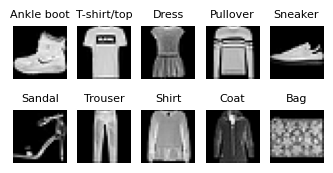

In [20]:
plotted, plot_no = [], 1
plt.figure(figsize=(4, 2))

# Initialize W&B run
wandb.init(project="backprop-from-scratch", name="plot_unique_labels")
for index, label in enumerate(train_labels): 

    if len(plotted) == len(set(train_labels)):
        break
        
    if label not in plotted: 
        plt.subplot(2, 5, plot_no)
        plt.imshow(train_images[index], cmap='grey')
        plotted.append(label)
        plt.title(f'{fashion_mnist_labels[label]}', fontsize=8)
        plt.axis("off")
        plot_no += 1

# getting the final figure
fig = plt.gcf()

#loggint the figure of wandb
wandb.log({"unique_labels_plot": wandb.Image(fig)})

plt.show()
wandb.finish()

### Question 2(10 Marks):

In [388]:
import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
            
    def predict_probability_distribution(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return neuron_outputs[-1]
    

In [393]:
# making the data ready to train the model

# Splitting the trainig data into train and validation
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)
train_size = 50000

train_x = train_images[indices[:train_size]]
train_y = train_labels[indices[:train_size]]
val_x = train_images[indices[train_size:]]
val_y = train_labels[indices[train_size:]]

train_x = train_x.reshape(train_x.shape[0], -1)
val_x = val_x.reshape(val_x.shape[0], -1)

# train_x.ravel()
# val_y.ravel()

# converting y's into one hot vector
num_classes = 10
train_y = np.eye(num_classes)[train_y]
val_y = np.eye(num_classes)[val_y]

# let's do it for test data as well
test_images = test_images.reshape(test_images.shape[0], -1)
test_labels = np.eye(num_classes)[test_labels]

In [395]:
# now let's create and train the network

# Edit the number of hidden layers and number of neurons form below list
layer_size = [784, 128, 64, 10] 
model = backprop_from_scratch(layer_size)

# now let's predict the probability distribution over the images
test_predictions = model.predict_probability_distribution(test_images) 
print(test_predictions)


[[0.06168792 0.10075537 0.03558735 ... 0.06398749 0.03049815 0.10467455]
 [0.07445819 0.11142469 0.04108252 ... 0.09940702 0.0298485  0.10449761]
 [0.07179087 0.13397358 0.04530227 ... 0.09630841 0.05370399 0.1049611 ]
 ...
 [0.07518774 0.08862722 0.03441221 ... 0.08850596 0.02593024 0.12750576]
 [0.08590609 0.14939869 0.05677292 ... 0.07607444 0.04345514 0.11763598]
 [0.09704804 0.08651904 0.0355858  ... 0.06684135 0.03228255 0.0989908 ]]


### Question 3(24 Marks):

##### Optimization algorithms to implement:

- **sgd:** make update with respect to a batch of the datapoints.
- **momentum based gradient descent:** will make an update using momentum at each step.
- **nestrov accelerated gradient descent:** why not to move a little based of momentum we've.
- **rms prop:** make learning rate inversly prop to expnentionally accumulating update histroy in that particular direction.
- **adam:** use the history and momentum, both the ideas together with a bias correction.
- **nadam:** add nestrov effect in adam.

#### vanila gradient descent



In [399]:
import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            # making an update
            self.weights[i] -= dw * learning_rate
            self.biases[i] -= db * learning_rate
        
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]
                neuron_outputs = self.forward_pass(batch_x)
                loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent numerical underflow
                total_loss += loss
                batch_num += 1
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)
    

In [401]:
# initializing hyperparms in wandb
wandb.init(project='vanilla_gradient_descent', 
           config={ 'Learning_rate' : 0.01, 
                    'epochs' : 50, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10]})

config.Learning_rate = 0.5
print(wandb.config)
config = wandb.config

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)
# passing batch size = size of the data
model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size)


{'Learning_rate': 0.5, 'epochs': 2, 'batch_size': 32, 'layer_size': [784, 128, 64, 10], 'optimizer': 'Nadam'}
32
epoch: 0, train_loss:1.9701, val_accuracy: 0.2825


In [403]:
# now let's evaluate on the test set
test_predictions = model.predict(test_images) 
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})

test_accuracy: 0.2850


#### momentum based sgd

In [150]:
# converted the same code for sgd for momentum sgd
 
import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # parameter of momentum
        self.beta = 0.90

    
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            # computing the momentum
            self.weights_velocity[i] = self.beta * self.weights_velocity[i] + dw
            self.bias_velocity[i] = self.beta * self.bias_velocity[i] + db

            # making an update
            self.weights[i] -= self.weights_velocity[i] * learning_rate
            self.biases[i] -= self.bias_velocity[i] * learning_rate

    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):

        weights_velocity, bias_velocity, beta = 0, 0, 0.95
        for epoch in range(epochs): 
            # First shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]
                neuron_outputs = self.forward_pass(batch_x)
                loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent numberical underflow
                total_loss += loss
                batch_num += 1
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)
    

In [152]:
# initializing hyperparms in wandb
wandb.init(project='backprop_scratch', 
           config={ 'Learning_rate' : 0.001, 
                    'epochs' : 50, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10],
                  'optimizer': ['sgd', 'momentum sgd'],
                  'beta': 0.90})

print(wandb.config)

config = wandb.config
config.Learning_rate = 0.001
config.batch_size = 32

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)

model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size)



{'Learning_rate': 0.001, 'epochs': 50, 'batch_size': 32, 'layer_size': [784, 128, 64, 10]}
epoch: 0, train_loss:1.4112, val_accuracy: 0.7204
epoch: 1, train_loss:0.8460, val_accuracy: 0.7577
epoch: 2, train_loss:0.7022, val_accuracy: 0.7636
epoch: 3, train_loss:0.6540, val_accuracy: 0.7860
epoch: 4, train_loss:0.6333, val_accuracy: 0.7882
epoch: 5, train_loss:0.6228, val_accuracy: 0.7847
epoch: 6, train_loss:0.6147, val_accuracy: 0.7978
epoch: 7, train_loss:0.6110, val_accuracy: 0.7903
epoch: 8, train_loss:0.6089, val_accuracy: 0.7949
epoch: 9, train_loss:0.5990, val_accuracy: 0.7893
epoch: 10, train_loss:0.6107, val_accuracy: 0.7803
epoch: 11, train_loss:0.6105, val_accuracy: 0.7844
epoch: 12, train_loss:0.6037, val_accuracy: 0.7792
epoch: 13, train_loss:0.5969, val_accuracy: 0.7907
epoch: 14, train_loss:0.5965, val_accuracy: 0.7779
epoch: 15, train_loss:0.6075, val_accuracy: 0.7869
epoch: 16, train_loss:0.6169, val_accuracy: 0.7813
epoch: 17, train_loss:0.6178, val_accuracy: 0.7818
e

In [161]:
# now let's evaluate on the test set
test_predictions = model.predict(test_images) 
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})

test_accuracy: 0.7657


#### NAG

In [225]:
# converted the same code for sgd for momentum sgd

import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # parameter of momentum
        self.beta = 0.90

    
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta * self.weights_velocity[i]) 
            + self.biases[i] - self.beta * self.bias_velocity[i] 
            
            h = self.sigmoid(a)
            neuron_outputs.append(h)
            
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta * self.weights_velocity[-1]) 
        + self.biases[-1] - self.beta * self.bias_velocity[-1]
        
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # Computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):

            # neuron_ouputs depend on the data, which we have computed in the forward pass
            # but delta will depend on on the weight matrices
    
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, (self.weights[i] - self.beta * self.weights_velocity[i]).T) * self.sigmoid_derivative(neuron_outputs[i])

            # computing the momentum
            self.weights_velocity[i] = self.beta * self.weights_velocity[i] + dw
            self.bias_velocity[i] = self.beta * self.bias_velocity[i] + db

            # making an update
            self.weights[i] -= self.weights_velocity[i] * learning_rate
            self.biases[i] -= self.bias_velocity[i] * learning_rate

    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):

        weights_velocity, bias_velocity, beta = 0, 0, 0.95
        for epoch in range(epochs): 
            # First shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]
                neuron_outputs = self.forward_pass(batch_x)
                loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent numberical underflow
                total_loss += loss
                batch_num += 1
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)
    

question is how are going to compute gradient exactly at a little bit farther distance in the direction of the momentum.

change: changed the values of biases and weights in forward function and backwork function and computed gradient at a little farther values of weights and bias.

In [227]:
# initializing hyperparms in wandb
wandb.init(project='backprop_scratch', 
           config={ 'Learning_rate' : 0.001, 
                    'epochs' : 50, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10],
                  'optimizer': ['sgd', 'momentum sgd'],
                  'beta': 0.90})

print(wandb.config)

config = wandb.config

config.batch_size = 32
config.Learning_rate = 0.001

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)

model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size)



{'Learning_rate': 0.5, 'epochs': 50, 'batch_size': 50000, 'layer_size': [784, 128, 64, 10]}
epoch: 0, train_loss:2.3683, val_accuracy: 0.1048
epoch: 1, train_loss:2.4912, val_accuracy: 0.1685
epoch: 2, train_loss:2.4400, val_accuracy: 0.3565
epoch: 3, train_loss:2.1617, val_accuracy: 0.2881
epoch: 4, train_loss:1.8930, val_accuracy: 0.4710
epoch: 5, train_loss:1.6833, val_accuracy: 0.4729
epoch: 6, train_loss:1.5278, val_accuracy: 0.5347
epoch: 7, train_loss:1.4153, val_accuracy: 0.5876
epoch: 8, train_loss:1.3095, val_accuracy: 0.6184
epoch: 9, train_loss:1.2220, val_accuracy: 0.6249
epoch: 10, train_loss:1.1707, val_accuracy: 0.5311
epoch: 11, train_loss:1.1606, val_accuracy: 0.5211
epoch: 12, train_loss:1.2205, val_accuracy: 0.4909
epoch: 13, train_loss:1.2194, val_accuracy: 0.4563
epoch: 14, train_loss:1.2705, val_accuracy: 0.5441
epoch: 15, train_loss:1.1652, val_accuracy: 0.4732
epoch: 16, train_loss:1.1547, val_accuracy: 0.5209
epoch: 17, train_loss:1.3940, val_accuracy: 0.4661


In [229]:
# now let's evaluate on the test set
test_predictions = model.predict(test_images) 
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})

test_accuracy: 0.7432


#### RMS prop 

In [269]:
import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
         # delarin and initializing the history for weights and bias
        self.history_weights = []
        self.history_bias = []

        self.history_weights = [np.zeros_like(w) for w in self.weights]
        self.history_bias = [np.zeros_like(b) for b in self.biases]

        self.beta = 0.9
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
            self.history_weights[i] = self.beta * self.history_weights[i] + (1 - self.beta) * (dw ** 2)
            self.history_bias[i] = self.beta * self.history_bias[i] + (1 - self.beta) * (db ** 2) 
            self.weights[i] -= dw * learning_rate / np.sqrt(self.history_weights[i] + 1e-12)
            self.biases[i] -= db * learning_rate / np.sqrt(self.history_bias[i] + 1e-12) 
        
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]
                neuron_outputs = self.forward_pass(batch_x)
                loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent numerical underflow
                total_loss += loss
                batch_num += 1
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)



In [271]:
# initializing hyperparms in wandb
wandb.init(project='backprop_scratch', 
           config={ 'Learning_rate' : 0.001, 
                    'epochs' : 50, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10],
                  'optimizer': ['sgd', 'momentum sgd'],
                  'beta': 0.90})

config.batch_size = 32
config.Learning_rate = 0.001
print(wandb.config)

config = wandb.config

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)

model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size)


{'Learning_rate': 0.001, 'epochs': 50, 'batch_size': 32, 'layer_size': [784, 128, 64, 10]}
epoch: 0, train_loss:0.8116, val_accuracy: 0.7628
epoch: 1, train_loss:0.5895, val_accuracy: 0.8105
epoch: 2, train_loss:0.5571, val_accuracy: 0.8000
epoch: 3, train_loss:0.5324, val_accuracy: 0.8177
epoch: 4, train_loss:0.5195, val_accuracy: 0.8128
epoch: 5, train_loss:0.5058, val_accuracy: 0.8126
epoch: 6, train_loss:0.5011, val_accuracy: 0.8194
epoch: 7, train_loss:0.4904, val_accuracy: 0.8261
epoch: 8, train_loss:0.4851, val_accuracy: 0.8239
epoch: 9, train_loss:0.4759, val_accuracy: 0.8340
epoch: 10, train_loss:0.4758, val_accuracy: 0.8304
epoch: 11, train_loss:0.4664, val_accuracy: 0.8332
epoch: 12, train_loss:0.4657, val_accuracy: 0.8224
epoch: 13, train_loss:0.4661, val_accuracy: 0.8308
epoch: 14, train_loss:0.4646, val_accuracy: 0.8301
epoch: 15, train_loss:0.4580, val_accuracy: 0.8369
epoch: 16, train_loss:0.4540, val_accuracy: 0.8397
epoch: 17, train_loss:0.4560, val_accuracy: 0.8390
e

In [276]:
# now let's evaluate on the test set
test_predictions = model.predict(test_images) 
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})

test_accuracy: 0.8374


#### adam

we have both momentum and history terms here in update rule, kind of incorporating the both ideas from momentum and RMS prop

In [289]:
import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
         # delarin and initializing the history for weights and bias
        self.history_weights = []
        self.history_bias = []

        self.history_weights = [np.zeros_like(w) for w in self.weights]
        self.history_bias = [np.zeros_like(b) for b in self.biases]

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # setting the beta
        self.beta_1 = 0.900
        self.beta_2 = 0.999
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate, t):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            # adding the momentum
            self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
            self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
            
            # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
            self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
            self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 

            # implementing the adam rule for update with bias corrected
            self.weights[i] -= self.weights_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
            self.biases[i] -= self.bias_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
        
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]
                neuron_outputs = self.forward_pass(batch_x)
                loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent numerical underflow
                total_loss += loss
                batch_num += 1
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate, batch_num)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)



In [291]:
# initializing hyperparms in wandb
wandb.init(project='backprop_scratch', 
           config={ 'Learning_rate' : 0.001, 
                    'epochs' : 50, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10],
                  'optimizer': ['sgd', 'momentum sgd'],
                  'beta': 0.90})

config.batch_size = 32
config.Learning_rate = 0.001
print(wandb.config)

config = wandb.config

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)

model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size)


{'Learning_rate': 0.001, 'epochs': 50, 'batch_size': 32, 'layer_size': [784, 128, 64, 10]}
epoch: 0, train_loss:0.9571, val_accuracy: 0.7083
epoch: 1, train_loss:0.7377, val_accuracy: 0.7421
epoch: 2, train_loss:0.7018, val_accuracy: 0.7159
epoch: 3, train_loss:0.6930, val_accuracy: 0.7339
epoch: 4, train_loss:0.6586, val_accuracy: 0.7374
epoch: 5, train_loss:0.6810, val_accuracy: 0.7373
epoch: 6, train_loss:0.6546, val_accuracy: 0.7668
epoch: 7, train_loss:0.6588, val_accuracy: 0.7540
epoch: 8, train_loss:0.6340, val_accuracy: 0.7455
epoch: 9, train_loss:0.6450, val_accuracy: 0.7700
epoch: 10, train_loss:0.6362, val_accuracy: 0.7362
epoch: 11, train_loss:0.6525, val_accuracy: 0.7618
epoch: 12, train_loss:0.6404, val_accuracy: 0.7488
epoch: 13, train_loss:0.6395, val_accuracy: 0.7360
epoch: 14, train_loss:0.6179, val_accuracy: 0.7809
epoch: 15, train_loss:0.5981, val_accuracy: 0.7725
epoch: 16, train_loss:0.6150, val_accuracy: 0.7625
epoch: 17, train_loss:0.6226, val_accuracy: 0.7868
e

In [292]:
# now let's evaluate on the test set
test_predictions = model.predict(test_images) 
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})

test_accuracy: 0.8011


#### nadam

there is a little change in adam, we just need to change the bias corrected momentum term.

In [305]:
import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
         # delarin and initializing the history for weights and bias
        self.history_weights = []
        self.history_bias = []

        self.history_weights = [np.zeros_like(w) for w in self.weights]
        self.history_bias = [np.zeros_like(b) for b in self.biases]

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # setting the beta
        self.beta_1 = 0.900
        self.beta_2 = 0.999
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate, t):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            # adding the momentum
            self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
            self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
            
            # we need to change the learning rate at each iteration as per history accumulated for the current layer w&b
            self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
            self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
            
            # implementing the nadam rule for update with bias corrected
            self.weights[i] -= ((self.beta_1 * self.weights_velocity[i]) + (1 - self.beta_1) * dw)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
            self.biases[i] -= ((self.beta_1 * self.bias_velocity[i]) + (1 - self.beta_1) * db)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
        
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]
                neuron_outputs = self.forward_pass(batch_x)
                loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent num underflow
                total_loss += loss
                batch_num += 1
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate, batch_num)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)



In [307]:
# initializing hyperparms in wandb
wandb.init(project='backprop_scratch', 
           config={ 'Learning_rate' : 0.001, 
                    'epochs' : 50, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10],
                  'optimizer': ['sgd', 'momentum sgd','NAG','RMS_Prop','Adam','Nadam'],
                  'beta': 0.90})

config.batch_size = 32
config.Learning_rate = 0.001
print(wandb.config)

config = wandb.config

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)

model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size)


{'Learning_rate': 0.001, 'epochs': 50, 'batch_size': 32, 'layer_size': [784, 128, 64, 10]}
epoch: 0, train_loss:0.9505, val_accuracy: 0.6881
epoch: 1, train_loss:0.7208, val_accuracy: 0.7190
epoch: 2, train_loss:0.7140, val_accuracy: 0.7253
epoch: 3, train_loss:0.7019, val_accuracy: 0.7474
epoch: 4, train_loss:0.6932, val_accuracy: 0.7219
epoch: 5, train_loss:0.6906, val_accuracy: 0.7432
epoch: 6, train_loss:0.6686, val_accuracy: 0.7378
epoch: 7, train_loss:0.6739, val_accuracy: 0.7520
epoch: 8, train_loss:0.6461, val_accuracy: 0.7461
epoch: 9, train_loss:0.6465, val_accuracy: 0.7479
epoch: 10, train_loss:0.6472, val_accuracy: 0.7699
epoch: 11, train_loss:0.6330, val_accuracy: 0.7483
epoch: 12, train_loss:0.6443, val_accuracy: 0.7632
epoch: 13, train_loss:0.6240, val_accuracy: 0.7578
epoch: 14, train_loss:0.6208, val_accuracy: 0.7502
epoch: 15, train_loss:0.6359, val_accuracy: 0.7490
epoch: 16, train_loss:0.6163, val_accuracy: 0.7637
epoch: 17, train_loss:0.6059, val_accuracy: 0.7439
e

In [308]:
# now let's evaluate on the test set
test_predictions = model.predict(test_images) 
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})

test_accuracy: 0.7904


#### writing all the optimization algos in one implementation:

In [421]:
import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
         # delarin and initializing the history for weights and bias
        self.history_weights = []
        self.history_bias = []

        self.history_weights = [np.zeros_like(w) for w in self.weights]
        self.history_bias = [np.zeros_like(b) for b in self.biases]

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # setting the beta
        self.beta_1 = 0.900
        self.beta_2 = 0.999
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    
    def forward_pass_NAG(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta_1 * self.weights_velocity[i]) 
            + self.biases[i] - self.beta_1 * self.bias_velocity[i] 
            
            h = self.sigmoid(a)
            neuron_outputs.append(h)
            
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta_1 * self.weights_velocity[-1]) 
        + self.biases[-1] - self.beta_1 * self.bias_velocity[-1]
        
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs

    
    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate, t, optimizer):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            if optimizer == 'sgd':

                # making an update
                self.weights[i] -= dw * learning_rate
                self.biases[i] -= db * learning_rate

                
            elif optimizer == 'momentum sgd':
                
                # computing the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
        
                # making an update
                self.weights[i] -= self.weights_velocity[i] * learning_rate
                self.biases[i] -= self.bias_velocity[i] * learning_rate

            elif optimizer == 'RMS_Prop':
                
                # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                self.history_weights[i] = self.beta_1 * self.history_weights[i] + (1 - self.beta_1) * (dw ** 2)
                self.history_bias[i] = self.beta_1 * self.history_bias[i] + (1 - self.beta_1) * (db ** 2) 
                self.weights[i] -= dw * learning_rate / np.sqrt(self.history_weights[i] + 1e-12)
                self.biases[i] -= db * learning_rate / np.sqrt(self.history_bias[i] + 1e-12)

            elif optimizer == 'Adam':
                
                # adding the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
                
                # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
    
                # implementing the adam rule for update with bias corrected
                self.weights[i] -= self.weights_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                self.biases[i] -= self.bias_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 

            elif optimizer == 'Nadam':
                
                # adding the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
    
                # we need to change the learning rate at each iteration as per history accumulated for the current layer w&b
                self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
                
                # implementing the nadam rule for update with bias corrected
                self.weights[i] -= ((self.beta_1 * self.weights_velocity[i]) + (1 - self.beta_1) * dw)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                self.biases[i] -= ((self.beta_1 * self.bias_velocity[i]) + (1 - self.beta_1) * db)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 

    # if optmizer is NAG
    def backword_pass_NAG(self, X, y, neuron_outputs, learning_rate):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # Computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):

            # neuron_ouputs depend on the data, which we have computed in the forward pass
            # but delta will depend on on the weight matrices
    
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.sigmoid_derivative(neuron_outputs[i])

            # computing the momentum
            self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
            self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db

            # making an update
            self.weights[i] -= self.weights_velocity[i] * learning_rate
            self.biases[i] -= self.bias_velocity[i] * learning_rate
            
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size, optimizer):
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]

                if optimizer != 'NAG':
                    neuron_outputs = self.forward_pass(batch_x)
                else: 
                    neuron_outputs = self.forward_pass_NAG(batch_x)
                    
                loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent num underflow
                total_loss += loss
                batch_num += 1
                
                if optimizer != 'NAG':
                    self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate, batch_num, optimizer)
                else: 
                    self.backword_pass_NAG(batch_x, batch_y, neuron_outputs, learning_rate)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)



In [423]:
# initializing hyperparms in wandb
wandb.init(project='backprop_scratch', 
           config={ 'Learning_rate' : 0.001, 
                    'epochs' : 50, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10],
                  'optimizer': 'NAG',
                  'beta': 0.90})

optimizers = ['sgd', 'momentum sgd','NAG','RMS_Prop','Adam','Nadam']
config = wandb.config
config.Learning_rate = 0.001
config.optimizer = 'sgd'
config.epochs = 10
print(wandb.config)

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)
model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size, config.optimizer)


{'Learning_rate': 0.001, 'epochs': 10, 'batch_size': 32, 'layer_size': [784, 128, 64, 10], 'optimizer': 'sgd'}
epoch: 0, train_loss:2.1310, val_accuracy: 0.5757
epoch: 1, train_loss:1.7980, val_accuracy: 0.6261
epoch: 2, train_loss:1.5951, val_accuracy: 0.6426
epoch: 3, train_loss:1.4327, val_accuracy: 0.6549
epoch: 4, train_loss:1.2992, val_accuracy: 0.6731
epoch: 5, train_loss:1.1915, val_accuracy: 0.6900
epoch: 6, train_loss:1.1041, val_accuracy: 0.7048
epoch: 7, train_loss:1.0335, val_accuracy: 0.7148
epoch: 8, train_loss:0.9741, val_accuracy: 0.7309
epoch: 9, train_loss:0.9247, val_accuracy: 0.7456


In [414]:
# now let's evaluate on the test set
test_predictions = model.predict(test_images) 
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})

test_accuracy: 0.8150


### Question 4:(10 Marks):

- further work make the code work from command promt and training logs should be visible wandb meanwhile its traning.
- quesiton 4 requires you to implement with different regularization/activation/initializatin and make it flexible.
- required you to implement the code with loss squred error.
- and to run a lot of experiments.

##### made the code flexible for MSE

In [489]:
import numpy as np 
from keras.datasets import fashion_mnist # used just to get the data
import wandb

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
         # delarin and initializing the history for weights and bias
        self.history_weights = []
        self.history_bias = []

        self.history_weights = [np.zeros_like(w) for w in self.weights]
        self.history_bias = [np.zeros_like(b) for b in self.biases]

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # setting the beta with there default values
        self.beta_1 = 0.900
        self.beta_2 = 0.999
     
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs


    def forward_pass_NAG(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta_1 * self.weights_velocity[i]) 
            + self.biases[i] - self.beta_1 * self.bias_velocity[i] 
            
            h = self.sigmoid(a)
            neuron_outputs.append(h)
            
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta_1 * self.weights_velocity[-1]) 
        + self.biases[-1] - self.beta_1 * self.bias_velocity[-1]
        
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs


    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate, t, optimizer, loss_function): 
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer
        if loss_function == 'categorical_cross_entropy':   
            delta = neuron_outputs[-1] - y # shape of delta is 32 x 10
            
        else:
            
            batch_size = len(neuron_outputs[-1])
            classes = len(neuron_outputs[-1][0])
            # size mismatch problem here
            delta = np.zeros((batch_size, classes))
            
            for i in range(batch_size):
                softmax_jacobian = np.diag(neuron_outputs[-1][i]) - np.outer(neuron_outputs[-1][i], neuron_outputs[-1][i])
                # print(softmax_jacobian.shape)
                # print(neuron_output[-1][i]
                delta[i] = 2 * np.dot(neuron_outputs[-1][i] - y[i], softmax_jacobian)
                
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            if optimizer == 'sgd':

                # making an update
                self.weights[i] -= dw * learning_rate
                self.biases[i] -= db * learning_rate

                
            elif optimizer == 'momentum sgd':
                
                # computing the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
        
                # making an update
                self.weights[i] -= self.weights_velocity[i] * learning_rate
                self.biases[i] -= self.bias_velocity[i] * learning_rate

            elif optimizer == 'RMS_Prop':
                
                # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                self.history_weights[i] = self.beta_1 * self.history_weights[i] + (1 - self.beta_1) * (dw ** 2)
                self.history_bias[i] = self.beta_1 * self.history_bias[i] + (1 - self.beta_1) * (db ** 2) 
                self.weights[i] -= dw * learning_rate / np.sqrt(self.history_weights[i] + 1e-12)
                self.biases[i] -= db * learning_rate / np.sqrt(self.history_bias[i] + 1e-12)

            elif optimizer == 'Adam':
                
                # adding the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
                
                # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
    
                # implementing the adam rule for update with bias corrected
                self.weights[i] -= self.weights_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                self.biases[i] -= self.bias_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 

            elif optimizer == 'Nadam':
                
                # adding the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
    
                # we need to change the learning rate at each iteration as per history accumulated for the current layer w&b
                self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
                
                # implementing the nadam rule for update with bias corrected
                self.weights[i] -= ((self.beta_1 * self.weights_velocity[i]) + (1 - self.beta_1) * dw)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                self.biases[i] -= ((self.beta_1 * self.bias_velocity[i]) + (1 - self.beta_1) * db)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 

    # if optmizer is NAG
    def backword_pass_NAG(self, X, y, neuron_outputs, learning_rate):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # Computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):

            # neuron_ouputs depend on the data, which we have computed in the forward pass
            # but delta will depend on on the weight matrices
    
            dw = np.dot(neuron_outputs[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.sigmoid_derivative(neuron_outputs[i])

            # computing the momentum
            self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
            self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db

            # making an update
            self.weights[i] -= self.weights_velocity[i] * learning_rate
            self.biases[i] -= self.bias_velocity[i] * learning_rate
            
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.001, batch_size=32, optimizer="RMS_Prop", beta_1=0.900, beta_2=0.999, loss_function='categorical_cross_entropy'): # setting RMS_Prop as default optimizer
        
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]

                if optimizer != 'NAG':
                    neuron_outputs = self.forward_pass(batch_x)
                else: 
                    neuron_outputs = self.forward_pass_NAG(batch_x)
                    
                if loss_function == 'categorical_cross_entropy':
                  loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) # to prevent num underflow
                else:
                  loss = np.mean(np.sum((batch_y - neuron_outputs[-1]) ** 2, axis = 1)) # loss function for MSE
            
                total_loss += loss
                batch_num += 1
                
                if optimizer != 'NAG':
                    self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate, batch_num, optimizer, loss_function)
                else: 
                    self.backword_pass_NAG(batch_x, batch_y, neuron_outputs, learning_rate)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)


if __name__ == "__main__": # will run only when script will be executed directly
    
    wandb.login()
    # will check first which data is given in the arguement, yet to do that
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    # making the data ready to train the model

    # Splitting the trainig data into train and validation
    indices = np.arange(train_images.shape[0])
    np.random.shuffle(indices)
    train_size = 50000

    train_x = train_images[indices[:train_size]]
    train_y = train_labels[indices[:train_size]]
    val_x = train_images[indices[train_size:]]
    val_y = train_labels[indices[train_size:]]

    train_x = train_x.reshape(train_x.shape[0], -1)
    val_x = val_x.reshape(val_x.shape[0], -1)


    # converting y's into one hot vector
    num_classes = 10
    train_y = np.eye(num_classes)[train_y]
    val_y = np.eye(num_classes)[val_y]

    # let's do it for test data as well
    test_images = test_images.reshape(test_images.shape[0], -1)
    test_labels = np.eye(num_classes)[test_labels]

    # initializing hyperparms in wandb
    optimizers = ['sgd', 'momentum sgd','NAG','RMS_Prop','Adam','Nadam']
    loss = ['mean_squared', 'categorical_cross_entropy']
    
    wandb.init(project='backprop_scratch', 
            config={ 'Learning_rate' : 0.001, 
                        'epochs' : 50, 
                        'batch_size' : 32, 
                        'layer_size' : [784, 128, 64, 10], 
                    'optimizer': 'RMS_Prop',
                    'beta_1': 0.900,         # beta 1 is for momentum sgd, NAG, RMS_Prop
                    'beta_2': 0.999,
                   'loss_function': 'mean_squared'}         # use beta 2 for Nadam and Adam
            ) # select optimizer from optimizer list up there 

    config.beta_1 = 0.900
    config.beta_2 = 0.999
    config.epochs = 50
    config.loss_function = 'mean_squared'
    
    config = wandb.config
    print(wandb.config)

    # now let's create and train the network
    model = backprop_from_scratch(config.layer_size)
    model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size, config.optimizer, config.beta_1, config.beta_2, config.loss_function)

    # now let's evaluate on the test set
    test_predictions = model.predict(test_images) 
    test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
    print(f"test_accuracy:{test_accuracy: .4f}") 
    wandb.log({'test_accuracy': test_accuracy})


SyntaxError: invalid syntax (2059849918.py, line 121)

##### incorporated weight decay

In [28]:
import numpy as np 
from keras.datasets import fashion_mnist # used just to get the data
import wandb

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
         # delarin and initializing the history for weights and bias
        self.history_weights = []
        self.history_bias = []

        self.history_weights = [np.zeros_like(w) for w in self.weights]
        self.history_bias = [np.zeros_like(b) for b in self.biases]

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # setting the beta with there default values
        self.beta_1 = 0.900
        self.beta_2 = 0.999
     
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
            
    def forward_pass(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            neuron_outputs.append(h)
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs


    def forward_pass_NAG(self, data_X):
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(neuron_outputs[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta_1 * self.weights_velocity[i]) 
            + self.biases[i] - self.beta_1 * self.bias_velocity[i] 
            
            h = self.sigmoid(a)
            neuron_outputs.append(h)
            
        # pass thorugh the output layer
        a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta_1 * self.weights_velocity[-1]) 
        + self.biases[-1] - self.beta_1 * self.bias_velocity[-1]
        
        output = self.softmax(a)
        neuron_outputs.append(output)
        return neuron_outputs


    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate, t, optimizer, loss_function, weight_decay): 
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer
        if loss_function == 'categorical_cross_entropy':   
            delta = neuron_outputs[-1] - y # shape of delta is 32 x 10
            
        else:
            
            batch_size = len(neuron_outputs[-1])
            classes = len(neuron_outputs[-1][0])
            # size mismatch problem here
            delta = np.zeros((batch_size, classes))
            
            for i in range(batch_size):
                softmax_jacobian = np.diag(neuron_outputs[-1][i]) - np.outer(neuron_outputs[-1][i], neuron_outputs[-1][i])
                # print(softmax_jacobian.shape)
                # print(neuron_output[-1][i]
                delta[i] = 2 * np.dot(neuron_outputs[-1][i] - y[i], softmax_jacobian)
                
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            
            dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
            db = (np.sum(delta, axis=0, keepdims=True) / batch_size) + weight_decay * self.biases[i]
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])

            if optimizer == 'sgd':

                # making an update
                self.weights[i] -= dw * learning_rate
                self.biases[i] -= db * learning_rate

                
            elif optimizer == 'momentum sgd':
                
                # computing the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
        
                # making an update
                self.weights[i] -= self.weights_velocity[i] * learning_rate
                self.biases[i] -= self.bias_velocity[i] * learning_rate

            elif optimizer == 'RMS_Prop':
                
                # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                self.history_weights[i] = self.beta_1 * self.history_weights[i] + (1 - self.beta_1) * (dw ** 2)
                self.history_bias[i] = self.beta_1 * self.history_bias[i] + (1 - self.beta_1) * (db ** 2) 
                self.weights[i] -= dw * learning_rate / np.sqrt(self.history_weights[i] + 1e-12)
                self.biases[i] -= db * learning_rate / np.sqrt(self.history_bias[i] + 1e-12)

            elif optimizer == 'Adam':
                
                # adding the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
                
                # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
    
                # implementing the adam rule for update with bias corrected
                self.weights[i] -= self.weights_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                self.biases[i] -= self.bias_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 

            elif optimizer == 'Nadam':
                
                # adding the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
    
                # we need to change the learning rate at each iteration as per history accumulated for the current layer w&b
                self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
                
                # implementing the nadam rule for update with bias corrected
                self.weights[i] -= ((self.beta_1 * self.weights_velocity[i]) + (1 - self.beta_1) * dw)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                self.biases[i] -= ((self.beta_1 * self.bias_velocity[i]) + (1 - self.beta_1) * db)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 

    # if optmizer is NAG
    def backword_pass_NAG(self, X, y, neuron_outputs, learning_rate, weight_decay):
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # Computing gradies with repect to the output layer 
        delta = neuron_outputs[-1] - y
        
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):

            # neuron_ouputs depend on the data, which we have computed in the forward pass
            # but delta will depend on on the weight matrices
            
            dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
            db = (np.sum(delta, axis=0, keepdims=True) / batch_size) + weight_decay * self.biases[i]
            
            if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.sigmoid_derivative(neuron_outputs[i])

            # computing the momentum
            self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
            self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db

            # making an update
            self.weights[i] -= self.weights_velocity[i] * learning_rate
            self.biases[i] -= self.bias_velocity[i] * learning_rate
            
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.001, batch_size=32, optimizer="RMS_Prop", beta_1=0.900, beta_2=0.999, loss_function='categorical_cross_entropy', weight_decay = 0): # setting RMS_Prop as default optimizer
        
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]

                if optimizer != 'NAG':
                    neuron_outputs = self.forward_pass(batch_x)
                else: 
                    neuron_outputs = self.forward_pass_NAG(batch_x)

                l2_norm_weights, l2_norm_bias = 0, 0
                for i in range(len(self.weights)):
                    l2_norm_weights += np.sum(self.weights[i] ** 2)
                for i in range(len(self.biases)):
                    l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
                l2_norm_params = l2_norm_bias + l2_norm_weights
                if loss_function == 'categorical_cross_entropy':
                    loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) +  (weight_decay/2) * l2_norm_params 
                    # added 1e-10 to prevent num underflow
                else:
                    loss = np.mean(np.sum((batch_y - neuron_outputs[-1]) ** 2, axis = 1)) + (weight_decay/2) * l2_norm_params
                    # loss function for MSE
            
                total_loss += loss
                batch_num += 1
                
                if optimizer != 'NAG':
                    self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate, batch_num, optimizer, loss_function, weight_decay)
                else: 
                    self.backword_pass_NAG(batch_x, batch_y, neuron_outputs, learning_rate, weight_decay)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)


if __name__ == "__main__": # will run only when script will be executed directly
    
    wandb.login()
    # will check first which data is given in the arguement, yet to do that
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    # making the data ready to train the model

    # Splitting the trainig data into train and validation
    indices = np.arange(train_images.shape[0])
    np.random.shuffle(indices)
    train_size = 50000

    train_x = train_images[indices[:train_size]]
    train_y = train_labels[indices[:train_size]]
    val_x = train_images[indices[train_size:]]
    val_y = train_labels[indices[train_size:]]

    train_x = train_x.reshape(train_x.shape[0], -1)
    val_x = val_x.reshape(val_x.shape[0], -1)


    # converting y's into one hot vector
    num_classes = 10
    train_y = np.eye(num_classes)[train_y]
    val_y = np.eye(num_classes)[val_y]

    # let's do it for test data as well
    test_images = test_images.reshape(test_images.shape[0], -1)
    test_labels = np.eye(num_classes)[test_labels]

    # initializing hyperparms in wandb
    optimizers = ['sgd', 'momentum sgd','NAG','RMS_Prop','Adam','Nadam']
    loss = ['mean_squared', 'categorical_cross_entropy']
    
    wandb.init(project='backprop_scratch', 
            config={ 'Learning_rate' : 0.001, 
                        'epochs' : 50, 
                        'batch_size' : 32, 
                        'layer_size' : [784, 128, 64, 10], 
                    'optimizer': 'RMS_Prop',
                    'beta_1': 0.900,         # beta 1 is for momentum sgd, NAG, RMS_Prop
                    'beta_2': 0.999,         # use beta 2 for Nadam and Adam
                   'loss_function': 'mean_squared',
                    'weight_decay': 0
                   }         
            ) # select optimizer from optimizer list up there 

    config.beta_1 = 0.900
    config.beta_2 = 0.999
    config.epochs = 10
    config.loss_function = 'mean_squared'
    config.weight_decay = 0
    config.optimizer = 'NAG'
    config = wandb.config
    print(wandb.config)

    # now let's create and train the network
    model = backprop_from_scratch(config.layer_size)
    model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size, config.optimizer, config.beta_1, config.beta_2, config.loss_function, config.weight_decay)

    # now let's evaluate on the test set
    test_predictions = model.predict(test_images) 
    test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
    print(f"test_accuracy:{test_accuracy: .4f}") 
    wandb.log({'test_accuracy': test_accuracy})


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


{'Learning_rate': 0.01, 'epochs': 10, 'batch_size': 32, 'layer_size': [784, 128, 64, 10], 'optimizer': 'NAG', 'beta_1': 0.9, 'beta_2': 0.999, 'loss_function': 'mean_squared', 'weight_decay': 0, 'activation_function': 'ReLu'}
epoch: 0, train_loss:0.7511, val_accuracy: 0.5813
epoch: 1, train_loss:0.6660, val_accuracy: 0.5437
epoch: 2, train_loss:0.6414, val_accuracy: 0.5095
epoch: 3, train_loss:0.6419, val_accuracy: 0.4708
epoch: 4, train_loss:0.6066, val_accuracy: 0.5809
epoch: 5, train_loss:0.5855, val_accuracy: 0.5081
epoch: 6, train_loss:0.5675, val_accuracy: 0.5943
epoch: 7, train_loss:0.5773, val_accuracy: 0.5120
epoch: 8, train_loss:0.5350, val_accuracy: 0.4476
epoch: 9, train_loss:0.5264, val_accuracy: 0.5290
test_accuracy: 0.5349


##### fixed some bugs: 1) Made single function for nestrov as well, 2) Corrected inferencing for nestrov

In [61]:
import numpy as np 
from keras.datasets import fashion_mnist # used just to get the data
import wandb

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
         # delarin and initializing the history for weights and bias
        self.history_weights = []
        self.history_bias = []

        self.history_weights = [np.zeros_like(w) for w in self.weights]
        self.history_bias = [np.zeros_like(b) for b in self.biases]

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # setting the beta with there default values
        self.beta_1 = 0.900
        self.beta_2 = 0.999
     
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
            
    def forward_pass(self, data_X, optimizer='RMS_Prop'): # setting defalut optimizer as RMS_Prop cauz while infering we 
        # used this function meaning we dont want updated forward pass for NAG, while inferring.
        
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        if optimizer != 'NAG':
            for i in range(self.num_layers - 2): 
                
                # print("ran")
                # print(neuron_outputs[-1].shape)
                # print(self.weights[i].shape)
                # print(self.biases[i].shape)
                
                a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
                h = self.sigmoid(a)
                neuron_outputs.append(h)
            # pass thorugh the output layer
            a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
            output = self.softmax(a)
            neuron_outputs.append(output)
            return neuron_outputs
            
        else: # if optimizer is NAG
            for i in range(self.num_layers - 2): 
                
                # print("ran")
                # print(neuron_outputs[-1].shape)
                # print(self.weights[i].shape)
                # print(self.biases[i].shape)
                
                a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta_1 * self.weights_velocity[i]) 
                + self.biases[i] - self.beta_1 * self.bias_velocity[i] 
                
                h = self.sigmoid(a)
                neuron_outputs.append(h)
                
            # pass thorugh the output layer
            a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta_1 * self.weights_velocity[-1]) 
            + self.biases[-1] - self.beta_1 * self.bias_velocity[-1]
            
            output = self.softmax(a)
            neuron_outputs.append(output)
            return neuron_outputs
            


    # def forward_pass_NAG(self, data_X):
    #     neuron_outputs = [data_X]
    #     # pass thorugh hidden layers

        
    #     for i in range(self.num_layers - 2): 
            
    #         # print("ran")
    #         # print(neuron_outputs[-1].shape)
    #         # print(self.weights[i].shape)
    #         # print(self.biases[i].shape)
            
    #         a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta_1 * self.weights_velocity[i]) 
    #         + self.biases[i] - self.beta_1 * self.bias_velocity[i] 
            
    #         h = self.sigmoid(a)
    #         neuron_outputs.append(h)
            
    #     # pass thorugh the output layer
    #     a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta_1 * self.weights_velocity[-1]) 
    #     + self.biases[-1] - self.beta_1 * self.bias_velocity[-1]
        
    #     output = self.softmax(a)
    #     neuron_outputs.append(output)
    #     return neuron_outputs


    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 

    def relu(self, x):
        return max(0,x)

    def relu_derivative(self, x): 
        return np.where(x>0, 1, 0)

    def tanh(self, x): 
       return np.tanh(x) 
        
    def tanh_derivative(self, x): 
        return 1 - np.tanh(x) ** 2
    
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate, t, optimizer, loss_function, weight_decay): 
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer
        if loss_function == 'categorical_cross_entropy':   
            delta = neuron_outputs[-1] - y # shape of delta is 32 x 10
            
        else:
            
            batch_size = len(neuron_outputs[-1])
            classes = len(neuron_outputs[-1][0])
            # size mismatch problem here
            delta = np.zeros((batch_size, classes))
            
            for i in range(batch_size):
                softmax_jacobian = np.diag(neuron_outputs[-1][i]) - np.outer(neuron_outputs[-1][i], neuron_outputs[-1][i])
                # print(softmax_jacobian.shape)
                # print(neuron_output[-1][i]
                delta[i] = 2 * np.dot(neuron_outputs[-1][i] - y[i], softmax_jacobian)
                
        if optimizer != 'NAG':
            
            # computing gradient with respect to hidden layers
            for i in range(self.num_layers - 2, -1, -1):
                
                dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
                db = (np.sum(delta, axis=0, keepdims=True) / batch_size) + weight_decay * self.biases[i]
                
                if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                    delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])
    
                if optimizer == 'sgd':
    
                    # making an update
                    self.weights[i] -= dw * learning_rate
                    self.biases[i] -= db * learning_rate
    
                    
                elif optimizer == 'momentum sgd':
                    
                    # computing the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
            
                    # making an update
                    self.weights[i] -= self.weights_velocity[i] * learning_rate
                    self.biases[i] -= self.bias_velocity[i] * learning_rate
    
                elif optimizer == 'RMS_Prop':
                    
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                    self.history_weights[i] = self.beta_1 * self.history_weights[i] + (1 - self.beta_1) * (dw ** 2)
                    self.history_bias[i] = self.beta_1 * self.history_bias[i] + (1 - self.beta_1) * (db ** 2) 
                    self.weights[i] -= dw * learning_rate / np.sqrt(self.history_weights[i] + 1e-12)
                    self.biases[i] -= db * learning_rate / np.sqrt(self.history_bias[i] + 1e-12)
    
                elif optimizer == 'Adam':
                    
                    # adding the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
                    
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                    self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                    self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
        
                    # implementing the adam rule for update with bias corrected
                    self.weights[i] -= self.weights_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                    self.biases[i] -= self.bias_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
    
                elif optimizer == 'Nadam':
                    
                    # adding the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
        
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w&b
                    self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                    self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
                    
                    # implementing the nadam rule for update with bias corrected
                    self.weights[i] -= ((self.beta_1 * self.weights_velocity[i]) + (1 - self.beta_1) * dw)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                    self.biases[i] -= ((self.beta_1 * self.bias_velocity[i]) + (1 - self.beta_1) * db)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
                    
        else: # if optimizer is 'NAG'
            
            for i in range(self.num_layers - 2, -1, -1):
    
                # neuron_ouputs depend on the data, which we have computed in the forward pass
                # but delta will depend on on the weight matrices
                
                dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
                db = (np.sum(delta, axis=0, keepdims=True) / batch_size) + weight_decay * self.biases[i]
                
                if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                    delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.sigmoid_derivative(neuron_outputs[i])
    
                # computing the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
    
                # making an update
                self.weights[i] -= self.weights_velocity[i] * learning_rate
                self.biases[i] -= self.bias_velocity[i] * learning_rate
    
    # # if optmizer is NAG
    # def backword_pass_NAG(self, X, y, neuron_outputs, learning_rate, weight_decay):
        
    #     # compute the gradient at given value of params
    #     batch_size = len(X)
        
    #     # Computing gradies with repect to the output layer 
    #     delta = neuron_outputs[-1] - y
        
    #     # computing gradient with respect to hidden layers
    #     for i in range(self.num_layers - 2, -1, -1):

    #         # neuron_ouputs depend on the data, which we have computed in the forward pass
    #         # but delta will depend on on the weight matrices
            
    #         dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
    #         db = (np.sum(delta, axis=0, keepdims=True) / batch_size) + weight_decay * self.biases[i]
            
    #         if i>0: # because computing delta for i=0 will be absolutely un-necessary.
    #             delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.sigmoid_derivative(neuron_outputs[i])

    #         # computing the momentum
    #         self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
    #         self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db

    #         # making an update
    #         self.weights[i] -= self.weights_velocity[i] * learning_rate
    #         self.biases[i] -= self.bias_velocity[i] * learning_rate
        
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.001, batch_size=32, optimizer="NAG", beta_1=0.900, beta_2=0.999, loss_function='categorical_cross_entropy', weight_decay = 0, activation_function='ReLu'): # setting RMS_Prop as default optimizer
        
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]

                # calling forward and remember it's different for NAG so passing optmizer in it, to check inside it it's NAG
                neuron_outputs = self.forward_pass(batch_x, optimizer)

                l2_norm_weights, l2_norm_bias = 0, 0
                for i in range(len(self.weights)):
                    l2_norm_weights += np.sum(self.weights[i] ** 2)
                for i in range(len(self.biases)):
                    l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
                l2_norm_params = l2_norm_bias + l2_norm_weights
                if loss_function == 'categorical_cross_entropy':
                    loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) +  (weight_decay/2) * l2_norm_params 
                    # added 1e-10 to prevent num underflow
                else:
                    loss = np.mean(np.sum((batch_y - neuron_outputs[-1]) ** 2, axis = 1)) + (weight_decay/2) * l2_norm_params
                    # loss function for MSE
            
                total_loss += loss
                batch_num += 1
                
                # backprop: computing the gradient and making an update in backwork pass func
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate, batch_num, optimizer, loss_function, weight_decay)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)


if __name__ == "__main__": # will run only when script will be executed directly
    
    wandb.login()
    # will check first which data is given in the arguement, yet to do that
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    # making the data ready to train the model

    # Splitting the trainig data into train and validation
    indices = np.arange(train_images.shape[0])
    np.random.shuffle(indices)
    train_size = 50000

    train_x = train_images[indices[:train_size]]
    train_y = train_labels[indices[:train_size]]
    val_x = train_images[indices[train_size:]]
    val_y = train_labels[indices[train_size:]]

    train_x = train_x.reshape(train_x.shape[0], -1) / 255
    val_x = val_x.reshape(val_x.shape[0], -1) / 255


    # converting y's into one hot vector
    num_classes = 10
    train_y = np.eye(num_classes)[train_y]
    val_y = np.eye(num_classes)[val_y]

    # let's do it for test data as well
    test_images = test_images.reshape(test_images.shape[0], -1) / 255
    test_labels = np.eye(num_classes)[test_labels]

    # initializing hyperparms in wandb
    optimizers = ['sgd', 'momentum sgd','NAG','RMS_Prop','Adam','Nadam']
    loss = ['mean_squared', 'categorical_cross_entropy']
    activation_function = ['ReLu', 'Sigmoid', 'Linear', 'tanh']
    
    wandb.init(project='backprop_scratch', 
            config={ 'Learning_rate' : 0.001, 
                        'epochs' : 50, 
                        'batch_size' : 32, 
                        'layer_size' : [784, 128, 64, 10], 
                    'optimizer': 'RMS_Prop',
                    'beta_1': 0.900,         # beta 1 is for momentum sgd, NAG, RMS_Prop
                    'beta_2': 0.999,         # use beta 2 for Nadam and Adam
                   'loss_function': 'mean_squared',
                    'weight_decay': 0,
                    'activation_function': 'ReLu'
                   }         
            ) # select optimizer from optimizer list up there 
    
    config = wandb.config
    config.beta_1 = 0.900
    config.beta_2 = 0.999
    config.epochs = 10
    config.loss_function = 'categorical_cross_entropy'
    config.weight_decay = 0
    config.optimizer = 'NAG'
    config.Learning_rate = 0.001
    print(wandb.config)

    # now let's create and train the network
    model = backprop_from_scratch(config.layer_size)
    model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size, config.optimizer, config.beta_1, config.beta_2, config.loss_function, config.weight_decay, config.activation_function)
    # now let's evaluate on the test set
    test_predictions = model.predict(test_images) 
    test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
    print(f"test_accuracy:{test_accuracy: .4f}") 
    wandb.log({'test_accuracy': test_accuracy})


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


{'Learning_rate': 0.001, 'epochs': 10, 'batch_size': 32, 'layer_size': [784, 128, 64, 10], 'optimizer': 'NAG', 'beta_1': 0.9, 'beta_2': 0.999, 'loss_function': 'categorical_cross_entropy', 'weight_decay': 0, 'activation_function': 'ReLu', 'initialization': 'xavier', 'activation': 'ReLu'}
epoch: 0, train_loss:1.7924, val_accuracy: 0.5953
epoch: 1, train_loss:1.3727, val_accuracy: 0.6759
epoch: 2, train_loss:1.1526, val_accuracy: 0.7124
epoch: 3, train_loss:1.0215, val_accuracy: 0.7294
epoch: 4, train_loss:0.9282, val_accuracy: 0.7382
epoch: 5, train_loss:0.8694, val_accuracy: 0.7438
epoch: 6, train_loss:0.8218, val_accuracy: 0.7486
epoch: 7, train_loss:0.7924, val_accuracy: 0.7520
epoch: 8, train_loss:0.7625, val_accuracy: 0.7581
epoch: 9, train_loss:0.7448, val_accuracy: 0.7645
test_accuracy: 0.7554


### Question:4(10 Marks)

In [2]:
import numpy as np 
from keras.datasets import fashion_mnist # used just to get the data
import wandb

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size, activation_function = 'ReLu', initialization = 'xavier'):
        
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.activation_function = activation_function
        self.initialization = initialization
        self.initialize_params()
        
         # declaring and initializing the history for weights and bias
        self.history_weights = []
        self.history_bias = []

        self.history_weights = [np.zeros_like(w) for w in self.weights]
        self.history_bias = [np.zeros_like(b) for b in self.biases]

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # setting the beta with there default values
        self.beta_1 = 0.900
        self.beta_2 = 0.999
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            if self.initialization == 'xavier':
                w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(1/self.layer_sizes[i])
            elif self.initialization == 'random': 
                w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) 
            else: 
                raise ValueError('invalid initialization method passed')
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
        # print(self.weights)
        # print(self.biases)

            
    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 

    def relu(self, x):
        return np.maximum(0,x)

    def relu_derivative(self, x): 
        return np.where(x>0, 1, 0)

    def tanh(self, x): 
       return np.tanh(x) 
        
    def tanh_derivative(self, x): 
        return 1 - x ** 2
    
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
        
    def forward_pass(self, data_X, Learning_rate, optimizer='RMS_Prop'): # setting defalut optimizer as RMS_Prop cauz while infering we 
        # used this function meaning we dont want updated forward pass for NAG, while inferring.
        
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        if optimizer != 'NAG':
            for i in range(self.num_layers - 2): 
        
                
                a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
                if self.activation_function == 'ReLu':
                    h = self.relu(a)
                elif self.activation_function == 'Sigmoid':
                    h = self.sigmoid(a)
                elif self.activation_function == 'tanh':
                    h = self.tanh(a)
                elif self.activation_function == 'Linear':
                    h = a
                else: 
                    raise ValueError('invalide activation passed')
                    
                neuron_outputs.append(h)
                
            # pass thorugh the output layer
            a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
            output = self.softmax(a)
            neuron_outputs.append(output)
            return neuron_outputs
        
        else: # if optimizer is NAG
            for i in range(self.num_layers - 2): 

                
                a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta_1 * self.weights_velocity[i] * Learning_rate)  # change
                + self.biases[i] - self.beta_1 * self.bias_velocity[i] 
                
                if self.activation_function == 'ReLu':
                    h = self.relu(a)
                elif self.activation_function == 'Sigmoid':
                    h = self.sigmoid(a)
                elif self.activation_function == 'tanh':
                    h = self.tanh(a)
                elif self.activation_function == 'Linear':
                    h = a
                else: 
                    raise ValueError('invalide activation passed')     
                    
                neuron_outputs.append(h)
                
            # pass thorugh the output layer
            a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta_1 * self.weights_velocity[-1] * Learning_rate) # change
            + self.biases[-1] - self.beta_1 * self.bias_velocity[-1]
            
            output = self.softmax(a)
            neuron_outputs.append(output)
            return neuron_outputs

    
    def backword_pass(self, X, y, neuron_outputs, learning_rate, t, optimizer, loss_function, weight_decay): 
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer
        if loss_function == 'categorical_cross_entropy':
            delta = neuron_outputs[-1] - y # shape of delta is 32 x 10
            
        else:
            
            batch_size = len(neuron_outputs[-1])
            classes = len(neuron_outputs[-1][0])
            # size mismatch problem here
            delta = np.zeros((batch_size, classes))
            
            for i in range(batch_size):
                softmax_jacobian = np.diag(neuron_outputs[-1][i]) - np.outer(neuron_outputs[-1][i], neuron_outputs[-1][i])
                # print(softmax_jacobian.shape)
                # print(neuron_output[-1][i]
                delta[i] = 2 * np.dot(neuron_outputs[-1][i] - y[i], softmax_jacobian)
                
        if optimizer != 'NAG':
            
            # computing gradient with respect to hidden layers
            for i in range(self.num_layers - 2, -1, -1):
                
                dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
                db = (np.sum(delta, axis=0, keepdims=True) / batch_size) + weight_decay * self.biases[i]
                
                if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                    if self.activation_function == 'ReLu': 
                        delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(neuron_outputs[i])
                    elif self.activation_function == 'Sigmoid': 
                        delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])
                    elif self.activation_function == 'tanh': 
                        delta = np.dot(delta, self.weights[i].T) * self.tanh_derivative(neuron_outputs[i])
                    elif self.activation_function == 'Linear': 
                        delta = np.dot(delta, self.weights[i].T) * np.ones_like(neuron_outputs[i])
    
                if optimizer == 'sgd':
    
                    # making an update
                    self.weights[i] -= dw * learning_rate
                    self.biases[i] -= db * learning_rate
    
                    
                elif optimizer == 'momentum sgd':
                    
                    # computing the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
            
                    # making an update
                    self.weights[i] -= self.weights_velocity[i] * learning_rate
                    self.biases[i] -= self.bias_velocity[i] * learning_rate
    
                elif optimizer == 'RMS_Prop':
                    
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                    self.history_weights[i] = self.beta_1 * self.history_weights[i] + (1 - self.beta_1) * (dw ** 2)
                    self.history_bias[i] = self.beta_1 * self.history_bias[i] + (1 - self.beta_1) * (db ** 2) 
                    self.weights[i] -= dw * learning_rate / np.sqrt(self.history_weights[i] + 1e-12)
                    self.biases[i] -= db * learning_rate / np.sqrt(self.history_bias[i] + 1e-12)
    
                elif optimizer == 'Adam':
                    
                    # adding the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
                    
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                    self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                    self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
        
                    # implementing the adam rule for update with bias corrected
                    self.weights[i] -= self.weights_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                    self.biases[i] -= self.bias_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
    
                elif optimizer == 'Nadam':
                    
                    # adding the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
        
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w&b
                    self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                    self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
                    
                    # implementing the nadam rule for update with bias corrected
                    self.weights[i] -= ((self.beta_1 * self.weights_velocity[i]) + (1 - self.beta_1) * dw)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                    self.biases[i] -= ((self.beta_1 * self.bias_velocity[i]) + (1 - self.beta_1) * db)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
                    
        else: # if optimizer is 'NAG'
            
            for i in range(self.num_layers - 2, -1, -1):
                
                # neuron_ouputs depend on the data, which we have computed in the forward pass
                # but delta will depend on on the weight matrices
                
                dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
                db = (np.sum(delta, axis=0, keepdims=True) / batch_size) + weight_decay * self.biases[i]
                
                if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                    if self.activation_function == 'ReLu': # changed 4 places
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i] * learning_rate).T) * self.relu_derivative(neuron_outputs[i])
                    elif self.activation_function == 'Sigmoid':
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i] * learning_rate).T) * self.sigmoid_derivative(neuron_outputs[i])
                    elif self.activation_function == 'tanh':
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i] * learning_rate).T) * self.tanh_derivative(neuron_outputs[i])    
                    elif self.activation_function == 'Linear':
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i] * learning_rate).T) * np.ones_like(neuron_outputs[i])
                        
                # computing the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
    
                # making an update
                self.weights[i] -= self.weights_velocity[i] * learning_rate
                self.biases[i] -= self.bias_velocity[i] * learning_rate
    
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.001, batch_size=32, optimizer="NAG", beta_1=0.900, beta_2=0.999, loss_function='categorical_cross_entropy', weight_decay = 0, activation_function='ReLu'): # setting RMS_Prop as default optimizer
        
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
        for epoch in range(epochs):
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]

                # calling forward and remember it's different for NAG so passing optmizer in it, to check inside it it's NAG
                neuron_outputs = self.forward_pass(batch_x, learning_rate, optimizer)
                
                l2_norm_weights, l2_norm_bias = 0, 0
                for i in range(len(self.weights)):
                    l2_norm_weights += np.sum(self.weights[i] ** 2)
                for i in range(len(self.biases)):
                    l2_norm_bias += np.sum(self.biases[i] ** 2) 
                l2_norm_params = l2_norm_bias + l2_norm_weights
                
                if loss_function == 'categorical_cross_entropy':
                    loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) +  (weight_decay/2) * l2_norm_params 
                    # added 1e-10 to prevent num underflow
                    # this loss in not interpretable in case of NAG as this will compute the forward pass for update weights
                else:
                    loss = np.mean(np.sum((batch_y - neuron_outputs[-1]) ** 2, axis = 1)) + (weight_decay/2) * l2_norm_params
                    # loss function for MSE
            
                total_loss += loss
                batch_num += 1
                
                # backprop: computing the gradient and making an update in backwork pass func
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate, batch_num, optimizer, loss_function, weight_decay)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val, learning_rate)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X,learning_rate): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X, learning_rate)
        return np.argmax(neuron_outputs[-1], axis=1)

def sweep_train():

    wandb.init()
    config = wandb.config

    sweep_name = f"hl_{config.hidden_num}_bs_{config.batch_size}_ac_{config.activation_function}"
    wandb.run.name = sweep_name
    
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    # to reproduce the results
    np.random.seed(10)
    
    # making the data ready to train the model
    
    # Splitting the trainig data into train and validation
    indices = np.arange(train_images.shape[0])
    np.random.shuffle(indices)
    train_size = 50000
    
    train_x = train_images[indices[:train_size]]
    train_y = train_labels[indices[:train_size]]
    val_x = train_images[indices[train_size:]]
    val_y = train_labels[indices[train_size:]]

    train_x = train_x.reshape(train_x.shape[0], -1) / 255
    val_x = val_x.reshape(val_x.shape[0], -1) / 255

    # converting y's into one hot vector
    num_classes = 10
    train_y = np.eye(num_classes)[train_y]
    val_y = np.eye(num_classes)[val_y]

    # let's do it for test data as well
    test_images = test_images.reshape(test_images.shape[0], -1) / 255
    test_labels = np.eye(num_classes)[test_labels]

    # now let's create and train the network
    model = backprop_from_scratch([784] + [config.hidden_size] * config.hidden_num + [10], 
                                  config.activation_function, 
                                  config.initialization)
    
    model.train(train_x, 
                train_y, 
                val_x, 
                val_y, 
                config.epochs, 
                config.Learning_rate, 
                config.batch_size, 
                config.optimizer, 
                config.beta_1, 
                config.beta_2, 
                config.loss_function, 
                config.weight_decay, 
                config.activation_function
               )

    # now let's evaluate on the test set
    test_predictions = model.predict(test_images, config.Learning_rate) 
    test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
    print(f"test_accuracy:{test_accuracy: .4f}") 
    wandb.log({'test_accuracy': test_accuracy})

# sweep configs
sweep_configurations = {
    "method": "random", 
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_num": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0.0, 0.0005, 0.5]},
        "Learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum sgd", "NAG", "RMS_Prop", "Adam", "Nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "initialization": {"values": ["random", "xavier"]},
        "activation_function": {"values": ["Sigmoid", "tanh", "ReLu"]},
        "beta_1": {"values": [0.90]},
        "beta_2": {"values": [0.99]},
        "loss_function": {"values": ['categorical_cross_entropy', 'mean_squared']}
    }
}



    #-----------------------------------------------------------------------------------------------------

    
    # initializing hyperparms in wandb

    # epochs = [5, 10]
    # hidden_num = [3, 4, 5]
    # hidden_size = [32, 64, 128]
    # weight_decay = [0, 0.0005, 0.5]
    # Learning_rate = [1e-3, 1e-4]
    # optimizers = ['sgd', 'momentum sgd','NAG','RMS_Prop','Adam','Nadam']
    # batch_size = [16, 32, 64]
    # initialization = ['xavier', 'random'] # introduced xavier and random initialization
    # activation_function = ['ReLu', 'Sigmoid', 'Linear', 'tanh']
    # loss = ['mean_squared', 'categorical_cross_entropy']

    
    
    
    # wandb.init(project='backprop_scratch', 
    #         config={ 'Learning_rate' : 0.001, 
    #                     'epochs' : 50, 
    #                     'batch_size' : 32, 
    #                     'layer_size' : [784, 64, 64, 10], 
    #                 'optimizer': 'RMS_Prop',
    #                 'beta_1': 0.900,         # beta 1 is for momentum sgd, NAG, RMS_Prop
    #                 'beta_2': 0.999,         # use beta 2 for Nadam and Adam
    #                'loss_function': 'mean_squared',
    #                 'weight_decay': 0,
    #                 'activation_function': 'ReLu',
    #                 'initialization': 'random'
    #                }         
    #         )

    # config.hidden_size = 64
    # config.hidden_num = 2
    # config.layer_size = [784] + [config.hidden_size] * config.hidden_num + [10]
    # config.beta_1 = 0.900
    # config.beta_2 = 0.999
    # config.epochs = 2
    # config.loss_function = 'categorical_cross_entropy'
    # config.weight_decay = 0
    # config.optimizer = 'NAG'
    # config.Learning_rate = 0.01
    # config.activation_function = 'ReLu'
    # config.initialization = 'xavier'
    # config.batch_size = 32
    
    # config = wandb.config
    # print(wandb.config)


# executing sweep
if __name__ == "__main__":
    # Creating a sweep
    sweep_id = wandb.sweep(sweep_configurations, project="Question_4")
    # starting sweep agent
    wandb.agent(sweep_id, function=sweep_train)
    


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: af2kokvi
Sweep URL: https://wandb.ai/da24s006-indian-institue-of-technology-madras-/Question_4/sweeps/af2kokvi


wandb: Agent Starting Run: wnf40v1u with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005
wandb: Currently logged in as: da24s006 (da24s006-indian-institue-of-technology-madras-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


epoch: 0, train_loss:0.9314, val_accuracy: 0.0980
epoch: 1, train_loss:0.9153, val_accuracy: 0.1942
epoch: 2, train_loss:0.9041, val_accuracy: 0.1959
epoch: 3, train_loss:0.8729, val_accuracy: 0.1986
epoch: 4, train_loss:0.8438, val_accuracy: 0.2652
epoch: 5, train_loss:0.8257, val_accuracy: 0.3114
epoch: 6, train_loss:0.8091, val_accuracy: 0.2965
epoch: 7, train_loss:0.7912, val_accuracy: 0.3618
epoch: 8, train_loss:0.7729, val_accuracy: 0.4153
epoch: 9, train_loss:0.7559, val_accuracy: 0.4343
test_accuracy: 0.4351


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▇▆▅▄▃▂▂▁
val_accuracy,▁▃▃▃▄▅▅▆██
epoch,9
test_accuracy,0.4351
train_loss,0.75592
val_accuracy,0.4343


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4o3r47xo with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:20.7898, val_accuracy: 0.5324
epoch: 1, train_loss:17.3620, val_accuracy: 0.5825
epoch: 2, train_loss:16.4462, val_accuracy: 0.5893
epoch: 3, train_loss:15.9647, val_accuracy: 0.6345
epoch: 4, train_loss:15.6998, val_accuracy: 0.6376
epoch: 5, train_loss:15.4943, val_accuracy: 0.6224
epoch: 6, train_loss:15.3556, val_accuracy: 0.6733
epoch: 7, train_loss:15.2368, val_accuracy: 0.6615
epoch: 8, train_loss:15.1435, val_accuracy: 0.6515
epoch: 9, train_loss:15.0557, val_accuracy: 0.6610
test_accuracy: 0.6545


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▅█▇▇▇
epoch,9
test_accuracy,0.6545
train_loss,15.05567
val_accuracy,0.661


wandb: Agent Starting Run: bq0wde6l with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:24.3435, val_accuracy: 0.0980
epoch: 1, train_loss:11.6134, val_accuracy: 0.0980
epoch: 2, train_loss:5.7982, val_accuracy: 0.0980
epoch: 3, train_loss:3.1397, val_accuracy: 0.0980
epoch: 4, train_loss:1.9242, val_accuracy: 0.0980
epoch: 5, train_loss:1.3684, val_accuracy: 0.0980
epoch: 6, train_loss:1.1142, val_accuracy: 0.0980
epoch: 7, train_loss:0.9980, val_accuracy: 0.0980
epoch: 8, train_loss:0.9448, val_accuracy: 0.0980
epoch: 9, train_loss:0.9205, val_accuracy: 0.0980
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▂▂▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,0.92049
val_accuracy,0.098


wandb: Agent Starting Run: ev1fq8qh with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:10376.0030, val_accuracy: 0.1386
epoch: 1, train_loss:449.9916, val_accuracy: 0.1033
epoch: 2, train_loss:20.3382, val_accuracy: 0.0949
epoch: 3, train_loss:1.7414, val_accuracy: 0.0980
epoch: 4, train_loss:0.9364, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,█▂▁▁▁
epoch,4
test_accuracy,0.1
train_loss,0.93644
val_accuracy,0.0949


wandb: Agent Starting Run: lkebpau2 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.5871, val_accuracy: 0.7221
epoch: 1, train_loss:0.3736, val_accuracy: 0.8209
epoch: 2, train_loss:0.3036, val_accuracy: 0.8262
epoch: 3, train_loss:0.2798, val_accuracy: 0.8421
epoch: 4, train_loss:0.2669, val_accuracy: 0.8427
epoch: 5, train_loss:0.2580, val_accuracy: 0.8469
epoch: 6, train_loss:0.2514, val_accuracy: 0.8472
epoch: 7, train_loss:0.2460, val_accuracy: 0.8524
epoch: 8, train_loss:0.2416, val_accuracy: 0.8573
epoch: 9, train_loss:0.2371, val_accuracy: 0.8530
test_accuracy: 0.8482


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▆▆▇▇▇▇███
epoch,9
test_accuracy,0.8482
train_loss,0.23709
val_accuracy,0.853


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8i13blvw with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.7105, val_accuracy: 0.1136
epoch: 1, train_loss:1.7891, val_accuracy: 0.0982
epoch: 2, train_loss:1.7990, val_accuracy: 0.0982
epoch: 3, train_loss:1.7989, val_accuracy: 0.0982
epoch: 4, train_loss:1.7989, val_accuracy: 0.0982
epoch: 5, train_loss:1.7989, val_accuracy: 0.0982
epoch: 6, train_loss:1.7990, val_accuracy: 0.0982
epoch: 7, train_loss:1.7989, val_accuracy: 0.0982
epoch: 8, train_loss:1.7990, val_accuracy: 0.0982
epoch: 9, train_loss:1.7989, val_accuracy: 0.0982
test_accuracy: 0.1001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▁▇████████
val_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1001
train_loss,1.79894
val_accuracy,0.0982


wandb: Agent Starting Run: mkv21nzg with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:4.5746, val_accuracy: 0.8013
epoch: 1, train_loss:2.0734, val_accuracy: 0.8270
epoch: 2, train_loss:1.4376, val_accuracy: 0.8442
epoch: 3, train_loss:1.1245, val_accuracy: 0.8514
epoch: 4, train_loss:0.9515, val_accuracy: 0.8510
test_accuracy: 0.8468


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
epoch,4
test_accuracy,0.8468
train_loss,0.9515
val_accuracy,0.851


wandb: Agent Starting Run: 1cpwfju5 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.8021, val_accuracy: 0.5555
epoch: 1, train_loss:0.5400, val_accuracy: 0.7055
epoch: 2, train_loss:0.3963, val_accuracy: 0.7490
epoch: 3, train_loss:0.3376, val_accuracy: 0.7793
epoch: 4, train_loss:0.3029, val_accuracy: 0.8001
epoch: 5, train_loss:0.2788, val_accuracy: 0.8163
epoch: 6, train_loss:0.2613, val_accuracy: 0.8248
epoch: 7, train_loss:0.2487, val_accuracy: 0.8270
epoch: 8, train_loss:0.2399, val_accuracy: 0.8351
epoch: 9, train_loss:0.2326, val_accuracy: 0.8367
test_accuracy: 0.8301


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
epoch,9
test_accuracy,0.8301
train_loss,0.23263
val_accuracy,0.8367


wandb: Agent Starting Run: qfnzltqa with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:456.0727, val_accuracy: 0.0980
epoch: 1, train_loss:2.3027, val_accuracy: 0.1010
epoch: 2, train_loss:2.3027, val_accuracy: 0.0975
epoch: 3, train_loss:2.3026, val_accuracy: 0.1013
epoch: 4, train_loss:2.3026, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▂▇▁█▄
epoch,4
test_accuracy,0.1
train_loss,2.30263
val_accuracy,0.099


wandb: Agent Starting Run: r6cdd7fl with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:13893.7515, val_accuracy: 0.0738
epoch: 1, train_loss:10678.4037, val_accuracy: 0.0983
epoch: 2, train_loss:8091.1611, val_accuracy: 0.1068
epoch: 3, train_loss:6040.8162, val_accuracy: 0.1210
epoch: 4, train_loss:4441.3983, val_accuracy: 0.1452
test_accuracy: 0.1378


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▂▁
val_accuracy,▁▃▄▆█
epoch,4
test_accuracy,0.1378
train_loss,4441.39828
val_accuracy,0.1452


wandb: Agent Starting Run: 0pyaiyf9 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:9.1255, val_accuracy: 0.0985
epoch: 1, train_loss:9.1036, val_accuracy: 0.0985
epoch: 2, train_loss:9.0808, val_accuracy: 0.0986
epoch: 3, train_loss:9.0580, val_accuracy: 0.0984
epoch: 4, train_loss:9.0358, val_accuracy: 0.0980
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▅▃▁
val_accuracy,▇▇█▆▁
epoch,4
test_accuracy,0.1
train_loss,9.0358
val_accuracy,0.098


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yg23sgof with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.4021, val_accuracy: 0.8248
epoch: 1, train_loss:0.2401, val_accuracy: 0.8405
epoch: 2, train_loss:0.2147, val_accuracy: 0.8520
epoch: 3, train_loss:0.2020, val_accuracy: 0.8532
epoch: 4, train_loss:0.1930, val_accuracy: 0.8587
epoch: 5, train_loss:0.1863, val_accuracy: 0.8612
epoch: 6, train_loss:0.1815, val_accuracy: 0.8691
epoch: 7, train_loss:0.1773, val_accuracy: 0.8675
epoch: 8, train_loss:0.1724, val_accuracy: 0.8736
epoch: 9, train_loss:0.1689, val_accuracy: 0.8755
test_accuracy: 0.8614


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇██
epoch,9
test_accuracy,0.8614
train_loss,0.16891
val_accuracy,0.8755


wandb: Agent Starting Run: q3o7w61s with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:11.7424, val_accuracy: 0.1020
epoch: 1, train_loss:1.0692, val_accuracy: 0.1006
epoch: 2, train_loss:0.9004, val_accuracy: 0.1013
epoch: 3, train_loss:0.9001, val_accuracy: 0.0949
epoch: 4, train_loss:0.9001, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,█▇▇▁▅
epoch,4
test_accuracy,0.1
train_loss,0.9001
val_accuracy,0.099


wandb: Agent Starting Run: sh0h4hoc with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.7916, val_accuracy: 0.1015
epoch: 1, train_loss:1.7862, val_accuracy: 0.1052
epoch: 2, train_loss:1.7774, val_accuracy: 0.1096
epoch: 3, train_loss:1.7692, val_accuracy: 0.1114
epoch: 4, train_loss:1.7671, val_accuracy: 0.1150
epoch: 5, train_loss:1.7692, val_accuracy: 0.1275
epoch: 6, train_loss:1.7014, val_accuracy: 0.1493
epoch: 7, train_loss:1.6754, val_accuracy: 0.1614
epoch: 8, train_loss:1.6768, val_accuracy: 0.1588
epoch: 9, train_loss:1.6512, val_accuracy: 0.1791
test_accuracy: 0.1806


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,██▇▇▇▇▄▂▂▁
val_accuracy,▁▁▂▂▂▃▅▆▆█
epoch,9
test_accuracy,0.1806
train_loss,1.65119
val_accuracy,0.1791


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c5zw9sjc with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:10.7647, val_accuracy: 0.2465
epoch: 1, train_loss:9.0986, val_accuracy: 0.3043
epoch: 2, train_loss:8.7515, val_accuracy: 0.3395
epoch: 3, train_loss:8.5588, val_accuracy: 0.3830
epoch: 4, train_loss:8.4097, val_accuracy: 0.4420
test_accuracy: 0.4449


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▃▄▆█
epoch,4
test_accuracy,0.4449
train_loss,8.40968
val_accuracy,0.442


wandb: Agent Starting Run: 918tqdwg with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.7704, val_accuracy: 0.1425
epoch: 1, train_loss:1.6975, val_accuracy: 0.1608
epoch: 2, train_loss:1.6851, val_accuracy: 0.1519
epoch: 3, train_loss:1.6945, val_accuracy: 0.1620
epoch: 4, train_loss:1.6794, val_accuracy: 0.1657
test_accuracy: 0.1616


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▁▂▁
val_accuracy,▁▇▄▇█
epoch,4
test_accuracy,0.1616
train_loss,1.67937
val_accuracy,0.1657


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p2imtxb3 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:10.7895, val_accuracy: 0.0949
epoch: 1, train_loss:2.3106, val_accuracy: 0.0949
epoch: 2, train_loss:2.3027, val_accuracy: 0.1013
epoch: 3, train_loss:2.3027, val_accuracy: 0.0975
epoch: 4, train_loss:2.3027, val_accuracy: 0.0980
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▁▁█▄▄
epoch,4
test_accuracy,0.1
train_loss,2.30268
val_accuracy,0.098


wandb: Agent Starting Run: ytgmlylb with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:8.7774, val_accuracy: 0.2060
epoch: 1, train_loss:1.2459, val_accuracy: 0.0975
epoch: 2, train_loss:0.9152, val_accuracy: 0.0949
epoch: 3, train_loss:0.9007, val_accuracy: 0.0949
epoch: 4, train_loss:0.9000, val_accuracy: 0.0990
epoch: 5, train_loss:0.9000, val_accuracy: 0.0975
epoch: 6, train_loss:0.9000, val_accuracy: 0.0975
epoch: 7, train_loss:0.9000, val_accuracy: 0.0949
epoch: 8, train_loss:0.9000, val_accuracy: 0.0975
epoch: 9, train_loss:0.9000, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,0.9
val_accuracy,0.0949


wandb: Agent Starting Run: 807y3ker with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:6.8249, val_accuracy: 0.1033
epoch: 1, train_loss:2.3042, val_accuracy: 0.0990
epoch: 2, train_loss:2.3029, val_accuracy: 0.1013
epoch: 3, train_loss:2.3029, val_accuracy: 0.0949
epoch: 4, train_loss:2.3029, val_accuracy: 0.1006
epoch: 5, train_loss:2.3029, val_accuracy: 0.1010
epoch: 6, train_loss:2.3029, val_accuracy: 0.1033
epoch: 7, train_loss:2.3030, val_accuracy: 0.0980
epoch: 8, train_loss:2.3028, val_accuracy: 0.1033
epoch: 9, train_loss:2.3030, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▄▆▁▆▆█▄█▃
epoch,9
test_accuracy,0.1
train_loss,2.30301
val_accuracy,0.0975


wandb: Agent Starting Run: 47ni4imb with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:6107.5241, val_accuracy: 0.0949
epoch: 1, train_loss:3.7049, val_accuracy: 0.0975
epoch: 2, train_loss:2.3142, val_accuracy: 0.0949
epoch: 3, train_loss:2.3142, val_accuracy: 0.0975
epoch: 4, train_loss:2.3147, val_accuracy: 0.1024
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▁▃▁▃█
epoch,4
test_accuracy,0.1
train_loss,2.31475
val_accuracy,0.1024


wandb: Agent Starting Run: y1fvcltk with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:983.7503, val_accuracy: 0.0949
epoch: 1, train_loss:1.1644, val_accuracy: 0.0949
epoch: 2, train_loss:0.9001, val_accuracy: 0.0949
epoch: 3, train_loss:0.9000, val_accuracy: 0.0949
epoch: 4, train_loss:0.9000, val_accuracy: 0.0975
epoch: 5, train_loss:0.9000, val_accuracy: 0.0975
epoch: 6, train_loss:0.9000, val_accuracy: 0.1010
epoch: 7, train_loss:0.9000, val_accuracy: 0.0980
epoch: 8, train_loss:0.9000, val_accuracy: 0.0949
epoch: 9, train_loss:0.9000, val_accuracy: 0.1013
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▄▄█▄▁█
epoch,9
test_accuracy,0.1
train_loss,0.9
val_accuracy,0.1013


wandb: Agent Starting Run: 539jr2hb with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:14.7510, val_accuracy: 0.4659
epoch: 1, train_loss:11.3874, val_accuracy: 0.6044
epoch: 2, train_loss:8.8240, val_accuracy: 0.6652
epoch: 3, train_loss:6.6111, val_accuracy: 0.7154
epoch: 4, train_loss:4.8641, val_accuracy: 0.7476
test_accuracy: 0.7376


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▂▁
val_accuracy,▁▄▆▇█
epoch,4
test_accuracy,0.7376
train_loss,4.86411
val_accuracy,0.7476


wandb: Agent Starting Run: gwcvhqyj with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:10.3803, val_accuracy: 0.3062
epoch: 1, train_loss:7.6146, val_accuracy: 0.5470
epoch: 2, train_loss:6.5187, val_accuracy: 0.6549
epoch: 3, train_loss:5.7080, val_accuracy: 0.6933
epoch: 4, train_loss:5.1199, val_accuracy: 0.7164
epoch: 5, train_loss:4.6567, val_accuracy: 0.7328
epoch: 6, train_loss:4.2772, val_accuracy: 0.7471
epoch: 7, train_loss:3.9596, val_accuracy: 0.7570
epoch: 8, train_loss:3.6911, val_accuracy: 0.7651
epoch: 9, train_loss:3.4598, val_accuracy: 0.7741
test_accuracy: 0.7638


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▆▇▇▇████
epoch,9
test_accuracy,0.7638
train_loss,3.45981
val_accuracy,0.7741


wandb: Agent Starting Run: j5wqfst6 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:4361.5814, val_accuracy: 0.5327
epoch: 1, train_loss:1231.8529, val_accuracy: 0.5144
epoch: 2, train_loss:223.5285, val_accuracy: 0.4526
epoch: 3, train_loss:28.2241, val_accuracy: 0.1013
epoch: 4, train_loss:4.1951, val_accuracy: 0.1013
epoch: 5, train_loss:2.3440, val_accuracy: 0.0975
epoch: 6, train_loss:2.3027, val_accuracy: 0.0975
epoch: 7, train_loss:2.3027, val_accuracy: 0.0949
epoch: 8, train_loss:2.3027, val_accuracy: 0.0975
epoch: 9, train_loss:2.3027, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▁▁▁▁▁▁▁▁
val_accuracy,██▇▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30271
val_accuracy,0.0975


wandb: Agent Starting Run: z1uwfzqk with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:52.6927, val_accuracy: 0.0980
epoch: 1, train_loss:12.8545, val_accuracy: 0.1013
epoch: 2, train_loss:4.5126, val_accuracy: 0.0949
epoch: 3, train_loss:2.7657, val_accuracy: 0.0980
epoch: 4, train_loss:2.3998, val_accuracy: 0.0949
epoch: 5, train_loss:2.3231, val_accuracy: 0.0975
epoch: 6, train_loss:2.3072, val_accuracy: 0.1024
epoch: 7, train_loss:2.3037, val_accuracy: 0.1020
epoch: 8, train_loss:2.3030, val_accuracy: 0.0949
epoch: 9, train_loss:2.3030, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▄▇▁▄▁▃██▁▅
epoch,9
test_accuracy,0.1
train_loss,2.30301
val_accuracy,0.099


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: musb9pgz with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.9697, val_accuracy: 0.1010
epoch: 1, train_loss:0.9210, val_accuracy: 0.1024
epoch: 2, train_loss:0.9126, val_accuracy: 0.0980
epoch: 3, train_loss:0.9087, val_accuracy: 0.0990
epoch: 4, train_loss:0.9063, val_accuracy: 0.1013
epoch: 5, train_loss:0.9048, val_accuracy: 0.0980
epoch: 6, train_loss:0.9038, val_accuracy: 0.0990
epoch: 7, train_loss:0.9032, val_accuracy: 0.1006
epoch: 8, train_loss:0.9027, val_accuracy: 0.0980
epoch: 9, train_loss:0.9024, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▇█▄▅▇▄▅▆▄▁
epoch,9
test_accuracy,0.1
train_loss,0.90245
val_accuracy,0.0949


wandb: Agent Starting Run: tuy55jet with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:2.2379, val_accuracy: 0.5581
epoch: 1, train_loss:1.1473, val_accuracy: 0.6925
epoch: 2, train_loss:0.8964, val_accuracy: 0.7473
epoch: 3, train_loss:0.8037, val_accuracy: 0.7893
epoch: 4, train_loss:0.7412, val_accuracy: 0.8004
test_accuracy: 0.7902


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▆██
epoch,4
test_accuracy,0.7902
train_loss,0.74116
val_accuracy,0.8004


wandb: Agent Starting Run: 03wtcilt with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:2159.1493, val_accuracy: 0.2279
epoch: 1, train_loss:95.5574, val_accuracy: 0.1648
epoch: 2, train_loss:5.0563, val_accuracy: 0.0949
epoch: 3, train_loss:1.0825, val_accuracy: 0.0949
epoch: 4, train_loss:0.9080, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,█▅▁▁▁
epoch,4
test_accuracy,0.1
train_loss,0.90801
val_accuracy,0.099


wandb: Agent Starting Run: b40r7lwz with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:28.6414, val_accuracy: 0.3931
epoch: 1, train_loss:13.3009, val_accuracy: 0.1052
epoch: 2, train_loss:6.6820, val_accuracy: 0.0949
epoch: 3, train_loss:3.8363, val_accuracy: 0.0949
epoch: 4, train_loss:2.7799, val_accuracy: 0.0949
epoch: 5, train_loss:2.4444, val_accuracy: 0.0980
epoch: 6, train_loss:2.3436, val_accuracy: 0.0949
epoch: 7, train_loss:2.3131, val_accuracy: 0.0980
epoch: 8, train_loss:2.3039, val_accuracy: 0.0949
epoch: 9, train_loss:2.3026, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▂▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30262
val_accuracy,0.0949


wandb: Agent Starting Run: 1bqly0el with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:1.2272, val_accuracy: 0.7365
epoch: 1, train_loss:0.7225, val_accuracy: 0.7908
epoch: 2, train_loss:0.6008, val_accuracy: 0.8181
epoch: 3, train_loss:0.5440, val_accuracy: 0.8285
epoch: 4, train_loss:0.5126, val_accuracy: 0.8338
test_accuracy: 0.8299


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
epoch,4
test_accuracy,0.8299
train_loss,0.5126
val_accuracy,0.8338


wandb: Agent Starting Run: jh62mqam with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:1.8937, val_accuracy: 0.5595
epoch: 1, train_loss:1.0418, val_accuracy: 0.6946
epoch: 2, train_loss:0.8036, val_accuracy: 0.7512
epoch: 3, train_loss:0.7034, val_accuracy: 0.7720
epoch: 4, train_loss:0.6406, val_accuracy: 0.7989
epoch: 5, train_loss:0.6000, val_accuracy: 0.8094
epoch: 6, train_loss:0.5726, val_accuracy: 0.8125
epoch: 7, train_loss:0.5517, val_accuracy: 0.8224
epoch: 8, train_loss:0.5356, val_accuracy: 0.8264
epoch: 9, train_loss:0.5219, val_accuracy: 0.8332
test_accuracy: 0.8204


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
epoch,9
test_accuracy,0.8204
train_loss,0.52194
val_accuracy,0.8332


wandb: Agent Starting Run: l447bzlg with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:35.5534, val_accuracy: 0.0990
epoch: 1, train_loss:2.7395, val_accuracy: 0.0990
epoch: 2, train_loss:2.3030, val_accuracy: 0.0975
epoch: 3, train_loss:2.3027, val_accuracy: 0.0949
epoch: 4, train_loss:2.3027, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,██▅▁▁
epoch,4
test_accuracy,0.1
train_loss,2.30271
val_accuracy,0.0949


wandb: Agent Starting Run: lgqpo9wa with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.3902, val_accuracy: 0.8414
epoch: 1, train_loss:0.3086, val_accuracy: 0.8501
epoch: 2, train_loss:0.2882, val_accuracy: 0.8623
epoch: 3, train_loss:0.2748, val_accuracy: 0.8511
epoch: 4, train_loss:0.2649, val_accuracy: 0.8643
epoch: 5, train_loss:0.2564, val_accuracy: 0.8637
epoch: 6, train_loss:0.2492, val_accuracy: 0.8563
epoch: 7, train_loss:0.2426, val_accuracy: 0.8715
epoch: 8, train_loss:0.2378, val_accuracy: 0.8728
epoch: 9, train_loss:0.2327, val_accuracy: 0.8699
test_accuracy: 0.8604


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▆▃▆▆▄██▇
epoch,9
test_accuracy,0.8604
train_loss,0.23268
val_accuracy,0.8699


wandb: Agent Starting Run: jju45yin with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:36.5873, val_accuracy: 0.1963
epoch: 1, train_loss:17.1700, val_accuracy: 0.2993
epoch: 2, train_loss:8.3192, val_accuracy: 0.3631
epoch: 3, train_loss:4.2827, val_accuracy: 0.2707
epoch: 4, train_loss:2.4421, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▁▁
val_accuracy,▄▆█▆▁
epoch,4
test_accuracy,0.1
train_loss,2.44207
val_accuracy,0.0949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zb8fjxd9 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.3260, val_accuracy: 0.8397
epoch: 1, train_loss:0.2174, val_accuracy: 0.8456
epoch: 2, train_loss:0.2014, val_accuracy: 0.8493
epoch: 3, train_loss:0.1898, val_accuracy: 0.8604
epoch: 4, train_loss:0.1816, val_accuracy: 0.8663
epoch: 5, train_loss:0.1753, val_accuracy: 0.8673
epoch: 6, train_loss:0.1704, val_accuracy: 0.8734
epoch: 7, train_loss:0.1655, val_accuracy: 0.8710
epoch: 8, train_loss:0.1602, val_accuracy: 0.8789
epoch: 9, train_loss:0.1563, val_accuracy: 0.8735
test_accuracy: 0.8684


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▂▃▅▆▆▇▇█▇
epoch,9
test_accuracy,0.8684
train_loss,0.15629
val_accuracy,0.8735


wandb: Agent Starting Run: lwj6lg5y with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:20.0460, val_accuracy: 0.4266
epoch: 1, train_loss:17.5811, val_accuracy: 0.5159
epoch: 2, train_loss:16.9741, val_accuracy: 0.5524
epoch: 3, train_loss:16.6340, val_accuracy: 0.5838
epoch: 4, train_loss:16.3912, val_accuracy: 0.5891
test_accuracy: 0.5945


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▆██
epoch,4
test_accuracy,0.5945
train_loss,16.39122
val_accuracy,0.5891


wandb: Agent Starting Run: puobn0tg with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:42.5811, val_accuracy: 0.0960
epoch: 1, train_loss:4.0718, val_accuracy: 0.0990
epoch: 2, train_loss:2.3803, val_accuracy: 0.0975
epoch: 3, train_loss:2.3060, val_accuracy: 0.0949
epoch: 4, train_loss:2.3028, val_accuracy: 0.0949
epoch: 5, train_loss:2.3026, val_accuracy: 0.0949
epoch: 6, train_loss:2.3026, val_accuracy: 0.0980
epoch: 7, train_loss:2.3026, val_accuracy: 0.0949
epoch: 8, train_loss:2.3026, val_accuracy: 0.0949
epoch: 9, train_loss:2.3026, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▃█▅▁▁▁▆▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.3026
val_accuracy,0.0949


wandb: Agent Starting Run: zhcxulbp with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.8976, val_accuracy: 0.1709
epoch: 1, train_loss:0.8952, val_accuracy: 0.1857
epoch: 2, train_loss:0.8928, val_accuracy: 0.1900
epoch: 3, train_loss:0.8901, val_accuracy: 0.1928
epoch: 4, train_loss:0.8868, val_accuracy: 0.1949
test_accuracy: 0.1925


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▅▃▁
val_accuracy,▁▅▇▇█
epoch,4
test_accuracy,0.1925
train_loss,0.88681
val_accuracy,0.1949


wandb: Agent Starting Run: 22d8qe3q with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.5804, val_accuracy: 0.7726
epoch: 1, train_loss:0.3657, val_accuracy: 0.8189
epoch: 2, train_loss:0.3202, val_accuracy: 0.8203
epoch: 3, train_loss:0.2997, val_accuracy: 0.8387
epoch: 4, train_loss:0.2876, val_accuracy: 0.8399
test_accuracy: 0.8331


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▆▆██
epoch,4
test_accuracy,0.8331
train_loss,0.28764
val_accuracy,0.8399


wandb: Agent Starting Run: gdllcfnz with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:11.3059, val_accuracy: 0.1020
epoch: 1, train_loss:2.3050, val_accuracy: 0.0949
epoch: 2, train_loss:2.3026, val_accuracy: 0.0990
epoch: 3, train_loss:2.3026, val_accuracy: 0.0975
epoch: 4, train_loss:2.3026, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,█▁▅▄▅
epoch,4
test_accuracy,0.1
train_loss,2.30262
val_accuracy,0.099


wandb: Agent Starting Run: fvylflrj with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.4226, val_accuracy: 0.8100
epoch: 1, train_loss:0.2531, val_accuracy: 0.8323
epoch: 2, train_loss:0.2249, val_accuracy: 0.8378
epoch: 3, train_loss:0.2105, val_accuracy: 0.8456
epoch: 4, train_loss:0.2019, val_accuracy: 0.8504
epoch: 5, train_loss:0.1942, val_accuracy: 0.8475
epoch: 6, train_loss:0.1890, val_accuracy: 0.8608
epoch: 7, train_loss:0.1845, val_accuracy: 0.8673
epoch: 8, train_loss:0.1805, val_accuracy: 0.8638
epoch: 9, train_loss:0.1770, val_accuracy: 0.8663
test_accuracy: 0.8615


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▄▅▆▆▇███
epoch,9
test_accuracy,0.8615
train_loss,0.17703
val_accuracy,0.8663


wandb: Agent Starting Run: c3npq91h with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.1619, val_accuracy: 0.1507
epoch: 1, train_loss:1.1266, val_accuracy: 0.1713
epoch: 2, train_loss:1.1146, val_accuracy: 0.1836
epoch: 3, train_loss:1.1037, val_accuracy: 0.2043
epoch: 4, train_loss:1.0933, val_accuracy: 0.2163
epoch: 5, train_loss:1.0724, val_accuracy: 0.1891
epoch: 6, train_loss:1.0058, val_accuracy: 0.2280
epoch: 7, train_loss:0.9596, val_accuracy: 0.2490
epoch: 8, train_loss:0.9073, val_accuracy: 0.2804
epoch: 9, train_loss:0.8847, val_accuracy: 0.3061
test_accuracy: 0.3003


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▇▇▆▆▄▃▂▁
val_accuracy,▁▂▂▃▄▃▄▅▇█
epoch,9
test_accuracy,0.3003
train_loss,0.8847
val_accuracy,0.3061


wandb: Agent Starting Run: 221kpo2s with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:15761.8112, val_accuracy: 0.1200
epoch: 1, train_loss:13990.0646, val_accuracy: 0.1092
epoch: 2, train_loss:12394.7684, val_accuracy: 0.1083
epoch: 3, train_loss:10948.1609, val_accuracy: 0.1146
epoch: 4, train_loss:9640.7012, val_accuracy: 0.1231
epoch: 5, train_loss:8462.9393, val_accuracy: 0.1336
epoch: 6, train_loss:7405.5676, val_accuracy: 0.1428
epoch: 7, train_loss:6459.4572, val_accuracy: 0.1412
epoch: 8, train_loss:5615.8381, val_accuracy: 0.1407
epoch: 9, train_loss:4866.2436, val_accuracy: 0.1404
test_accuracy: 0.1371


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▃▁▁▂▄▆████
epoch,9
test_accuracy,0.1371
train_loss,4866.24358
val_accuracy,0.1404


wandb: Agent Starting Run: o4338u7h with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:3816.6750, val_accuracy: 0.0791
epoch: 1, train_loss:787.2370, val_accuracy: 0.0980
epoch: 2, train_loss:104.4481, val_accuracy: 0.1024
epoch: 3, train_loss:9.3423, val_accuracy: 0.0949
epoch: 4, train_loss:1.2307, val_accuracy: 0.1010
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▁▁▁
val_accuracy,▁▇█▆█
epoch,4
test_accuracy,0.1
train_loss,1.23072
val_accuracy,0.101


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oyl1lhcp with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:28.6414, val_accuracy: 0.3931
epoch: 1, train_loss:13.3009, val_accuracy: 0.1052
epoch: 2, train_loss:6.6820, val_accuracy: 0.0949
epoch: 3, train_loss:3.8363, val_accuracy: 0.0949
epoch: 4, train_loss:2.7799, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▁▁
val_accuracy,█▁▁▁▁
epoch,4
test_accuracy,0.1
train_loss,2.77992
val_accuracy,0.0949


wandb: Agent Starting Run: l2ej1mlh with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:35.2127, val_accuracy: 0.1142
epoch: 1, train_loss:35.0377, val_accuracy: 0.1570
epoch: 2, train_loss:34.8908, val_accuracy: 0.2013
epoch: 3, train_loss:34.7776, val_accuracy: 0.2264
epoch: 4, train_loss:34.6829, val_accuracy: 0.2424
epoch: 5, train_loss:34.5980, val_accuracy: 0.2509
epoch: 6, train_loss:34.5213, val_accuracy: 0.2618
epoch: 7, train_loss:34.4482, val_accuracy: 0.2714
epoch: 8, train_loss:34.3771, val_accuracy: 0.2797
epoch: 9, train_loss:34.3073, val_accuracy: 0.2870
test_accuracy: 0.2757


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▃▅▆▆▇▇▇██
epoch,9
test_accuracy,0.2757
train_loss,34.30726
val_accuracy,0.287


wandb: Agent Starting Run: q7m5q60b with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:2.3095, val_accuracy: 0.1628
epoch: 1, train_loss:2.3010, val_accuracy: 0.1184
epoch: 2, train_loss:2.2994, val_accuracy: 0.1787
epoch: 3, train_loss:2.2976, val_accuracy: 0.2317
epoch: 4, train_loss:2.2955, val_accuracy: 0.1507
epoch: 5, train_loss:2.2930, val_accuracy: 0.1955
epoch: 6, train_loss:2.2903, val_accuracy: 0.2543
epoch: 7, train_loss:2.2869, val_accuracy: 0.3320
epoch: 8, train_loss:2.2827, val_accuracy: 0.4316
epoch: 9, train_loss:2.2772, val_accuracy: 0.3076
test_accuracy: 0.3090


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▆▆▅▅▄▄▃▂▁
val_accuracy,▂▁▂▄▂▃▄▆█▅
epoch,9
test_accuracy,0.309
train_loss,2.27719
val_accuracy,0.3076


wandb: Agent Starting Run: 24peyg5y with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.3319, val_accuracy: 0.8232
epoch: 1, train_loss:0.2297, val_accuracy: 0.8519
epoch: 2, train_loss:0.2081, val_accuracy: 0.8565
epoch: 3, train_loss:0.1951, val_accuracy: 0.8599
epoch: 4, train_loss:0.1850, val_accuracy: 0.8649
epoch: 5, train_loss:0.1768, val_accuracy: 0.8698
epoch: 6, train_loss:0.1707, val_accuracy: 0.8688
epoch: 7, train_loss:0.1651, val_accuracy: 0.8764
epoch: 8, train_loss:0.1610, val_accuracy: 0.8738
epoch: 9, train_loss:0.1567, val_accuracy: 0.8807
test_accuracy: 0.8773


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▇▇▇▇█
epoch,9
test_accuracy,0.8773
train_loss,0.15668
val_accuracy,0.8807


wandb: Agent Starting Run: f2klnqb6 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.3694, val_accuracy: 0.8228
epoch: 1, train_loss:0.2850, val_accuracy: 0.8446
epoch: 2, train_loss:0.2607, val_accuracy: 0.8593
epoch: 3, train_loss:0.2493, val_accuracy: 0.8333
epoch: 4, train_loss:0.2422, val_accuracy: 0.8574
epoch: 5, train_loss:0.2386, val_accuracy: 0.8573
epoch: 6, train_loss:0.2345, val_accuracy: 0.8677
epoch: 7, train_loss:0.2322, val_accuracy: 0.8676
epoch: 8, train_loss:0.2279, val_accuracy: 0.8674
epoch: 9, train_loss:0.2259, val_accuracy: 0.8604
test_accuracy: 0.8530


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▇▃▆▆███▇
epoch,9
test_accuracy,0.853
train_loss,0.22593
val_accuracy,0.8604


wandb: Agent Starting Run: mj84klh5 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:4.1158, val_accuracy: 0.0980
epoch: 1, train_loss:2.3028, val_accuracy: 0.0990
epoch: 2, train_loss:2.3028, val_accuracy: 0.1013
epoch: 3, train_loss:2.3028, val_accuracy: 0.0949
epoch: 4, train_loss:2.3028, val_accuracy: 0.1006
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▄▅█▁▇
epoch,4
test_accuracy,0.1
train_loss,2.30275
val_accuracy,0.1006


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7sy1xo0z with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:44.2123, val_accuracy: 0.1024
epoch: 1, train_loss:8.0907, val_accuracy: 0.0990
epoch: 2, train_loss:2.8751, val_accuracy: 0.0949
epoch: 3, train_loss:2.3326, val_accuracy: 0.0990
epoch: 4, train_loss:2.3039, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▁▁▁
val_accuracy,█▅▁▅▁
epoch,4
test_accuracy,0.1
train_loss,2.30387
val_accuracy,0.0949


wandb: Agent Starting Run: m8ozewsh with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.3884, val_accuracy: 0.8280
epoch: 1, train_loss:0.2816, val_accuracy: 0.8432
epoch: 2, train_loss:0.2628, val_accuracy: 0.8490
epoch: 3, train_loss:0.2515, val_accuracy: 0.8588
epoch: 4, train_loss:0.2434, val_accuracy: 0.8614
epoch: 5, train_loss:0.2374, val_accuracy: 0.8662
epoch: 6, train_loss:0.2319, val_accuracy: 0.8663
epoch: 7, train_loss:0.2280, val_accuracy: 0.8644
epoch: 8, train_loss:0.2238, val_accuracy: 0.8649
epoch: 9, train_loss:0.2203, val_accuracy: 0.8711
test_accuracy: 0.8647


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇▇▇█
epoch,9
test_accuracy,0.8647
train_loss,0.22033
val_accuracy,0.8711


wandb: Agent Starting Run: rkkgxwpl with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.3883, val_accuracy: 0.8159
epoch: 1, train_loss:0.2489, val_accuracy: 0.8424
epoch: 2, train_loss:0.2232, val_accuracy: 0.8417
epoch: 3, train_loss:0.2099, val_accuracy: 0.8612
epoch: 4, train_loss:0.2008, val_accuracy: 0.8595
epoch: 5, train_loss:0.1927, val_accuracy: 0.8623
epoch: 6, train_loss:0.1867, val_accuracy: 0.8662
epoch: 7, train_loss:0.1824, val_accuracy: 0.8706
epoch: 8, train_loss:0.1781, val_accuracy: 0.8734
epoch: 9, train_loss:0.1739, val_accuracy: 0.8766
test_accuracy: 0.8688


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▄▆▆▆▇▇██
epoch,9
test_accuracy,0.8688
train_loss,0.17391
val_accuracy,0.8766


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qa5go94j with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:28969.8247, val_accuracy: 0.0982
epoch: 1, train_loss:21194.8906, val_accuracy: 0.0974
epoch: 2, train_loss:15506.6087, val_accuracy: 0.0986
epoch: 3, train_loss:11344.9706, val_accuracy: 0.1156
epoch: 4, train_loss:8300.2821, val_accuracy: 0.1343
test_accuracy: 0.1322


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▅▃▂▁
val_accuracy,▁▁▁▄█
epoch,4
test_accuracy,0.1322
train_loss,8300.28207
val_accuracy,0.1343


wandb: Agent Starting Run: xjm6xjrj with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:2.1284, val_accuracy: 0.1020
epoch: 1, train_loss:0.9006, val_accuracy: 0.1024
epoch: 2, train_loss:0.9006, val_accuracy: 0.1010
epoch: 3, train_loss:0.9006, val_accuracy: 0.0949
epoch: 4, train_loss:0.9006, val_accuracy: 0.1020
epoch: 5, train_loss:0.9006, val_accuracy: 0.1013
epoch: 6, train_loss:0.9006, val_accuracy: 0.1033
epoch: 7, train_loss:0.9006, val_accuracy: 0.1013
epoch: 8, train_loss:0.9006, val_accuracy: 0.1010
epoch: 9, train_loss:0.9006, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▇▇▆▁▇▆█▆▆▁
epoch,9
test_accuracy,0.1
train_loss,0.90057
val_accuracy,0.0949


wandb: Agent Starting Run: anue6a1h with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:21.7358, val_accuracy: 0.1020
epoch: 1, train_loss:5.8431, val_accuracy: 0.1020
epoch: 2, train_loss:2.7527, val_accuracy: 0.0949
epoch: 3, train_loss:2.3473, val_accuracy: 0.0949
epoch: 4, train_loss:2.3053, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▁▁▁
val_accuracy,██▁▁▄
epoch,4
test_accuracy,0.1
train_loss,2.30531
val_accuracy,0.0975


wandb: Agent Starting Run: g2v16hmx with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:8.4665, val_accuracy: 0.0817
epoch: 1, train_loss:8.3796, val_accuracy: 0.0807
epoch: 2, train_loss:8.3604, val_accuracy: 0.0875
epoch: 3, train_loss:8.3401, val_accuracy: 0.0940
epoch: 4, train_loss:8.3149, val_accuracy: 0.1014
test_accuracy: 0.1036


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▃▂▁
val_accuracy,▁▁▃▅█
epoch,4
test_accuracy,0.1036
train_loss,8.31485
val_accuracy,0.1014


wandb: Agent Starting Run: yjeinpe1 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


C:\Users\Ashutosh Patidar\AppData\Local\Temp\ipykernel_2476\1821882276.py:284: RuntimeWarning: overflow encountered in square
  l2_norm_weights += np.sum(self.weights[i] ** 2)
C:\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Ashutosh Patidar\AppData\Local\Temp\ipykernel_2476\1821882276.py:286: RuntimeWarning: overflow encountered in square
  l2_norm_bias += np.sum(self.biases[i] ** 2)


epoch: 0, train_loss:nan, val_accuracy: 0.1033
epoch: 1, train_loss:nan, val_accuracy: 0.1033
epoch: 2, train_loss:nan, val_accuracy: 0.1033
epoch: 3, train_loss:nan, val_accuracy: 0.1033
epoch: 4, train_loss:nan, val_accuracy: 0.1033
epoch: 5, train_loss:nan, val_accuracy: 0.1033
epoch: 6, train_loss:nan, val_accuracy: 0.1033
epoch: 7, train_loss:nan, val_accuracy: 0.1033
epoch: 8, train_loss:nan, val_accuracy: 0.1033
epoch: 9, train_loss:nan, val_accuracy: 0.1033
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,nan
val_accuracy,0.1033


wandb: Agent Starting Run: yecllo7r with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:35.4458, val_accuracy: 0.0671
epoch: 1, train_loss:35.4037, val_accuracy: 0.0710
epoch: 2, train_loss:35.3640, val_accuracy: 0.0728
epoch: 3, train_loss:35.3249, val_accuracy: 0.0752
epoch: 4, train_loss:35.2870, val_accuracy: 0.0798
test_accuracy: 0.0808


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▃▁
val_accuracy,▁▃▄▅█
epoch,4
test_accuracy,0.0808
train_loss,35.28703
val_accuracy,0.0798


wandb: Agent Starting Run: x2yfvv5p with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:2.5237, val_accuracy: 0.3988
epoch: 1, train_loss:1.2778, val_accuracy: 0.6074
epoch: 2, train_loss:0.9921, val_accuracy: 0.6570
epoch: 3, train_loss:0.8892, val_accuracy: 0.6699
epoch: 4, train_loss:0.8354, val_accuracy: 0.6751
test_accuracy: 0.6694


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▆███
epoch,4
test_accuracy,0.6694
train_loss,0.83545
val_accuracy,0.6751


wandb: Agent Starting Run: berlbzll with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.8801, val_accuracy: 0.3530
epoch: 1, train_loss:0.8093, val_accuracy: 0.5257
epoch: 2, train_loss:0.7262, val_accuracy: 0.5820
epoch: 3, train_loss:0.6452, val_accuracy: 0.6316
epoch: 4, train_loss:0.5779, val_accuracy: 0.6492
test_accuracy: 0.6447


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▃▁
val_accuracy,▁▅▆██
epoch,4
test_accuracy,0.6447
train_loss,0.57787
val_accuracy,0.6492


wandb: Agent Starting Run: soubai1x with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.5880, val_accuracy: 0.7383
epoch: 1, train_loss:0.3380, val_accuracy: 0.7859
epoch: 2, train_loss:0.2936, val_accuracy: 0.8144
epoch: 3, train_loss:0.2623, val_accuracy: 0.8284
epoch: 4, train_loss:0.2382, val_accuracy: 0.8458
test_accuracy: 0.8331


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
epoch,4
test_accuracy,0.8331
train_loss,0.23822
val_accuracy,0.8458


wandb: Agent Starting Run: y8pyboce with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:1.0599, val_accuracy: 0.6528
epoch: 1, train_loss:0.6192, val_accuracy: 0.5044
epoch: 2, train_loss:0.5235, val_accuracy: 0.5349
epoch: 3, train_loss:0.4821, val_accuracy: 0.5268
epoch: 4, train_loss:0.4592, val_accuracy: 0.5456
test_accuracy: 0.5302


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,█▁▂▂▃
epoch,4
test_accuracy,0.5302
train_loss,0.45917
val_accuracy,0.5456


wandb: Agent Starting Run: tpny5g25 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:18.3168, val_accuracy: 0.3184
epoch: 1, train_loss:12.3965, val_accuracy: 0.4747
epoch: 2, train_loss:9.6750, val_accuracy: 0.5377
epoch: 3, train_loss:8.3897, val_accuracy: 0.5641
epoch: 4, train_loss:7.5707, val_accuracy: 0.5814
test_accuracy: 0.5836


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▂▁
val_accuracy,▁▅▇██
epoch,4
test_accuracy,0.5836
train_loss,7.57073
val_accuracy,0.5814


wandb: Agent Starting Run: bwwazelq with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:1.0649, val_accuracy: 0.0957
epoch: 1, train_loss:1.0646, val_accuracy: 0.0967
epoch: 2, train_loss:1.0644, val_accuracy: 0.0970
epoch: 3, train_loss:1.0642, val_accuracy: 0.0985
epoch: 4, train_loss:1.0639, val_accuracy: 0.0998
epoch: 5, train_loss:1.0637, val_accuracy: 0.1004
epoch: 6, train_loss:1.0635, val_accuracy: 0.1017
epoch: 7, train_loss:1.0633, val_accuracy: 0.1026
epoch: 8, train_loss:1.0631, val_accuracy: 0.1036
epoch: 9, train_loss:1.0629, val_accuracy: 0.1059
test_accuracy: 0.1060


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▂▂▃▄▄▅▆▆█
epoch,9
test_accuracy,0.106
train_loss,1.06285
val_accuracy,0.1059


wandb: Agent Starting Run: cvtvo1ap with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:1.5491, val_accuracy: 0.1024
epoch: 1, train_loss:0.9000, val_accuracy: 0.0975
epoch: 2, train_loss:0.9000, val_accuracy: 0.1013
epoch: 3, train_loss:0.9000, val_accuracy: 0.0980
epoch: 4, train_loss:0.9000, val_accuracy: 0.1024
epoch: 5, train_loss:0.9000, val_accuracy: 0.0990
epoch: 6, train_loss:0.9000, val_accuracy: 0.1010
epoch: 7, train_loss:0.9000, val_accuracy: 0.0975
epoch: 8, train_loss:0.9000, val_accuracy: 0.0975
epoch: 9, train_loss:0.9000, val_accuracy: 0.1006
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▆▂█▃▆▁▁▅
epoch,9
test_accuracy,0.1
train_loss,0.90004
val_accuracy,0.1006


wandb: Agent Starting Run: ddrfv0dz with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.2671, val_accuracy: 0.8357
epoch: 1, train_loss:0.2130, val_accuracy: 0.8468
epoch: 2, train_loss:0.1959, val_accuracy: 0.8670
epoch: 3, train_loss:0.1866, val_accuracy: 0.8624
epoch: 4, train_loss:0.1789, val_accuracy: 0.8678
test_accuracy: 0.8579


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▂▁
val_accuracy,▁▃█▇█
epoch,4
test_accuracy,0.8579
train_loss,0.17895
val_accuracy,0.8678


wandb: Agent Starting Run: yzuz8j06 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:6850.7244, val_accuracy: 0.1013
epoch: 1, train_loss:2.4593, val_accuracy: 0.0975
epoch: 2, train_loss:0.9001, val_accuracy: 0.1024
epoch: 3, train_loss:0.9001, val_accuracy: 0.1024
epoch: 4, train_loss:0.9001, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▆▁██▁
epoch,4
test_accuracy,0.1
train_loss,0.90007
val_accuracy,0.0975


wandb: Agent Starting Run: xfn2xms6 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.2605, val_accuracy: 0.8559
epoch: 1, train_loss:0.2024, val_accuracy: 0.8492
epoch: 2, train_loss:0.1885, val_accuracy: 0.8699
epoch: 3, train_loss:0.1758, val_accuracy: 0.8731
epoch: 4, train_loss:0.1688, val_accuracy: 0.8770
epoch: 5, train_loss:0.1616, val_accuracy: 0.8812
epoch: 6, train_loss:0.1561, val_accuracy: 0.8796
epoch: 7, train_loss:0.1517, val_accuracy: 0.8762
epoch: 8, train_loss:0.1472, val_accuracy: 0.8731
epoch: 9, train_loss:0.1424, val_accuracy: 0.8816
test_accuracy: 0.8709


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▂▁▅▆▇██▇▆█
epoch,9
test_accuracy,0.8709
train_loss,0.14242
val_accuracy,0.8816


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cyfbz0m5 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:6227.7795, val_accuracy: 0.0877
epoch: 1, train_loss:4835.1588, val_accuracy: 0.0807
epoch: 2, train_loss:3706.5165, val_accuracy: 0.0837
epoch: 3, train_loss:2802.0902, val_accuracy: 0.0929
epoch: 4, train_loss:2087.6479, val_accuracy: 0.0721
test_accuracy: 0.0726


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▂▁
val_accuracy,▆▄▅█▁
epoch,4
test_accuracy,0.0726
train_loss,2087.64788
val_accuracy,0.0721


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c0gye94c with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:21295.3736, val_accuracy: 0.1154
epoch: 1, train_loss:5495.9372, val_accuracy: 0.1465
epoch: 2, train_loss:1051.2296, val_accuracy: 0.1024
epoch: 3, train_loss:139.8491, val_accuracy: 0.1024
epoch: 4, train_loss:12.1910, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▁▁▁
val_accuracy,▄█▂▂▁
epoch,4
test_accuracy,0.1
train_loss,12.19099
val_accuracy,0.0975


wandb: Agent Starting Run: dns7whxi with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:6234.9811, val_accuracy: 0.1137
epoch: 1, train_loss:4850.7517, val_accuracy: 0.1354
epoch: 2, train_loss:3724.3136, val_accuracy: 0.1571
epoch: 3, train_loss:2819.4793, val_accuracy: 0.1810
epoch: 4, train_loss:2103.8355, val_accuracy: 0.1957
test_accuracy: 0.1945


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▂▁
val_accuracy,▁▃▅▇█
epoch,4
test_accuracy,0.1945
train_loss,2103.8355
val_accuracy,0.1957


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 199bx2sf with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:8.0816, val_accuracy: 0.2204
epoch: 1, train_loss:5.2132, val_accuracy: 0.3118
epoch: 2, train_loss:3.9498, val_accuracy: 0.3768
epoch: 3, train_loss:3.2357, val_accuracy: 0.4204
epoch: 4, train_loss:2.7323, val_accuracy: 0.4501
epoch: 5, train_loss:2.3891, val_accuracy: 0.4854
epoch: 6, train_loss:2.1255, val_accuracy: 0.5081
epoch: 7, train_loss:1.9083, val_accuracy: 0.5158
epoch: 8, train_loss:1.7313, val_accuracy: 0.5273
epoch: 9, train_loss:1.5914, val_accuracy: 0.5486
test_accuracy: 0.5362


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▇▇▇██
epoch,9
test_accuracy,0.5362
train_loss,1.59141
val_accuracy,0.5486


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x9b4dczm with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:8.7251, val_accuracy: 0.5167
epoch: 1, train_loss:5.8936, val_accuracy: 0.6222
epoch: 2, train_loss:4.4200, val_accuracy: 0.6730
epoch: 3, train_loss:3.4349, val_accuracy: 0.7004
epoch: 4, train_loss:2.7932, val_accuracy: 0.7490
epoch: 5, train_loss:2.3587, val_accuracy: 0.7770
epoch: 6, train_loss:2.0257, val_accuracy: 0.7737
epoch: 7, train_loss:1.7535, val_accuracy: 0.7980
epoch: 8, train_loss:1.5254, val_accuracy: 0.8256
epoch: 9, train_loss:1.3477, val_accuracy: 0.8237
test_accuracy: 0.8113


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇██
epoch,9
test_accuracy,0.8113
train_loss,1.34774
val_accuracy,0.8237


wandb: Agent Starting Run: hz3xwi0q with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.5496, val_accuracy: 0.8479
epoch: 1, train_loss:0.3914, val_accuracy: 0.8545
epoch: 2, train_loss:0.3581, val_accuracy: 0.8650
epoch: 3, train_loss:0.3356, val_accuracy: 0.8682
epoch: 4, train_loss:0.3201, val_accuracy: 0.8645
epoch: 5, train_loss:0.3087, val_accuracy: 0.8763
epoch: 6, train_loss:0.2986, val_accuracy: 0.8715
epoch: 7, train_loss:0.2895, val_accuracy: 0.8748
epoch: 8, train_loss:0.2809, val_accuracy: 0.8766
epoch: 9, train_loss:0.2732, val_accuracy: 0.8773
test_accuracy: 0.8717


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▅█▇▇██
epoch,9
test_accuracy,0.8717
train_loss,0.2732
val_accuracy,0.8773


wandb: Agent Starting Run: nq2tht75 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.7481, val_accuracy: 0.8323
epoch: 1, train_loss:0.5305, val_accuracy: 0.8486
epoch: 2, train_loss:0.4888, val_accuracy: 0.8505
epoch: 3, train_loss:0.4641, val_accuracy: 0.8551
epoch: 4, train_loss:0.4449, val_accuracy: 0.8644
test_accuracy: 0.8594


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▅▆█
epoch,4
test_accuracy,0.8594
train_loss,0.44493
val_accuracy,0.8644


wandb: Agent Starting Run: 58jofal4 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:41.5693, val_accuracy: 0.2298
epoch: 1, train_loss:38.2334, val_accuracy: 0.3719
epoch: 2, train_loss:34.8855, val_accuracy: 0.4007
epoch: 3, train_loss:31.7410, val_accuracy: 0.4874
epoch: 4, train_loss:28.8759, val_accuracy: 0.5026
epoch: 5, train_loss:26.2190, val_accuracy: 0.5091
epoch: 6, train_loss:23.7590, val_accuracy: 0.5146
epoch: 7, train_loss:21.5033, val_accuracy: 0.5188
epoch: 8, train_loss:19.4356, val_accuracy: 0.5219
epoch: 9, train_loss:17.5647, val_accuracy: 0.5271
test_accuracy: 0.5241


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▄▅▇▇█████
epoch,9
test_accuracy,0.5241
train_loss,17.56469
val_accuracy,0.5271


wandb: Agent Starting Run: nxaw20s0 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:9.0804, val_accuracy: 0.1020
epoch: 1, train_loss:8.9707, val_accuracy: 0.1020
epoch: 2, train_loss:8.8599, val_accuracy: 0.1020
epoch: 3, train_loss:8.7509, val_accuracy: 0.1020
epoch: 4, train_loss:8.6430, val_accuracy: 0.1020
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▃▁
val_accuracy,▁▁▁▁▁
epoch,4
test_accuracy,0.1
train_loss,8.64302
val_accuracy,0.102


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wri72syx with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:9.9017, val_accuracy: 0.0952
epoch: 1, train_loss:9.6850, val_accuracy: 0.0952
epoch: 2, train_loss:9.5698, val_accuracy: 0.0952
epoch: 3, train_loss:9.4567, val_accuracy: 0.0952
epoch: 4, train_loss:9.3453, val_accuracy: 0.0993
epoch: 5, train_loss:9.2360, val_accuracy: 0.0983
epoch: 6, train_loss:9.1284, val_accuracy: 0.0978
epoch: 7, train_loss:9.0225, val_accuracy: 0.0952
epoch: 8, train_loss:8.9183, val_accuracy: 0.0952
epoch: 9, train_loss:8.8157, val_accuracy: 0.0978
test_accuracy: 0.1003


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▁▁▁█▆▅▁▁▅
epoch,9
test_accuracy,0.1003
train_loss,8.81567
val_accuracy,0.0978


wandb: Agent Starting Run: fy4hah16 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:8.8616, val_accuracy: 0.0955
epoch: 1, train_loss:8.8546, val_accuracy: 0.0959
epoch: 2, train_loss:8.8477, val_accuracy: 0.0963
epoch: 3, train_loss:8.8414, val_accuracy: 0.0981
epoch: 4, train_loss:8.8353, val_accuracy: 0.0987
test_accuracy: 0.0962


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▃▁
val_accuracy,▁▂▃▇█
epoch,4
test_accuracy,0.0962
train_loss,8.83528
val_accuracy,0.0987


wandb: Agent Starting Run: t1xd4av2 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:2.3675, val_accuracy: 0.1112
epoch: 1, train_loss:2.3530, val_accuracy: 0.1284
epoch: 2, train_loss:2.3522, val_accuracy: 0.1523
epoch: 3, train_loss:2.3513, val_accuracy: 0.1610
epoch: 4, train_loss:2.3504, val_accuracy: 0.0949
test_accuracy: 0.0936


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▂▁▁
val_accuracy,▃▅▇█▁
epoch,4
test_accuracy,0.0936
train_loss,2.35039
val_accuracy,0.0949


wandb: Agent Starting Run: dmaow447 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:6616.8524, val_accuracy: 0.1081
epoch: 1, train_loss:5819.4419, val_accuracy: 0.1119
epoch: 2, train_loss:5100.2677, val_accuracy: 0.1220
epoch: 3, train_loss:4454.0477, val_accuracy: 0.1368
epoch: 4, train_loss:3876.2188, val_accuracy: 0.1520
epoch: 5, train_loss:3360.3044, val_accuracy: 0.1646
epoch: 6, train_loss:2901.8340, val_accuracy: 0.1738
epoch: 7, train_loss:2496.0635, val_accuracy: 0.1841
epoch: 8, train_loss:2138.4001, val_accuracy: 0.1902
epoch: 9, train_loss:1824.2521, val_accuracy: 0.1899
test_accuracy: 0.1881


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▁▂▃▅▆▇▇██
epoch,9
test_accuracy,0.1881
train_loss,1824.25213
val_accuracy,0.1899


wandb: Agent Starting Run: 7lwu06sw with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.4800, val_accuracy: 0.7679
epoch: 1, train_loss:0.2697, val_accuracy: 0.8298
epoch: 2, train_loss:0.2322, val_accuracy: 0.8401
epoch: 3, train_loss:0.2134, val_accuracy: 0.8125
epoch: 4, train_loss:0.2013, val_accuracy: 0.8370
epoch: 5, train_loss:0.1917, val_accuracy: 0.8408
epoch: 6, train_loss:0.1848, val_accuracy: 0.8646
epoch: 7, train_loss:0.1793, val_accuracy: 0.8675
epoch: 8, train_loss:0.1745, val_accuracy: 0.8653
epoch: 9, train_loss:0.1694, val_accuracy: 0.8716
test_accuracy: 0.8624


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▄▆▆████
epoch,9
test_accuracy,0.8624
train_loss,0.16939
val_accuracy,0.8716


wandb: Agent Starting Run: oo1tysa4 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:2148.3935, val_accuracy: 0.2180
epoch: 1, train_loss:96.6099, val_accuracy: 0.1127
epoch: 2, train_loss:6.4492, val_accuracy: 0.0949
epoch: 3, train_loss:2.4847, val_accuracy: 0.0949
epoch: 4, train_loss:2.3106, val_accuracy: 0.0990
epoch: 5, train_loss:2.3030, val_accuracy: 0.1010
epoch: 6, train_loss:2.3026, val_accuracy: 0.0975
epoch: 7, train_loss:2.3026, val_accuracy: 0.0980
epoch: 8, train_loss:2.3026, val_accuracy: 0.0975
epoch: 9, train_loss:2.3026, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▂▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30261
val_accuracy,0.0975


wandb: Agent Starting Run: 3afhe1v0 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.5665, val_accuracy: 0.8129
epoch: 1, train_loss:0.4042, val_accuracy: 0.8409
epoch: 2, train_loss:0.3606, val_accuracy: 0.8581
epoch: 3, train_loss:0.3375, val_accuracy: 0.8600
epoch: 4, train_loss:0.3257, val_accuracy: 0.8728
test_accuracy: 0.8618


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
epoch,4
test_accuracy,0.8618
train_loss,0.32568
val_accuracy,0.8728


wandb: Agent Starting Run: g5kt5ru9 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:5.1050, val_accuracy: 0.0980
epoch: 1, train_loss:0.9019, val_accuracy: 0.1024
epoch: 2, train_loss:0.9019, val_accuracy: 0.1010
epoch: 3, train_loss:0.9019, val_accuracy: 0.0949
epoch: 4, train_loss:0.9019, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▄█▇▁▅
epoch,4
test_accuracy,0.1
train_loss,0.90187
val_accuracy,0.099


wandb: Agent Starting Run: h086f5ds with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.7903, val_accuracy: 0.8037
epoch: 1, train_loss:0.5149, val_accuracy: 0.8163
epoch: 2, train_loss:0.4633, val_accuracy: 0.8339
epoch: 3, train_loss:0.4346, val_accuracy: 0.8354
epoch: 4, train_loss:0.4082, val_accuracy: 0.8429
epoch: 5, train_loss:0.3897, val_accuracy: 0.8447
epoch: 6, train_loss:0.3737, val_accuracy: 0.8435
epoch: 7, train_loss:0.3632, val_accuracy: 0.8547
epoch: 8, train_loss:0.3494, val_accuracy: 0.8545
epoch: 9, train_loss:0.3381, val_accuracy: 0.8554
test_accuracy: 0.8487


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▆███
epoch,9
test_accuracy,0.8487
train_loss,0.33813
val_accuracy,0.8554


wandb: Agent Starting Run: anvbscs7 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.9112, val_accuracy: 0.0975
epoch: 1, train_loss:0.9027, val_accuracy: 0.1033
epoch: 2, train_loss:0.9021, val_accuracy: 0.1010
epoch: 3, train_loss:0.9016, val_accuracy: 0.1024
epoch: 4, train_loss:0.9014, val_accuracy: 0.1013
epoch: 5, train_loss:0.9012, val_accuracy: 0.0975
epoch: 6, train_loss:0.9010, val_accuracy: 0.1024
epoch: 7, train_loss:0.9011, val_accuracy: 0.1010
epoch: 8, train_loss:0.9009, val_accuracy: 0.0949
epoch: 9, train_loss:0.9009, val_accuracy: 0.0980
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▃█▆▇▆▃▇▆▁▄
epoch,9
test_accuracy,0.1
train_loss,0.90091
val_accuracy,0.098


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0wsvzit4 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:16.4485, val_accuracy: 0.4318
epoch: 1, train_loss:10.1736, val_accuracy: 0.5409
epoch: 2, train_loss:8.1359, val_accuracy: 0.5811
epoch: 3, train_loss:6.7708, val_accuracy: 0.5992
epoch: 4, train_loss:5.5586, val_accuracy: 0.6076
epoch: 5, train_loss:4.6450, val_accuracy: 0.6080
epoch: 6, train_loss:3.9974, val_accuracy: 0.6092
epoch: 7, train_loss:3.5165, val_accuracy: 0.6268
epoch: 8, train_loss:3.1345, val_accuracy: 0.6299
epoch: 9, train_loss:2.8403, val_accuracy: 0.6273
test_accuracy: 0.6295


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
epoch,9
test_accuracy,0.6295
train_loss,2.84028
val_accuracy,0.6273


wandb: Agent Starting Run: 0cqxxy36 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:5134.7120, val_accuracy: 0.1003
epoch: 1, train_loss:197.3246, val_accuracy: 0.1020
epoch: 2, train_loss:2.3500, val_accuracy: 0.1020
epoch: 3, train_loss:0.9008, val_accuracy: 0.1010
epoch: 4, train_loss:0.9009, val_accuracy: 0.1010
epoch: 5, train_loss:0.9008, val_accuracy: 0.1013
epoch: 6, train_loss:0.9008, val_accuracy: 0.0975
epoch: 7, train_loss:0.9009, val_accuracy: 0.1010
epoch: 8, train_loss:0.9008, val_accuracy: 0.1020
epoch: 9, train_loss:0.9008, val_accuracy: 0.1010
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▅██▆▆▇▁▆█▆
epoch,9
test_accuracy,0.1
train_loss,0.90082
val_accuracy,0.101


wandb: Agent Starting Run: hcvxlulb with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.4094, val_accuracy: 0.8220
epoch: 1, train_loss:0.2435, val_accuracy: 0.8426
epoch: 2, train_loss:0.2181, val_accuracy: 0.8477
epoch: 3, train_loss:0.2058, val_accuracy: 0.8530
epoch: 4, train_loss:0.1973, val_accuracy: 0.8579
epoch: 5, train_loss:0.1908, val_accuracy: 0.8559
epoch: 6, train_loss:0.1863, val_accuracy: 0.8651
epoch: 7, train_loss:0.1816, val_accuracy: 0.8592
epoch: 8, train_loss:0.1782, val_accuracy: 0.8696
epoch: 9, train_loss:0.1746, val_accuracy: 0.8714
test_accuracy: 0.8606


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▇▆██
epoch,9
test_accuracy,0.8606
train_loss,0.17458
val_accuracy,0.8714


wandb: Agent Starting Run: rknplcc5 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:35.5036, val_accuracy: 0.1055
epoch: 1, train_loss:35.4603, val_accuracy: 0.1344
epoch: 2, train_loss:35.3765, val_accuracy: 0.1434
epoch: 3, train_loss:35.3701, val_accuracy: 0.1190
epoch: 4, train_loss:35.3405, val_accuracy: 0.1739
test_accuracy: 0.1748


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▃▂▁
val_accuracy,▁▄▅▂█
epoch,4
test_accuracy,0.1748
train_loss,35.34045
val_accuracy,0.1739


wandb: Agent Starting Run: xeg5pmua with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.5127, val_accuracy: 0.8503
epoch: 1, train_loss:0.3974, val_accuracy: 0.8482
epoch: 2, train_loss:0.3673, val_accuracy: 0.8515
epoch: 3, train_loss:0.3460, val_accuracy: 0.8571
epoch: 4, train_loss:0.3328, val_accuracy: 0.8656
test_accuracy: 0.8629


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▂▁
val_accuracy,▂▁▂▅█
epoch,4
test_accuracy,0.8629
train_loss,0.33284
val_accuracy,0.8656


wandb: Agent Starting Run: hqem9mow with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:14828.5815, val_accuracy: 0.1177
epoch: 1, train_loss:13098.4639, val_accuracy: 0.1431
epoch: 2, train_loss:11517.2455, val_accuracy: 0.1634
epoch: 3, train_loss:10080.6271, val_accuracy: 0.1856
epoch: 4, train_loss:8783.2864, val_accuracy: 0.2092
test_accuracy: 0.2105


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▃▁
val_accuracy,▁▃▄▆█
epoch,4
test_accuracy,0.2105
train_loss,8783.28642
val_accuracy,0.2092


wandb: Agent Starting Run: 6ch3lag8 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.5571, val_accuracy: 0.1317
epoch: 1, train_loss:1.4899, val_accuracy: 0.1670
epoch: 2, train_loss:1.4275, val_accuracy: 0.1893
epoch: 3, train_loss:1.3822, val_accuracy: 0.2212
epoch: 4, train_loss:1.3400, val_accuracy: 0.2479
epoch: 5, train_loss:1.3081, val_accuracy: 0.2557
epoch: 6, train_loss:1.2761, val_accuracy: 0.2806
epoch: 7, train_loss:1.2425, val_accuracy: 0.2867
epoch: 8, train_loss:1.2119, val_accuracy: 0.3052
epoch: 9, train_loss:1.1926, val_accuracy: 0.3239
test_accuracy: 0.3214


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▂▃▄▅▆▆▇▇█
epoch,9
test_accuracy,0.3214
train_loss,1.19263
val_accuracy,0.3239


wandb: Agent Starting Run: i15j1mca with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:6.1891, val_accuracy: 0.5647
epoch: 1, train_loss:3.2688, val_accuracy: 0.6755
epoch: 2, train_loss:1.9681, val_accuracy: 0.7527
epoch: 3, train_loss:1.3029, val_accuracy: 0.7916
epoch: 4, train_loss:0.9166, val_accuracy: 0.8038
epoch: 5, train_loss:0.6912, val_accuracy: 0.8313
epoch: 6, train_loss:0.5485, val_accuracy: 0.8442
epoch: 7, train_loss:0.4527, val_accuracy: 0.8544
epoch: 8, train_loss:0.3909, val_accuracy: 0.8464
epoch: 9, train_loss:0.3479, val_accuracy: 0.8602
test_accuracy: 0.8481


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
epoch,9
test_accuracy,0.8481
train_loss,0.34793
val_accuracy,0.8602


wandb: Agent Starting Run: 6645oq79 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:24.4461, val_accuracy: 0.1033
epoch: 1, train_loss:2.6913, val_accuracy: 0.1006
epoch: 2, train_loss:0.9566, val_accuracy: 0.0980
epoch: 3, train_loss:0.9001, val_accuracy: 0.0975
epoch: 4, train_loss:0.9001, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▁▁▁
val_accuracy,█▅▂▁▃
epoch,4
test_accuracy,0.1
train_loss,0.90009
val_accuracy,0.099


wandb: Agent Starting Run: 6kkbf1xo with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:3825.4640, val_accuracy: 0.1648
epoch: 1, train_loss:791.5054, val_accuracy: 0.2606
epoch: 2, train_loss:104.8379, val_accuracy: 0.0975
epoch: 3, train_loss:9.3615, val_accuracy: 0.1020
epoch: 4, train_loss:1.2321, val_accuracy: 0.1010
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▁▁▁
val_accuracy,▄█▁▁▁
epoch,4
test_accuracy,0.1
train_loss,1.23209
val_accuracy,0.101


wandb: Agent Starting Run: 63bt9nkl with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:1.0837, val_accuracy: 0.7691
epoch: 1, train_loss:0.7065, val_accuracy: 0.7970
epoch: 2, train_loss:0.6559, val_accuracy: 0.8239
epoch: 3, train_loss:0.6265, val_accuracy: 0.8384
epoch: 4, train_loss:0.6071, val_accuracy: 0.8458
epoch: 5, train_loss:0.5945, val_accuracy: 0.8519
epoch: 6, train_loss:0.5836, val_accuracy: 0.8468
epoch: 7, train_loss:0.5778, val_accuracy: 0.8544
epoch: 8, train_loss:0.5716, val_accuracy: 0.8571
epoch: 9, train_loss:0.5677, val_accuracy: 0.8573
test_accuracy: 0.8542


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▇▇█▇███
epoch,9
test_accuracy,0.8542
train_loss,0.56765
val_accuracy,0.8573


wandb: Agent Starting Run: vdxacuj0 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:8.9958, val_accuracy: 0.7878
epoch: 1, train_loss:3.0677, val_accuracy: 0.8287
epoch: 2, train_loss:1.7651, val_accuracy: 0.8387
epoch: 3, train_loss:1.2267, val_accuracy: 0.8516
epoch: 4, train_loss:0.9362, val_accuracy: 0.8198
epoch: 5, train_loss:0.7643, val_accuracy: 0.8405
epoch: 6, train_loss:0.6529, val_accuracy: 0.8356
epoch: 7, train_loss:0.5801, val_accuracy: 0.8537
epoch: 8, train_loss:0.5335, val_accuracy: 0.8570
epoch: 9, train_loss:0.4992, val_accuracy: 0.8524
test_accuracy: 0.8456


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▇▄▆▆███
epoch,9
test_accuracy,0.8456
train_loss,0.49922
val_accuracy,0.8524


wandb: Agent Starting Run: z1oluy50 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:60.4260, val_accuracy: 0.0975
epoch: 1, train_loss:10.8095, val_accuracy: 0.1006
epoch: 2, train_loss:3.1464, val_accuracy: 0.0949
epoch: 3, train_loss:2.3453, val_accuracy: 0.1006
epoch: 4, train_loss:2.3040, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▁▁▁
val_accuracy,▄█▁█▆
epoch,4
test_accuracy,0.1
train_loss,2.304
val_accuracy,0.099


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8z8gjclm with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:19.3353, val_accuracy: 0.2898
epoch: 1, train_loss:18.6153, val_accuracy: 0.3854
epoch: 2, train_loss:18.3634, val_accuracy: 0.4395
epoch: 3, train_loss:18.1664, val_accuracy: 0.4847
epoch: 4, train_loss:17.9997, val_accuracy: 0.5172
test_accuracy: 0.5177


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▃▂▁
val_accuracy,▁▄▆▇█
epoch,4
test_accuracy,0.5177
train_loss,17.99973
val_accuracy,0.5172


wandb: Agent Starting Run: wls5rfhx with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:10.3527, val_accuracy: 0.0949
epoch: 1, train_loss:2.4044, val_accuracy: 0.0949
epoch: 2, train_loss:2.3028, val_accuracy: 0.0949
epoch: 3, train_loss:2.3027, val_accuracy: 0.0949
epoch: 4, train_loss:2.3027, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁█
epoch,4
test_accuracy,0.1
train_loss,2.30267
val_accuracy,0.099


wandb: Agent Starting Run: wzva0e8r with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:27.9004, val_accuracy: 0.7860
epoch: 1, train_loss:15.7497, val_accuracy: 0.8173
epoch: 2, train_loss:9.2537, val_accuracy: 0.8379
epoch: 3, train_loss:6.0366, val_accuracy: 0.8386
epoch: 4, train_loss:4.3114, val_accuracy: 0.8584
test_accuracy: 0.8461


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▆█
epoch,4
test_accuracy,0.8461
train_loss,4.3114
val_accuracy,0.8584


wandb: Agent Starting Run: y3vfo215 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:1.1131, val_accuracy: 0.7718
epoch: 1, train_loss:0.6226, val_accuracy: 0.8125
epoch: 2, train_loss:0.5442, val_accuracy: 0.8306
epoch: 3, train_loss:0.5067, val_accuracy: 0.8352
epoch: 4, train_loss:0.4835, val_accuracy: 0.8451
epoch: 5, train_loss:0.4661, val_accuracy: 0.8494
epoch: 6, train_loss:0.4542, val_accuracy: 0.8511
epoch: 7, train_loss:0.4435, val_accuracy: 0.8531
epoch: 8, train_loss:0.4345, val_accuracy: 0.8556
epoch: 9, train_loss:0.4268, val_accuracy: 0.8562
test_accuracy: 0.8483


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
epoch,9
test_accuracy,0.8483
train_loss,0.42684
val_accuracy,0.8562


wandb: Agent Starting Run: z58tldtg with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:1.8714, val_accuracy: 0.1024
epoch: 1, train_loss:0.9012, val_accuracy: 0.1020
epoch: 2, train_loss:0.9012, val_accuracy: 0.0949
epoch: 3, train_loss:0.9012, val_accuracy: 0.1024
epoch: 4, train_loss:0.9013, val_accuracy: 0.1013
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,██▁█▇
epoch,4
test_accuracy,0.1
train_loss,0.90129
val_accuracy,0.1013


wandb: Agent Starting Run: ujuwbpad with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:19.0872, val_accuracy: 0.3169
epoch: 1, train_loss:3.5403, val_accuracy: 0.0949
epoch: 2, train_loss:2.3394, val_accuracy: 0.0949
epoch: 3, train_loss:2.3026, val_accuracy: 0.0975
epoch: 4, train_loss:2.3026, val_accuracy: 0.0980
epoch: 5, train_loss:2.3026, val_accuracy: 0.1013
epoch: 6, train_loss:2.3026, val_accuracy: 0.1010
epoch: 7, train_loss:2.3026, val_accuracy: 0.0949
epoch: 8, train_loss:2.3026, val_accuracy: 0.0949
epoch: 9, train_loss:2.3026, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.3026
val_accuracy,0.0975


wandb: Agent Starting Run: ge6oefet with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:8.0461, val_accuracy: 0.0949
epoch: 1, train_loss:2.3042, val_accuracy: 0.0949
epoch: 2, train_loss:2.3026, val_accuracy: 0.0949
epoch: 3, train_loss:2.3026, val_accuracy: 0.0949
epoch: 4, train_loss:2.3026, val_accuracy: 0.0975
epoch: 5, train_loss:2.3026, val_accuracy: 0.0975
epoch: 6, train_loss:2.3026, val_accuracy: 0.1010
epoch: 7, train_loss:2.3026, val_accuracy: 0.0980
epoch: 8, train_loss:2.3026, val_accuracy: 0.0949
epoch: 9, train_loss:2.3026, val_accuracy: 0.1013
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▄▄█▄▁█
epoch,9
test_accuracy,0.1
train_loss,2.30261
val_accuracy,0.1013


wandb: Agent Starting Run: h0lftcqo with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:2.4294, val_accuracy: 0.1008
epoch: 1, train_loss:2.4197, val_accuracy: 0.1010
epoch: 2, train_loss:2.4100, val_accuracy: 0.1010
epoch: 3, train_loss:2.4002, val_accuracy: 0.1013
epoch: 4, train_loss:2.3903, val_accuracy: 0.1018
test_accuracy: 0.1012


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▅▃▁
val_accuracy,▁▂▂▅█
epoch,4
test_accuracy,0.1012
train_loss,2.39025
val_accuracy,0.1018


wandb: Agent Starting Run: lmy21c5x with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:16.1117, val_accuracy: 0.0975
epoch: 1, train_loss:0.9221, val_accuracy: 0.1013
epoch: 2, train_loss:0.9000, val_accuracy: 0.0990
epoch: 3, train_loss:0.9000, val_accuracy: 0.1020
epoch: 4, train_loss:0.9000, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▁▇▃█▃
epoch,4
test_accuracy,0.1
train_loss,0.90005
val_accuracy,0.099


wandb: Agent Starting Run: un8x95y4 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:16.2199, val_accuracy: 0.1578
epoch: 1, train_loss:16.0552, val_accuracy: 0.2121
epoch: 2, train_loss:15.9170, val_accuracy: 0.2614
epoch: 3, train_loss:15.7881, val_accuracy: 0.3048
epoch: 4, train_loss:15.6674, val_accuracy: 0.3420
epoch: 5, train_loss:15.5622, val_accuracy: 0.3694
epoch: 6, train_loss:15.4706, val_accuracy: 0.3945
epoch: 7, train_loss:15.3907, val_accuracy: 0.4105
epoch: 8, train_loss:15.3209, val_accuracy: 0.4202
epoch: 9, train_loss:15.2572, val_accuracy: 0.4272
test_accuracy: 0.4300


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▅▄▃▃▂▁▁
val_accuracy,▁▂▄▅▆▆▇███
epoch,9
test_accuracy,0.43
train_loss,15.25721
val_accuracy,0.4272


wandb: Agent Starting Run: gy1n1cjg with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:45.1293, val_accuracy: 0.4215
epoch: 1, train_loss:40.6906, val_accuracy: 0.2261
epoch: 2, train_loss:39.9076, val_accuracy: 0.2405
epoch: 3, train_loss:39.8005, val_accuracy: 0.2035
epoch: 4, train_loss:39.7467, val_accuracy: 0.1961
test_accuracy: 0.1975


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▁▁▁
val_accuracy,█▂▂▁▁
epoch,4
test_accuracy,0.1975
train_loss,39.74668
val_accuracy,0.1961


wandb: Agent Starting Run: hhzpmsqz with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:16.6027, val_accuracy: 0.2917
epoch: 1, train_loss:1.5805, val_accuracy: 0.0949
epoch: 2, train_loss:0.9295, val_accuracy: 0.0949
epoch: 3, train_loss:0.9013, val_accuracy: 0.0975
epoch: 4, train_loss:0.9001, val_accuracy: 0.0980
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,█▁▁▁▁
epoch,4
test_accuracy,0.1
train_loss,0.90006
val_accuracy,0.098


wandb: Agent Starting Run: bprq2iih with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.8571, val_accuracy: 0.4103
epoch: 1, train_loss:0.7212, val_accuracy: 0.5674
epoch: 2, train_loss:0.5817, val_accuracy: 0.6445
epoch: 3, train_loss:0.4867, val_accuracy: 0.7034
epoch: 4, train_loss:0.4294, val_accuracy: 0.7413
test_accuracy: 0.7299


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▃▂▁
val_accuracy,▁▄▆▇█
epoch,4
test_accuracy,0.7299
train_loss,0.42937
val_accuracy,0.7413


wandb: Agent Starting Run: wulg4jt5 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:39.5662, val_accuracy: 0.1006
epoch: 1, train_loss:39.4484, val_accuracy: 0.1007
epoch: 2, train_loss:39.3308, val_accuracy: 0.1003
epoch: 3, train_loss:39.2044, val_accuracy: 0.0978
epoch: 4, train_loss:39.0973, val_accuracy: 0.0978
test_accuracy: 0.1001


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▃▁
val_accuracy,██▇▁▁
epoch,4
test_accuracy,0.1001
train_loss,39.09734
val_accuracy,0.0978


wandb: Agent Starting Run: w0wb8gce with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.4656, val_accuracy: 0.8287
epoch: 1, train_loss:0.3717, val_accuracy: 0.8433
epoch: 2, train_loss:0.3468, val_accuracy: 0.8615
epoch: 3, train_loss:0.3297, val_accuracy: 0.8405
epoch: 4, train_loss:0.3158, val_accuracy: 0.8624
test_accuracy: 0.8584


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▂▁
val_accuracy,▁▄█▃█
epoch,4
test_accuracy,0.8584
train_loss,0.31581
val_accuracy,0.8624


wandb: Agent Starting Run: 790k9g68 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.8155, val_accuracy: 0.4360
epoch: 1, train_loss:0.6477, val_accuracy: 0.6145
epoch: 2, train_loss:0.5691, val_accuracy: 0.6390
epoch: 3, train_loss:0.5456, val_accuracy: 0.6956
epoch: 4, train_loss:0.5278, val_accuracy: 0.6908
test_accuracy: 0.6882


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▁▁
val_accuracy,▁▆▆██
epoch,4
test_accuracy,0.6882
train_loss,0.52779
val_accuracy,0.6908


wandb: Agent Starting Run: i6kc9q77 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:3816.4386, val_accuracy: 0.2620
epoch: 1, train_loss:966.7827, val_accuracy: 0.5096
epoch: 2, train_loss:176.6334, val_accuracy: 0.3137
epoch: 3, train_loss:23.3269, val_accuracy: 0.1013
epoch: 4, train_loss:3.9113, val_accuracy: 0.1013
epoch: 5, train_loss:2.3394, val_accuracy: 0.0975
epoch: 6, train_loss:2.3027, val_accuracy: 0.0975
epoch: 7, train_loss:2.3027, val_accuracy: 0.0949
epoch: 8, train_loss:2.3027, val_accuracy: 0.0975
epoch: 9, train_loss:2.3027, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▁▁▁▁▁▁▁▁
val_accuracy,▄█▅▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30273
val_accuracy,0.0975


wandb: Agent Starting Run: eggstrlr with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.8664, val_accuracy: 0.5615
epoch: 1, train_loss:1.0105, val_accuracy: 0.6950
epoch: 2, train_loss:0.7703, val_accuracy: 0.7538
epoch: 3, train_loss:0.6698, val_accuracy: 0.7739
epoch: 4, train_loss:0.6079, val_accuracy: 0.7995
epoch: 5, train_loss:0.5668, val_accuracy: 0.8094
epoch: 6, train_loss:0.5384, val_accuracy: 0.8118
epoch: 7, train_loss:0.5170, val_accuracy: 0.8233
epoch: 8, train_loss:0.5007, val_accuracy: 0.8256
epoch: 9, train_loss:0.4868, val_accuracy: 0.8327
test_accuracy: 0.8207


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
epoch,9
test_accuracy,0.8207
train_loss,0.48677
val_accuracy,0.8327


wandb: Agent Starting Run: g9osd31r with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:60.0167, val_accuracy: 0.1823
epoch: 1, train_loss:44.5286, val_accuracy: 0.2376
epoch: 2, train_loss:33.2055, val_accuracy: 0.2541
epoch: 3, train_loss:24.9190, val_accuracy: 0.2625
epoch: 4, train_loss:18.8535, val_accuracy: 0.2842
epoch: 5, train_loss:14.4139, val_accuracy: 0.2989
epoch: 6, train_loss:11.1646, val_accuracy: 0.2975
epoch: 7, train_loss:8.7868, val_accuracy: 0.2447
epoch: 8, train_loss:7.0468, val_accuracy: 0.0961
epoch: 9, train_loss:5.7737, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▆▅▃▃▂▂▁▁▁
val_accuracy,▄▆▆▇▇██▆▁▁
epoch,9
test_accuracy,0.1
train_loss,5.77368
val_accuracy,0.0949


wandb: Agent Starting Run: a7gvcqal with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:2349.5187, val_accuracy: 0.1102
epoch: 1, train_loss:86.4468, val_accuracy: 0.0975
epoch: 2, train_loss:2.8350, val_accuracy: 0.1013
epoch: 3, train_loss:2.3047, val_accuracy: 0.1013
epoch: 4, train_loss:2.3048, val_accuracy: 0.1024
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,█▁▃▃▄
epoch,4
test_accuracy,0.1
train_loss,2.30481
val_accuracy,0.1024


wandb: Agent Starting Run: 0u2bgkpk with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:9.1752, val_accuracy: 0.0949
epoch: 1, train_loss:2.3047, val_accuracy: 0.0949
epoch: 2, train_loss:2.3026, val_accuracy: 0.1013
epoch: 3, train_loss:2.3026, val_accuracy: 0.0975
epoch: 4, train_loss:2.3026, val_accuracy: 0.0980
epoch: 5, train_loss:2.3026, val_accuracy: 0.1010
epoch: 6, train_loss:2.3026, val_accuracy: 0.1010
epoch: 7, train_loss:2.3026, val_accuracy: 0.0990
epoch: 8, train_loss:2.3026, val_accuracy: 0.1024
epoch: 9, train_loss:2.3026, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▇▃▄▇▇▅█▃
epoch,9
test_accuracy,0.1
train_loss,2.30263
val_accuracy,0.0975


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: paqnhx31 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:2.0427, val_accuracy: 0.6342
epoch: 1, train_loss:1.0749, val_accuracy: 0.7202
epoch: 2, train_loss:0.8645, val_accuracy: 0.7607
epoch: 3, train_loss:0.7813, val_accuracy: 0.7694
epoch: 4, train_loss:0.7296, val_accuracy: 0.7317
epoch: 5, train_loss:0.6926, val_accuracy: 0.7103
epoch: 6, train_loss:0.6660, val_accuracy: 0.6114
epoch: 7, train_loss:0.6448, val_accuracy: 0.5619
epoch: 8, train_loss:0.6275, val_accuracy: 0.5557
epoch: 9, train_loss:0.6128, val_accuracy: 0.5355
test_accuracy: 0.5256


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▄▇██▇▆▃▂▂▁
epoch,9
test_accuracy,0.5256
train_loss,0.61284
val_accuracy,0.5355


wandb: Agent Starting Run: xmrwwphn with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:3.4182, val_accuracy: 0.1006
epoch: 1, train_loss:0.9000, val_accuracy: 0.1024
epoch: 2, train_loss:0.9000, val_accuracy: 0.1010
epoch: 3, train_loss:0.9000, val_accuracy: 0.0949
epoch: 4, train_loss:0.9000, val_accuracy: 0.0990
epoch: 5, train_loss:0.9000, val_accuracy: 0.1013
epoch: 6, train_loss:0.9000, val_accuracy: 0.1033
epoch: 7, train_loss:0.9000, val_accuracy: 0.0980
epoch: 8, train_loss:0.9000, val_accuracy: 0.1010
epoch: 9, train_loss:0.9000, val_accuracy: 0.1020
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▆▇▆▁▄▆█▄▆▇
epoch,9
test_accuracy,0.1
train_loss,0.90003
val_accuracy,0.102


wandb: Agent Starting Run: 3tn25u8w with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:230.0537, val_accuracy: 0.1020
epoch: 1, train_loss:2.3039, val_accuracy: 0.0975
epoch: 2, train_loss:2.3036, val_accuracy: 0.0975
epoch: 3, train_loss:2.3037, val_accuracy: 0.1013
epoch: 4, train_loss:2.3039, val_accuracy: 0.1024
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▇▁▁▆█
epoch,4
test_accuracy,0.1
train_loss,2.30386
val_accuracy,0.1024


wandb: Agent Starting Run: mo5e1t0a with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:40.6418, val_accuracy: 0.5606
epoch: 1, train_loss:36.3695, val_accuracy: 0.3576
epoch: 2, train_loss:35.5166, val_accuracy: 0.3546
epoch: 3, train_loss:35.2902, val_accuracy: 0.4222
epoch: 4, train_loss:35.1819, val_accuracy: 0.3826
epoch: 5, train_loss:35.1203, val_accuracy: 0.4271
epoch: 6, train_loss:35.0544, val_accuracy: 0.3895
epoch: 7, train_loss:34.9896, val_accuracy: 0.4084
epoch: 8, train_loss:34.9287, val_accuracy: 0.3835
epoch: 9, train_loss:34.8788, val_accuracy: 0.3626
test_accuracy: 0.3615


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,█▁▁▃▂▃▂▃▂▁
epoch,9
test_accuracy,0.3615
train_loss,34.87883
val_accuracy,0.3626


wandb: Agent Starting Run: 5vfyyj01 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.7912, val_accuracy: 0.7013
epoch: 1, train_loss:0.4873, val_accuracy: 0.5879
epoch: 2, train_loss:0.4334, val_accuracy: 0.5251
epoch: 3, train_loss:0.4005, val_accuracy: 0.4760
epoch: 4, train_loss:0.3784, val_accuracy: 0.4997
test_accuracy: 0.4900


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,█▄▃▁▂
epoch,4
test_accuracy,0.49
train_loss,0.37841
val_accuracy,0.4997


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4v6bdbqe with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.3513, val_accuracy: 0.8293
epoch: 1, train_loss:0.2783, val_accuracy: 0.8483
epoch: 2, train_loss:0.2649, val_accuracy: 0.8435
epoch: 3, train_loss:0.2582, val_accuracy: 0.8321
epoch: 4, train_loss:0.2537, val_accuracy: 0.8458
epoch: 5, train_loss:0.2498, val_accuracy: 0.8386
epoch: 6, train_loss:0.2481, val_accuracy: 0.8582
epoch: 7, train_loss:0.2470, val_accuracy: 0.8614
epoch: 8, train_loss:0.2449, val_accuracy: 0.8602
epoch: 9, train_loss:0.2433, val_accuracy: 0.8645
test_accuracy: 0.8574


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▄▂▄▃▇▇▇█
epoch,9
test_accuracy,0.8574
train_loss,0.24334
val_accuracy,0.8645


wandb: Agent Starting Run: dc5dmr4r with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:1.0203, val_accuracy: 0.4102
epoch: 1, train_loss:0.8853, val_accuracy: 0.5661
epoch: 2, train_loss:0.7470, val_accuracy: 0.6432
epoch: 3, train_loss:0.6526, val_accuracy: 0.7021
epoch: 4, train_loss:0.5956, val_accuracy: 0.7409
epoch: 5, train_loss:0.5563, val_accuracy: 0.7555
epoch: 6, train_loss:0.5267, val_accuracy: 0.7738
epoch: 7, train_loss:0.5041, val_accuracy: 0.7748
epoch: 8, train_loss:0.4865, val_accuracy: 0.7765
epoch: 9, train_loss:0.4722, val_accuracy: 0.7806
test_accuracy: 0.7697


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▆▅▃▃▂▂▁▁▁
val_accuracy,▁▄▅▇▇█████
epoch,9
test_accuracy,0.7697
train_loss,0.47221
val_accuracy,0.7806


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6tjg0ixr with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:1.9539, val_accuracy: 0.0980
epoch: 1, train_loss:0.9019, val_accuracy: 0.1024
epoch: 2, train_loss:0.9019, val_accuracy: 0.1010
epoch: 3, train_loss:0.9019, val_accuracy: 0.0949
epoch: 4, train_loss:0.9019, val_accuracy: 0.1020
epoch: 5, train_loss:0.9019, val_accuracy: 0.1006
epoch: 6, train_loss:0.9019, val_accuracy: 0.1033
epoch: 7, train_loss:0.9019, val_accuracy: 0.0975
epoch: 8, train_loss:0.9019, val_accuracy: 0.0975
epoch: 9, train_loss:0.9019, val_accuracy: 0.1024
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▄▇▆▁▇▆█▃▃▇
epoch,9
test_accuracy,0.1
train_loss,0.90189
val_accuracy,0.1024


wandb: Agent Starting Run: fbn2hf87 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.4561, val_accuracy: 0.7998
epoch: 1, train_loss:0.2725, val_accuracy: 0.8288
epoch: 2, train_loss:0.2362, val_accuracy: 0.8408
epoch: 3, train_loss:0.2202, val_accuracy: 0.8476
epoch: 4, train_loss:0.2099, val_accuracy: 0.8518
epoch: 5, train_loss:0.2020, val_accuracy: 0.8557
epoch: 6, train_loss:0.1961, val_accuracy: 0.8597
epoch: 7, train_loss:0.1913, val_accuracy: 0.8573
epoch: 8, train_loss:0.1867, val_accuracy: 0.8639
epoch: 9, train_loss:0.1829, val_accuracy: 0.8637
test_accuracy: 0.8573


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇█▇██
epoch,9
test_accuracy,0.8573
train_loss,0.18291
val_accuracy,0.8637


wandb: Agent Starting Run: bo1o9zdg with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.7399, val_accuracy: 0.8363
epoch: 1, train_loss:0.5226, val_accuracy: 0.8477
epoch: 2, train_loss:0.4827, val_accuracy: 0.8579
epoch: 3, train_loss:0.4588, val_accuracy: 0.8514
epoch: 4, train_loss:0.4398, val_accuracy: 0.8671
test_accuracy: 0.8624


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▄█
epoch,4
test_accuracy,0.8624
train_loss,0.43981
val_accuracy,0.8671


wandb: Agent Starting Run: mh5i619t with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.2905, val_accuracy: 0.1308
epoch: 1, train_loss:1.1288, val_accuracy: 0.2035
epoch: 2, train_loss:1.0687, val_accuracy: 0.2317
epoch: 3, train_loss:1.0389, val_accuracy: 0.2443
epoch: 4, train_loss:1.0203, val_accuracy: 0.2517
epoch: 5, train_loss:1.0071, val_accuracy: 0.2552
epoch: 6, train_loss:0.9971, val_accuracy: 0.2591
epoch: 7, train_loss:0.9893, val_accuracy: 0.2641
epoch: 8, train_loss:0.9830, val_accuracy: 0.2674
epoch: 9, train_loss:0.9779, val_accuracy: 0.2708
test_accuracy: 0.2711


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
epoch,9
test_accuracy,0.2711
train_loss,0.97788
val_accuracy,0.2708


wandb: Agent Starting Run: mx9h956l with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.8977, val_accuracy: 0.1709
epoch: 1, train_loss:0.8954, val_accuracy: 0.1853
epoch: 2, train_loss:0.8932, val_accuracy: 0.1901
epoch: 3, train_loss:0.8907, val_accuracy: 0.1927
epoch: 4, train_loss:0.8877, val_accuracy: 0.1963
test_accuracy: 0.1939


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▅▃▁
val_accuracy,▁▅▆▇█
epoch,4
test_accuracy,0.1939
train_loss,0.88771
val_accuracy,0.1963


wandb: Agent Starting Run: xd8ppvk8 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:3.6851, val_accuracy: 0.1013
epoch: 1, train_loss:0.9000, val_accuracy: 0.1013
epoch: 2, train_loss:0.9000, val_accuracy: 0.0990
epoch: 3, train_loss:0.9000, val_accuracy: 0.1020
epoch: 4, train_loss:0.9000, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▆▆▁█▁
epoch,4
test_accuracy,0.1
train_loss,0.9
val_accuracy,0.099


wandb: Agent Starting Run: yquk4isw with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.7915, val_accuracy: 0.0983
epoch: 1, train_loss:1.7988, val_accuracy: 0.0981
epoch: 2, train_loss:1.7993, val_accuracy: 0.0980
epoch: 3, train_loss:1.7993, val_accuracy: 0.0980
epoch: 4, train_loss:1.7992, val_accuracy: 0.0980
test_accuracy: 0.1001


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,▁████
val_accuracy,█▃▁▁▁
epoch,4
test_accuracy,0.1001
train_loss,1.79919
val_accuracy,0.098


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6a67a5aq with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:4931.4607, val_accuracy: 0.1479
epoch: 1, train_loss:2248.8987, val_accuracy: 0.1682
epoch: 2, train_loss:1025.6711, val_accuracy: 0.2046
epoch: 3, train_loss:467.7246, val_accuracy: 0.2236
epoch: 4, train_loss:213.5044, val_accuracy: 0.2249
epoch: 5, train_loss:97.7989, val_accuracy: 0.2535
epoch: 6, train_loss:45.0681, val_accuracy: 0.2496
epoch: 7, train_loss:21.0315, val_accuracy: 0.1511
epoch: 8, train_loss:10.0756, val_accuracy: 0.0953
epoch: 9, train_loss:5.0820, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▂▂▁▁▁▁▁▁
val_accuracy,▃▄▆▇▇██▃▁▁
epoch,9
test_accuracy,0.1
train_loss,5.08205
val_accuracy,0.0949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rhq2tbux with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:13767.0339, val_accuracy: 0.6338
epoch: 1, train_loss:535.3924, val_accuracy: 0.0990
epoch: 2, train_loss:6.2483, val_accuracy: 0.0949
epoch: 3, train_loss:2.3029, val_accuracy: 0.1033
epoch: 4, train_loss:2.3029, val_accuracy: 0.0990
epoch: 5, train_loss:2.3029, val_accuracy: 0.0949
epoch: 6, train_loss:2.3029, val_accuracy: 0.1006
epoch: 7, train_loss:2.3029, val_accuracy: 0.0949
epoch: 8, train_loss:2.3029, val_accuracy: 0.0949
epoch: 9, train_loss:2.3029, val_accuracy: 0.1010
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30289
val_accuracy,0.101


wandb: Agent Starting Run: og1mdc8l with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:29273.5786, val_accuracy: 0.1961
epoch: 1, train_loss:13344.5079, val_accuracy: 0.2673
epoch: 2, train_loss:6083.5378, val_accuracy: 0.2067
epoch: 3, train_loss:2774.1317, val_accuracy: 0.1185
epoch: 4, train_loss:1265.6823, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▁▁
val_accuracy,▅█▆▂▁
epoch,4
test_accuracy,0.1
train_loss,1265.68229
val_accuracy,0.0949


wandb: Agent Starting Run: unaj7msk with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.3584, val_accuracy: 0.8129
epoch: 1, train_loss:0.2804, val_accuracy: 0.8284
epoch: 2, train_loss:0.2633, val_accuracy: 0.8540
epoch: 3, train_loss:0.2523, val_accuracy: 0.8602
epoch: 4, train_loss:0.2453, val_accuracy: 0.8393
epoch: 5, train_loss:0.2384, val_accuracy: 0.8638
epoch: 6, train_loss:0.2333, val_accuracy: 0.8629
epoch: 7, train_loss:0.2305, val_accuracy: 0.8715
epoch: 8, train_loss:0.2280, val_accuracy: 0.8675
epoch: 9, train_loss:0.2256, val_accuracy: 0.8700
test_accuracy: 0.8629


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▆▇▄▇▇███
epoch,9
test_accuracy,0.8629
train_loss,0.22557
val_accuracy,0.87


wandb: Agent Starting Run: 0k0q9fq2 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:9.1162, val_accuracy: 0.1086
epoch: 1, train_loss:9.1285, val_accuracy: 0.1074
epoch: 2, train_loss:9.1228, val_accuracy: 0.1133
epoch: 3, train_loss:9.1165, val_accuracy: 0.1063
epoch: 4, train_loss:9.1062, val_accuracy: 0.1353
test_accuracy: 0.1334


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,▄█▆▄▁
val_accuracy,▂▁▃▁█
epoch,4
test_accuracy,0.1334
train_loss,9.10622
val_accuracy,0.1353


wandb: Agent Starting Run: pnrgw0hq with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:2.4579, val_accuracy: 0.1006
epoch: 1, train_loss:2.4343, val_accuracy: 0.0990
epoch: 2, train_loss:2.4341, val_accuracy: 0.0975
epoch: 3, train_loss:2.4340, val_accuracy: 0.1011
epoch: 4, train_loss:2.4339, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▇▆▄█▁
epoch,4
test_accuracy,0.1
train_loss,2.43385
val_accuracy,0.0949


wandb: Agent Starting Run: s6tmpkda with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.7466, val_accuracy: 0.6348
epoch: 1, train_loss:0.4667, val_accuracy: 0.6874
epoch: 2, train_loss:0.4158, val_accuracy: 0.7086
epoch: 3, train_loss:0.3914, val_accuracy: 0.7220
epoch: 4, train_loss:0.3716, val_accuracy: 0.7346
epoch: 5, train_loss:0.3314, val_accuracy: 0.7737
epoch: 6, train_loss:0.3055, val_accuracy: 0.7855
epoch: 7, train_loss:0.2917, val_accuracy: 0.7935
epoch: 8, train_loss:0.2814, val_accuracy: 0.7966
epoch: 9, train_loss:0.2732, val_accuracy: 0.8035
test_accuracy: 0.7926


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▃▂▂▁▁▁▁
val_accuracy,▁▃▄▅▅▇▇███
epoch,9
test_accuracy,0.7926
train_loss,0.27316
val_accuracy,0.8035


wandb: Agent Starting Run: 08078rzn with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:2.3184, val_accuracy: 0.0980
epoch: 1, train_loss:2.3012, val_accuracy: 0.1976
epoch: 2, train_loss:2.2999, val_accuracy: 0.1859
epoch: 3, train_loss:2.2989, val_accuracy: 0.1332
epoch: 4, train_loss:2.2977, val_accuracy: 0.2553
epoch: 5, train_loss:2.2964, val_accuracy: 0.2145
epoch: 6, train_loss:2.2950, val_accuracy: 0.1985
epoch: 7, train_loss:2.2936, val_accuracy: 0.2759
epoch: 8, train_loss:2.2920, val_accuracy: 0.3210
epoch: 9, train_loss:2.2902, val_accuracy: 0.3364
test_accuracy: 0.3361


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▃▃▃▂▂▁▁
val_accuracy,▁▄▄▂▆▄▄▆██
epoch,9
test_accuracy,0.3361
train_loss,2.29023
val_accuracy,0.3364


wandb: Agent Starting Run: y8phoge7 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:8487.0970, val_accuracy: 0.1257
epoch: 1, train_loss:1779.1213, val_accuracy: 0.1020
epoch: 2, train_loss:374.4199, val_accuracy: 0.0902
epoch: 3, train_loss:80.2334, val_accuracy: 0.0990
epoch: 4, train_loss:18.6234, val_accuracy: 0.0990
epoch: 5, train_loss:5.7207, val_accuracy: 0.0975
epoch: 6, train_loss:3.0185, val_accuracy: 0.0949
epoch: 7, train_loss:2.4527, val_accuracy: 0.0990
epoch: 8, train_loss:2.3342, val_accuracy: 0.1013
epoch: 9, train_loss:2.3093, val_accuracy: 0.1010
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,█▃▁▃▃▂▂▃▃▃
epoch,9
test_accuracy,0.1
train_loss,2.30932
val_accuracy,0.101


wandb: Agent Starting Run: qdu8bcg1 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:9.3071, val_accuracy: 0.0980
epoch: 1, train_loss:1.0379, val_accuracy: 0.1020
epoch: 2, train_loss:0.9004, val_accuracy: 0.0949
epoch: 3, train_loss:0.9001, val_accuracy: 0.0990
epoch: 4, train_loss:0.9001, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▄█▁▅▅
epoch,4
test_accuracy,0.1
train_loss,0.90007
val_accuracy,0.099


wandb: Agent Starting Run: 2k0rcl3m with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.2466, val_accuracy: 0.7278
epoch: 1, train_loss:0.6346, val_accuracy: 0.7983
epoch: 2, train_loss:0.5142, val_accuracy: 0.8249
epoch: 3, train_loss:0.4550, val_accuracy: 0.8337
epoch: 4, train_loss:0.4108, val_accuracy: 0.8581
epoch: 5, train_loss:0.3759, val_accuracy: 0.8601
epoch: 6, train_loss:0.3543, val_accuracy: 0.8622
epoch: 7, train_loss:0.3382, val_accuracy: 0.8663
epoch: 8, train_loss:0.3250, val_accuracy: 0.8538
epoch: 9, train_loss:0.3147, val_accuracy: 0.8723
test_accuracy: 0.8641


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇██▇█
epoch,9
test_accuracy,0.8641
train_loss,0.31469
val_accuracy,0.8723


wandb: Agent Starting Run: 2dhy7s0m with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:11.7003, val_accuracy: 0.1116
epoch: 1, train_loss:11.1104, val_accuracy: 0.1178
epoch: 2, train_loss:10.6611, val_accuracy: 0.1265
epoch: 3, train_loss:10.2570, val_accuracy: 0.1288
epoch: 4, train_loss:9.8862, val_accuracy: 0.1304
test_accuracy: 0.1475


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▂▁
val_accuracy,▁▃▇▇█
epoch,4
test_accuracy,0.1475
train_loss,9.88622
val_accuracy,0.1304


wandb: Agent Starting Run: okovocmx with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:2.4594, val_accuracy: 0.1033
epoch: 1, train_loss:2.4186, val_accuracy: 0.1033
epoch: 2, train_loss:2.3966, val_accuracy: 0.1033
epoch: 3, train_loss:2.3847, val_accuracy: 0.1033
epoch: 4, train_loss:2.3780, val_accuracy: 0.1033
epoch: 5, train_loss:2.3744, val_accuracy: 0.1033
epoch: 6, train_loss:2.3723, val_accuracy: 0.1033
epoch: 7, train_loss:2.3712, val_accuracy: 0.1051
epoch: 8, train_loss:2.3706, val_accuracy: 0.0975
epoch: 9, train_loss:2.3702, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▆▆▆▆▆▆▆█▁▁
epoch,9
test_accuracy,0.1
train_loss,2.37021
val_accuracy,0.0975


wandb: Agent Starting Run: ojnlkodi with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.8331, val_accuracy: 0.8235
epoch: 1, train_loss:0.6293, val_accuracy: 0.8261
epoch: 2, train_loss:0.6052, val_accuracy: 0.8454
epoch: 3, train_loss:0.5915, val_accuracy: 0.8338
epoch: 4, train_loss:0.5832, val_accuracy: 0.8568
epoch: 5, train_loss:0.5746, val_accuracy: 0.8554
epoch: 6, train_loss:0.5683, val_accuracy: 0.8477
epoch: 7, train_loss:0.5638, val_accuracy: 0.8601
epoch: 8, train_loss:0.5622, val_accuracy: 0.8555
epoch: 9, train_loss:0.5581, val_accuracy: 0.8531
test_accuracy: 0.8405


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▁▅▃▇▇▆█▇▇
epoch,9
test_accuracy,0.8405
train_loss,0.55807
val_accuracy,0.8531


wandb: Agent Starting Run: zcspo9r9 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:128.9994, val_accuracy: 0.1006
epoch: 1, train_loss:119.4140, val_accuracy: 0.1006
epoch: 2, train_loss:110.5808, val_accuracy: 0.1006
epoch: 3, train_loss:102.4244, val_accuracy: 0.1006
epoch: 4, train_loss:94.8873, val_accuracy: 0.1006
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▃▁
val_accuracy,▁▁▁▁▁
epoch,4
test_accuracy,0.1
train_loss,94.88731
val_accuracy,0.1006


wandb: Agent Starting Run: miqpx42y with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.6048, val_accuracy: 0.8226
epoch: 1, train_loss:0.4160, val_accuracy: 0.8505
epoch: 2, train_loss:0.3792, val_accuracy: 0.8637
epoch: 3, train_loss:0.3585, val_accuracy: 0.8581
epoch: 4, train_loss:0.3428, val_accuracy: 0.8666
epoch: 5, train_loss:0.3284, val_accuracy: 0.8647
epoch: 6, train_loss:0.3188, val_accuracy: 0.8752
epoch: 7, train_loss:0.3106, val_accuracy: 0.8712
epoch: 8, train_loss:0.3008, val_accuracy: 0.8759
epoch: 9, train_loss:0.2940, val_accuracy: 0.8723
test_accuracy: 0.8666


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▅▆▆▇▇█▇██
epoch,9
test_accuracy,0.8666
train_loss,0.29396
val_accuracy,0.8723


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zb9w2q3b with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:2.8553, val_accuracy: 0.0949
epoch: 1, train_loss:2.3027, val_accuracy: 0.0949
epoch: 2, train_loss:2.3026, val_accuracy: 0.0949
epoch: 3, train_loss:2.3026, val_accuracy: 0.0949
epoch: 4, train_loss:2.3026, val_accuracy: 0.0949
epoch: 5, train_loss:2.3026, val_accuracy: 0.0975
epoch: 6, train_loss:2.3026, val_accuracy: 0.0949
epoch: 7, train_loss:2.3026, val_accuracy: 0.0949
epoch: 8, train_loss:2.3026, val_accuracy: 0.0949
epoch: 9, train_loss:2.3026, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁█▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30264
val_accuracy,0.0949


wandb: Agent Starting Run: 5s7ouypy with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:29.8960, val_accuracy: 0.1358
epoch: 1, train_loss:22.1146, val_accuracy: 0.1567
epoch: 2, train_loss:16.4225, val_accuracy: 0.1617
epoch: 3, train_loss:12.2576, val_accuracy: 0.1636
epoch: 4, train_loss:9.2100, val_accuracy: 0.1729
test_accuracy: 0.1735


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▆█
epoch,4
test_accuracy,0.1735
train_loss,9.20997
val_accuracy,0.1729


wandb: Agent Starting Run: cqgzu3uu with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:3.1667, val_accuracy: 0.1020
epoch: 1, train_loss:2.3039, val_accuracy: 0.0975
epoch: 2, train_loss:2.3036, val_accuracy: 0.0975
epoch: 3, train_loss:2.3037, val_accuracy: 0.1013
epoch: 4, train_loss:2.3039, val_accuracy: 0.1024
epoch: 5, train_loss:2.3037, val_accuracy: 0.0990
epoch: 6, train_loss:2.3039, val_accuracy: 0.1010
epoch: 7, train_loss:2.3038, val_accuracy: 0.0975
epoch: 8, train_loss:2.3038, val_accuracy: 0.0975
epoch: 9, train_loss:2.3038, val_accuracy: 0.1033
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▆▁▁▆▇▃▅▁▁█
epoch,9
test_accuracy,0.1
train_loss,2.30384
val_accuracy,0.1033


wandb: Agent Starting Run: pworn5bw with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.9371, val_accuracy: 0.0990
epoch: 1, train_loss:0.9321, val_accuracy: 0.0990
epoch: 2, train_loss:0.9311, val_accuracy: 0.0990
epoch: 3, train_loss:0.9301, val_accuracy: 0.0990
epoch: 4, train_loss:0.9292, val_accuracy: 0.0990
epoch: 5, train_loss:0.9283, val_accuracy: 0.0990
epoch: 6, train_loss:0.9274, val_accuracy: 0.0990
epoch: 7, train_loss:0.9266, val_accuracy: 0.0990
epoch: 8, train_loss:0.9257, val_accuracy: 0.0990
epoch: 9, train_loss:0.9250, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▅▄▃▃▂▂▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,0.92496
val_accuracy,0.099


wandb: Agent Starting Run: 9oo2a0bz with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.6699, val_accuracy: 0.1064
epoch: 1, train_loss:1.5848, val_accuracy: 0.1575
epoch: 2, train_loss:1.4944, val_accuracy: 0.1964
epoch: 3, train_loss:1.4139, val_accuracy: 0.2388
epoch: 4, train_loss:1.3354, val_accuracy: 0.2922
test_accuracy: 0.2858


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▃▁
val_accuracy,▁▃▄▆█
epoch,4
test_accuracy,0.2858
train_loss,1.33541
val_accuracy,0.2922


wandb: Agent Starting Run: f1onfg2g with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:16942671053550537648034966129830162521734125047370212593081565692410936917261022568582679269212160.0000, val_accuracy: 0.0949
epoch: 1, train_loss:17063368138845309229874953820963670260188962201443361092351968995902065058100190791167704681152512.0000, val_accuracy: 0.0949
epoch: 2, train_loss:17010128091421125996380216708681430036272612678857744167303014449634881930425777990368952055758848.0000, val_accuracy: 0.0949
epoch: 3, train_loss:16957054160242368084278298361066606528009326829936525878653137739728060123031393648160692991164416.0000, val_accuracy: 0.0949
epoch: 4, train_loss:16904145827003658434257178109955964062693503016664067592343953868827200321276242831584381800284160.0000, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
val_accuracy,▁▁▁▁▁
epoch,4
test_accuracy,0.1
train_loss,1.6904145827003658e+97
val_accuracy,0.0949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2i2sj718 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.8871, val_accuracy: 0.3670
epoch: 1, train_loss:0.8304, val_accuracy: 0.4846
epoch: 2, train_loss:0.7695, val_accuracy: 0.5422
epoch: 3, train_loss:0.7079, val_accuracy: 0.5632
epoch: 4, train_loss:0.6504, val_accuracy: 0.5859
epoch: 5, train_loss:0.6019, val_accuracy: 0.6093
epoch: 6, train_loss:0.5626, val_accuracy: 0.6315
epoch: 7, train_loss:0.5312, val_accuracy: 0.6472
epoch: 8, train_loss:0.5057, val_accuracy: 0.6566
epoch: 9, train_loss:0.4850, val_accuracy: 0.6674
test_accuracy: 0.6636


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▅▄▃▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇███
epoch,9
test_accuracy,0.6636
train_loss,0.48498
val_accuracy,0.6674


wandb: Agent Starting Run: 001rmouc with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:2.3338, val_accuracy: 0.1033
epoch: 1, train_loss:0.9000, val_accuracy: 0.0949
epoch: 2, train_loss:0.9000, val_accuracy: 0.1013
epoch: 3, train_loss:0.9000, val_accuracy: 0.0949
epoch: 4, train_loss:0.9000, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,█▁▆▁▄
epoch,4
test_accuracy,0.1
train_loss,0.90001
val_accuracy,0.099


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aeso6jm1 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:8023.0980, val_accuracy: 0.1035
epoch: 1, train_loss:1669.8240, val_accuracy: 0.2486
epoch: 2, train_loss:347.6450, val_accuracy: 0.3070
epoch: 3, train_loss:73.0480, val_accuracy: 0.3614
epoch: 4, train_loss:15.9051, val_accuracy: 0.1024
epoch: 5, train_loss:4.0202, val_accuracy: 0.1024
epoch: 6, train_loss:1.5488, val_accuracy: 0.0949
epoch: 7, train_loss:1.0349, val_accuracy: 0.0949
epoch: 8, train_loss:0.9281, val_accuracy: 0.0949
epoch: 9, train_loss:0.9058, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇█▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,0.90583
val_accuracy,0.0949


wandb: Agent Starting Run: bdqe4e02 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:3.5640, val_accuracy: 0.1086
epoch: 1, train_loss:2.3330, val_accuracy: 0.1068
epoch: 2, train_loss:2.3107, val_accuracy: 0.1060
epoch: 3, train_loss:2.3016, val_accuracy: 0.1039
epoch: 4, train_loss:2.2993, val_accuracy: 0.1026
epoch: 5, train_loss:2.3000, val_accuracy: 0.1029
epoch: 6, train_loss:2.2961, val_accuracy: 0.1027
epoch: 7, train_loss:2.2949, val_accuracy: 0.1022
epoch: 8, train_loss:2.2926, val_accuracy: 0.1026
epoch: 9, train_loss:2.2922, val_accuracy: 0.1025
test_accuracy: 0.1081


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▆▅▃▁▂▂▁▁▁
epoch,9
test_accuracy,0.1081
train_loss,2.29223
val_accuracy,0.1025


wandb: Agent Starting Run: 36xzqspa with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:24.3465, val_accuracy: 0.6225
epoch: 1, train_loss:22.5067, val_accuracy: 0.6261
epoch: 2, train_loss:22.1035, val_accuracy: 0.6256
epoch: 3, train_loss:21.8473, val_accuracy: 0.6439
epoch: 4, train_loss:21.6431, val_accuracy: 0.6541
test_accuracy: 0.6495


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▂▁
val_accuracy,▁▂▂▆█
epoch,4
test_accuracy,0.6495
train_loss,21.64306
val_accuracy,0.6541


wandb: Agent Starting Run: 7uw4nu5l with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.9263, val_accuracy: 0.1746
epoch: 1, train_loss:0.9186, val_accuracy: 0.2139
epoch: 2, train_loss:0.9104, val_accuracy: 0.2655
epoch: 3, train_loss:0.8998, val_accuracy: 0.3152
epoch: 4, train_loss:0.8849, val_accuracy: 0.3450
epoch: 5, train_loss:0.8642, val_accuracy: 0.3650
epoch: 6, train_loss:0.8377, val_accuracy: 0.3792
epoch: 7, train_loss:0.8095, val_accuracy: 0.3835
epoch: 8, train_loss:0.7826, val_accuracy: 0.3920
epoch: 9, train_loss:0.7558, val_accuracy: 0.4287
test_accuracy: 0.4253


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,██▇▇▆▅▄▃▂▁
val_accuracy,▁▂▄▅▆▆▇▇▇█
epoch,9
test_accuracy,0.4253
train_loss,0.75576
val_accuracy,0.4287


wandb: Agent Starting Run: 8r5b4fcp with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.6771, val_accuracy: 0.1992
epoch: 1, train_loss:1.5181, val_accuracy: 0.3110
epoch: 2, train_loss:1.3994, val_accuracy: 0.3218
epoch: 3, train_loss:1.3538, val_accuracy: 0.3379
epoch: 4, train_loss:1.3293, val_accuracy: 0.3556
test_accuracy: 0.3534


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▅▂▁▁
val_accuracy,▁▆▆▇█
epoch,4
test_accuracy,0.3534
train_loss,1.32928
val_accuracy,0.3556


wandb: Agent Starting Run: d58afire with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:4910.8873, val_accuracy: 0.1155
epoch: 1, train_loss:2238.8115, val_accuracy: 0.1607
epoch: 2, train_loss:1021.6060, val_accuracy: 0.1390
epoch: 3, train_loss:466.9235, val_accuracy: 0.1616
epoch: 4, train_loss:214.1093, val_accuracy: 0.1425
test_accuracy: 0.1503


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▁▁
val_accuracy,▁█▅█▅
epoch,4
test_accuracy,0.1503
train_loss,214.10934
val_accuracy,0.1425


wandb: Agent Starting Run: nwx5pbdt with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.8010, val_accuracy: 0.0980
epoch: 1, train_loss:1.7991, val_accuracy: 0.0980
epoch: 2, train_loss:1.7992, val_accuracy: 0.0981
epoch: 3, train_loss:1.7992, val_accuracy: 0.0980
epoch: 4, train_loss:1.7993, val_accuracy: 0.0980
epoch: 5, train_loss:1.7992, val_accuracy: 0.0980
epoch: 6, train_loss:1.7992, val_accuracy: 0.0980
epoch: 7, train_loss:1.7991, val_accuracy: 0.0980
epoch: 8, train_loss:1.7993, val_accuracy: 0.0980
epoch: 9, train_loss:1.7992, val_accuracy: 0.0980
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁█▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,1.79922
val_accuracy,0.098


wandb: Agent Starting Run: 09hsyd7h with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.5272, val_accuracy: 0.6489
epoch: 1, train_loss:0.9771, val_accuracy: 0.7181
epoch: 2, train_loss:0.7942, val_accuracy: 0.7602
epoch: 3, train_loss:0.6905, val_accuracy: 0.7935
epoch: 4, train_loss:0.6198, val_accuracy: 0.8106
epoch: 5, train_loss:0.5718, val_accuracy: 0.8213
epoch: 6, train_loss:0.5374, val_accuracy: 0.8249
epoch: 7, train_loss:0.5118, val_accuracy: 0.8305
epoch: 8, train_loss:0.4912, val_accuracy: 0.8335
epoch: 9, train_loss:0.4743, val_accuracy: 0.8343
test_accuracy: 0.8273


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇█████
epoch,9
test_accuracy,0.8273
train_loss,0.47429
val_accuracy,0.8343


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3oytgxrj with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:10.5126, val_accuracy: 0.0732
epoch: 1, train_loss:9.6363, val_accuracy: 0.1376
epoch: 2, train_loss:9.5465, val_accuracy: 0.1493
epoch: 3, train_loss:9.4698, val_accuracy: 0.1668
epoch: 4, train_loss:9.3970, val_accuracy: 0.1809
epoch: 5, train_loss:9.3305, val_accuracy: 0.2005
epoch: 6, train_loss:9.2697, val_accuracy: 0.2257
epoch: 7, train_loss:9.2138, val_accuracy: 0.2466
epoch: 8, train_loss:9.1629, val_accuracy: 0.2717
epoch: 9, train_loss:9.1167, val_accuracy: 0.2887
test_accuracy: 0.2859


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▃▄▄▅▆▇▇█
epoch,9
test_accuracy,0.2859
train_loss,9.11673
val_accuracy,0.2887


wandb: Agent Starting Run: 2q4pobxu with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.7019, val_accuracy: 0.8286
epoch: 1, train_loss:0.4400, val_accuracy: 0.8485
epoch: 2, train_loss:0.3984, val_accuracy: 0.8520
epoch: 3, train_loss:0.3747, val_accuracy: 0.8605
epoch: 4, train_loss:0.3583, val_accuracy: 0.8664
epoch: 5, train_loss:0.3449, val_accuracy: 0.8682
epoch: 6, train_loss:0.3339, val_accuracy: 0.8674
epoch: 7, train_loss:0.3259, val_accuracy: 0.8685
epoch: 8, train_loss:0.3159, val_accuracy: 0.8699
epoch: 9, train_loss:0.3082, val_accuracy: 0.8767
test_accuracy: 0.8689


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▄▆▇▇▇▇▇█
epoch,9
test_accuracy,0.8689
train_loss,0.30824
val_accuracy,0.8767


wandb: Agent Starting Run: mv1qfatz with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:3060.2372, val_accuracy: 0.0975
epoch: 1, train_loss:2.6079, val_accuracy: 0.1013
epoch: 2, train_loss:2.3071, val_accuracy: 0.0990
epoch: 3, train_loss:2.3070, val_accuracy: 0.1024
epoch: 4, train_loss:2.3071, val_accuracy: 0.0990
epoch: 5, train_loss:2.3070, val_accuracy: 0.0975
epoch: 6, train_loss:2.3070, val_accuracy: 0.1006
epoch: 7, train_loss:2.3071, val_accuracy: 0.0990
epoch: 8, train_loss:2.3070, val_accuracy: 0.0949
epoch: 9, train_loss:2.3070, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▃▇▅█▅▃▆▅▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30701
val_accuracy,0.0949


wandb: Agent Starting Run: uxnqr5v2 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:15.6211, val_accuracy: 0.2918
epoch: 1, train_loss:14.5704, val_accuracy: 0.4041
epoch: 2, train_loss:13.7467, val_accuracy: 0.4454
epoch: 3, train_loss:13.0678, val_accuracy: 0.4723
epoch: 4, train_loss:12.4749, val_accuracy: 0.4903
test_accuracy: 0.4840


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▂▁
val_accuracy,▁▅▆▇█
epoch,4
test_accuracy,0.484
train_loss,12.47486
val_accuracy,0.4903


wandb: Agent Starting Run: pjlu26xc with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:2.0773, val_accuracy: 0.3683
epoch: 1, train_loss:1.3371, val_accuracy: 0.6227
epoch: 2, train_loss:0.8849, val_accuracy: 0.6694
epoch: 3, train_loss:0.7722, val_accuracy: 0.7258
epoch: 4, train_loss:0.6977, val_accuracy: 0.7637
epoch: 5, train_loss:0.6349, val_accuracy: 0.7879
epoch: 6, train_loss:0.5896, val_accuracy: 0.8026
epoch: 7, train_loss:0.5589, val_accuracy: 0.8066
epoch: 8, train_loss:0.5390, val_accuracy: 0.8165
epoch: 9, train_loss:0.5209, val_accuracy: 0.8214
test_accuracy: 0.8142


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
epoch,9
test_accuracy,0.8142
train_loss,0.52094
val_accuracy,0.8214


wandb: Agent Starting Run: vri78du7 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.7871, val_accuracy: 0.0974
epoch: 1, train_loss:1.7989, val_accuracy: 0.0974
epoch: 2, train_loss:1.7988, val_accuracy: 0.0974
epoch: 3, train_loss:1.7988, val_accuracy: 0.0974
epoch: 4, train_loss:1.7988, val_accuracy: 0.0974
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,▁████
val_accuracy,▁▁▁▁▁
epoch,4
test_accuracy,0.1
train_loss,1.79878
val_accuracy,0.0974


wandb: Agent Starting Run: deiavvkj with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.7842, val_accuracy: 0.1029
epoch: 1, train_loss:1.7501, val_accuracy: 0.1014
epoch: 2, train_loss:1.8008, val_accuracy: 0.1013
epoch: 3, train_loss:1.8005, val_accuracy: 0.1013
epoch: 4, train_loss:1.8005, val_accuracy: 0.1013
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,▆▁███
val_accuracy,█▁▁▁▁
epoch,4
test_accuracy,0.1
train_loss,1.8005
val_accuracy,0.1013


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7h1fitkm with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.6059, val_accuracy: 0.8441
epoch: 1, train_loss:0.4160, val_accuracy: 0.8519
epoch: 2, train_loss:0.3797, val_accuracy: 0.8526
epoch: 3, train_loss:0.3576, val_accuracy: 0.8625
epoch: 4, train_loss:0.3411, val_accuracy: 0.8658
epoch: 5, train_loss:0.3276, val_accuracy: 0.8725
epoch: 6, train_loss:0.3153, val_accuracy: 0.8604
epoch: 7, train_loss:0.3088, val_accuracy: 0.8676
epoch: 8, train_loss:0.3000, val_accuracy: 0.8750
epoch: 9, train_loss:0.2898, val_accuracy: 0.8698
test_accuracy: 0.8631


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▃▅▆▇▅▆█▇
epoch,9
test_accuracy,0.8631
train_loss,0.2898
val_accuracy,0.8698


wandb: Agent Starting Run: 46sdqrpw with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0


C:\Users\Ashutosh Patidar\AppData\Local\Temp\ipykernel_2476\1821882276.py:290: RuntimeWarning: invalid value encountered in scalar multiply
  loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) +  (weight_decay/2) * l2_norm_params


epoch: 0, train_loss:nan, val_accuracy: 0.0975
epoch: 1, train_loss:nan, val_accuracy: 0.0949
epoch: 2, train_loss:nan, val_accuracy: 0.0949
epoch: 3, train_loss:nan, val_accuracy: 0.0949
epoch: 4, train_loss:nan, val_accuracy: 0.0949
epoch: 5, train_loss:nan, val_accuracy: 0.0949
epoch: 6, train_loss:nan, val_accuracy: 0.0949
epoch: 7, train_loss:nan, val_accuracy: 0.0949
epoch: 8, train_loss:nan, val_accuracy: 0.0949
epoch: 9, train_loss:nan, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,nan
val_accuracy,0.0949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2uolvnlm with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:9.1493, val_accuracy: 0.4506
epoch: 1, train_loss:8.0590, val_accuracy: 0.5418
epoch: 2, train_loss:7.7289, val_accuracy: 0.5861
epoch: 3, train_loss:7.5205, val_accuracy: 0.6086
epoch: 4, train_loss:7.3589, val_accuracy: 0.6235
epoch: 5, train_loss:7.2174, val_accuracy: 0.6334
epoch: 6, train_loss:7.0875, val_accuracy: 0.6413
epoch: 7, train_loss:6.9657, val_accuracy: 0.6461
epoch: 8, train_loss:6.8497, val_accuracy: 0.6519
epoch: 9, train_loss:6.7393, val_accuracy: 0.6554
test_accuracy: 0.6521


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▆▆▇▇████
epoch,9
test_accuracy,0.6521
train_loss,6.73932
val_accuracy,0.6554


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2yag40w8 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:4.3997, val_accuracy: 0.4465
epoch: 1, train_loss:1.9387, val_accuracy: 0.5024
epoch: 2, train_loss:1.4811, val_accuracy: 0.5499
epoch: 3, train_loss:1.2760, val_accuracy: 0.5830
epoch: 4, train_loss:1.1698, val_accuracy: 0.6011
epoch: 5, train_loss:1.0990, val_accuracy: 0.6155
epoch: 6, train_loss:1.0377, val_accuracy: 0.6266
epoch: 7, train_loss:0.9946, val_accuracy: 0.6343
epoch: 8, train_loss:0.9610, val_accuracy: 0.6414
epoch: 9, train_loss:0.9373, val_accuracy: 0.6445
test_accuracy: 0.6423


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇███
epoch,9
test_accuracy,0.6423
train_loss,0.93726
val_accuracy,0.6445


wandb: Agent Starting Run: j8btjss7 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:456.4889, val_accuracy: 0.0980
epoch: 1, train_loss:2.3027, val_accuracy: 0.0975
epoch: 2, train_loss:2.3026, val_accuracy: 0.0975
epoch: 3, train_loss:2.3027, val_accuracy: 0.1013
epoch: 4, train_loss:2.3027, val_accuracy: 0.0990
epoch: 5, train_loss:2.3027, val_accuracy: 0.0975
epoch: 6, train_loss:2.3027, val_accuracy: 0.0975
epoch: 7, train_loss:2.3027, val_accuracy: 0.0949
epoch: 8, train_loss:2.3027, val_accuracy: 0.0975
epoch: 9, train_loss:2.3027, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▄▄▄█▅▄▄▁▄▄
epoch,9
test_accuracy,0.1
train_loss,2.30268
val_accuracy,0.0975


wandb: Agent Starting Run: 3puktq96 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:32.9527, val_accuracy: 0.2553
epoch: 1, train_loss:3.6346, val_accuracy: 0.1024
epoch: 2, train_loss:2.3603, val_accuracy: 0.0949
epoch: 3, train_loss:2.3051, val_accuracy: 0.0980
epoch: 4, train_loss:2.3027, val_accuracy: 0.0949
epoch: 5, train_loss:2.3026, val_accuracy: 0.0975
epoch: 6, train_loss:2.3026, val_accuracy: 0.1024
epoch: 7, train_loss:2.3026, val_accuracy: 0.0949
epoch: 8, train_loss:2.3026, val_accuracy: 0.0949
epoch: 9, train_loss:2.3026, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30259
val_accuracy,0.0949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: st1l21fz with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:2.4531, val_accuracy: 0.0980
epoch: 1, train_loss:0.9018, val_accuracy: 0.1020
epoch: 2, train_loss:0.9018, val_accuracy: 0.0975
epoch: 3, train_loss:0.9018, val_accuracy: 0.1020
epoch: 4, train_loss:0.9018, val_accuracy: 0.1010
epoch: 5, train_loss:0.9018, val_accuracy: 0.1010
epoch: 6, train_loss:0.9018, val_accuracy: 0.0975
epoch: 7, train_loss:0.9018, val_accuracy: 0.1013
epoch: 8, train_loss:0.9018, val_accuracy: 0.1024
epoch: 9, train_loss:0.9018, val_accuracy: 0.1033
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▂▆▁▆▅▅▁▆▇█
epoch,9
test_accuracy,0.1
train_loss,0.90181
val_accuracy,0.1033


wandb: Agent Starting Run: 87pxkkm1 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:20.2896, val_accuracy: 0.2712
epoch: 1, train_loss:10.5147, val_accuracy: 0.3126
epoch: 2, train_loss:6.0579, val_accuracy: 0.2997
epoch: 3, train_loss:4.0185, val_accuracy: 0.2439
epoch: 4, train_loss:3.0859, val_accuracy: 0.1013
epoch: 5, train_loss:2.6599, val_accuracy: 0.0949
epoch: 6, train_loss:2.4655, val_accuracy: 0.0949
epoch: 7, train_loss:2.3769, val_accuracy: 0.0949
epoch: 8, train_loss:2.3365, val_accuracy: 0.0949
epoch: 9, train_loss:2.3180, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▂▂▁▁▁▁▁▁
val_accuracy,▇██▆▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.31803
val_accuracy,0.0949


wandb: Agent Starting Run: pfypr03l with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:16.2097, val_accuracy: 0.1122
epoch: 1, train_loss:15.7566, val_accuracy: 0.1362
epoch: 2, train_loss:15.3447, val_accuracy: 0.1475
epoch: 3, train_loss:14.9670, val_accuracy: 0.1585
epoch: 4, train_loss:14.5747, val_accuracy: 0.2024
test_accuracy: 0.2068


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▆▄▃▁
val_accuracy,▁▃▄▅█
epoch,4
test_accuracy,0.2068
train_loss,14.57465
val_accuracy,0.2024


wandb: Agent Starting Run: 77c099zo with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:2.2143, val_accuracy: 0.2057
epoch: 1, train_loss:1.7607, val_accuracy: 0.4113
epoch: 2, train_loss:1.5347, val_accuracy: 0.4255
epoch: 3, train_loss:1.4053, val_accuracy: 0.4266
epoch: 4, train_loss:1.3339, val_accuracy: 0.5010
epoch: 5, train_loss:1.2758, val_accuracy: 0.5607
epoch: 6, train_loss:1.2152, val_accuracy: 0.5964
epoch: 7, train_loss:1.1612, val_accuracy: 0.6226
epoch: 8, train_loss:1.1152, val_accuracy: 0.6338
epoch: 9, train_loss:1.0777, val_accuracy: 0.6621
test_accuracy: 0.6617


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▄▄▆▆▇▇██
epoch,9
test_accuracy,0.6617
train_loss,1.07773
val_accuracy,0.6621


wandb: Agent Starting Run: 6wxda1j1 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:35.2609, val_accuracy: 0.1026
epoch: 1, train_loss:35.1651, val_accuracy: 0.1143
epoch: 2, train_loss:35.0782, val_accuracy: 0.1346
epoch: 3, train_loss:34.9980, val_accuracy: 0.1567
epoch: 4, train_loss:34.9239, val_accuracy: 0.1811
epoch: 5, train_loss:34.8587, val_accuracy: 0.2017
epoch: 6, train_loss:34.8029, val_accuracy: 0.2157
epoch: 7, train_loss:34.7525, val_accuracy: 0.2256
epoch: 8, train_loss:34.7054, val_accuracy: 0.2351
epoch: 9, train_loss:34.6605, val_accuracy: 0.2420
test_accuracy: 0.2366


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▂▃▄▅▆▇▇██
epoch,9
test_accuracy,0.2366
train_loss,34.66048
val_accuracy,0.242


wandb: Agent Starting Run: 2hovv4m9 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:563.1375, val_accuracy: 0.1013
epoch: 1, train_loss:0.9000, val_accuracy: 0.1013
epoch: 2, train_loss:0.9000, val_accuracy: 0.0990
epoch: 3, train_loss:0.9000, val_accuracy: 0.1020
epoch: 4, train_loss:0.9000, val_accuracy: 0.0990
epoch: 5, train_loss:0.9000, val_accuracy: 0.0975
epoch: 6, train_loss:0.9000, val_accuracy: 0.1006
epoch: 7, train_loss:0.9000, val_accuracy: 0.0990
epoch: 8, train_loss:0.9000, val_accuracy: 0.1013
epoch: 9, train_loss:0.9000, val_accuracy: 0.0980
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▇▇▃█▃▁▆▃▇▂
epoch,9
test_accuracy,0.1
train_loss,0.90001
val_accuracy,0.098


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cwnizf3h with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:6.8572, val_accuracy: 0.1692
epoch: 1, train_loss:4.4453, val_accuracy: 0.1592
epoch: 2, train_loss:3.2421, val_accuracy: 0.1816
epoch: 3, train_loss:2.7384, val_accuracy: 0.1812
epoch: 4, train_loss:2.4170, val_accuracy: 0.1730
test_accuracy: 0.1734


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▂▁
val_accuracy,▄▁██▅
epoch,4
test_accuracy,0.1734
train_loss,2.41704
val_accuracy,0.173


wandb: Agent Starting Run: ng0cpefq with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.8577, val_accuracy: 0.6244
epoch: 1, train_loss:0.5211, val_accuracy: 0.7256
epoch: 2, train_loss:0.4213, val_accuracy: 0.7890
epoch: 3, train_loss:0.3756, val_accuracy: 0.7902
epoch: 4, train_loss:0.3471, val_accuracy: 0.7729
test_accuracy: 0.7571


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▅██▇
epoch,4
test_accuracy,0.7571
train_loss,0.34713
val_accuracy,0.7729


wandb: Agent Starting Run: ceg2fz5o with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.7607, val_accuracy: 0.1344
epoch: 1, train_loss:1.7263, val_accuracy: 0.1366
epoch: 2, train_loss:1.7153, val_accuracy: 0.1408
epoch: 3, train_loss:1.7438, val_accuracy: 0.1096
epoch: 4, train_loss:1.7711, val_accuracy: 0.1074
epoch: 5, train_loss:1.7782, val_accuracy: 0.1088
epoch: 6, train_loss:1.7600, val_accuracy: 0.1339
epoch: 7, train_loss:1.6922, val_accuracy: 0.1540
epoch: 8, train_loss:1.6939, val_accuracy: 0.1642
epoch: 9, train_loss:1.6724, val_accuracy: 0.1673
test_accuracy: 0.1684


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,▇▅▄▆██▇▂▂▁
val_accuracy,▄▄▅▁▁▁▄▆██
epoch,9
test_accuracy,0.1684
train_loss,1.67237
val_accuracy,0.1673


wandb: Agent Starting Run: vwyd5hc4 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.9042, val_accuracy: 0.2097
epoch: 1, train_loss:0.8760, val_accuracy: 0.1973
epoch: 2, train_loss:0.8291, val_accuracy: 0.2948
epoch: 3, train_loss:0.7840, val_accuracy: 0.4750
epoch: 4, train_loss:0.7352, val_accuracy: 0.5500
epoch: 5, train_loss:0.6703, val_accuracy: 0.5597
epoch: 6, train_loss:0.6036, val_accuracy: 0.5846
epoch: 7, train_loss:0.5483, val_accuracy: 0.6405
epoch: 8, train_loss:0.5033, val_accuracy: 0.6837
epoch: 9, train_loss:0.4639, val_accuracy: 0.7073
test_accuracy: 0.7020


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,██▇▆▅▄▃▂▂▁
val_accuracy,▁▁▂▅▆▆▆▇██
epoch,9
test_accuracy,0.702
train_loss,0.4639
val_accuracy,0.7073


wandb: Agent Starting Run: 5j3o6l9i with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:35020.7405, val_accuracy: 0.0719
epoch: 1, train_loss:29953.4302, val_accuracy: 0.0736
epoch: 2, train_loss:25619.3636, val_accuracy: 0.0717
epoch: 3, train_loss:21912.4371, val_accuracy: 0.0711
epoch: 4, train_loss:18741.9018, val_accuracy: 0.0726
epoch: 5, train_loss:16030.1410, val_accuracy: 0.0723
epoch: 6, train_loss:13710.7670, val_accuracy: 0.0747
epoch: 7, train_loss:11726.9995, val_accuracy: 0.0778
epoch: 8, train_loss:10030.2724, val_accuracy: 0.0808
epoch: 9, train_loss:8579.0508, val_accuracy: 0.0864
test_accuracy: 0.0848


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▅▄▃▂▂▁▁
val_accuracy,▁▂▁▁▂▂▃▄▅█
epoch,9
test_accuracy,0.0848
train_loss,8579.05079
val_accuracy,0.0864


wandb: Agent Starting Run: ds73v0iy with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:17.9449, val_accuracy: 0.1353
epoch: 1, train_loss:17.8923, val_accuracy: 0.1368
epoch: 2, train_loss:17.8713, val_accuracy: 0.1381
epoch: 3, train_loss:17.8531, val_accuracy: 0.1401
epoch: 4, train_loss:17.8341, val_accuracy: 0.1411
epoch: 5, train_loss:17.8136, val_accuracy: 0.1441
epoch: 6, train_loss:17.7926, val_accuracy: 0.1468
epoch: 7, train_loss:17.7738, val_accuracy: 0.1486
epoch: 8, train_loss:17.7590, val_accuracy: 0.1500
epoch: 9, train_loss:17.7468, val_accuracy: 0.1504
test_accuracy: 0.1520


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▆▅▅▄▃▃▂▁▁
val_accuracy,▁▂▂▃▄▅▆▇██
epoch,9
test_accuracy,0.152
train_loss,17.74684
val_accuracy,0.1504


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ledmyjh2 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:19.2255, val_accuracy: 0.0990
epoch: 1, train_loss:3.5676, val_accuracy: 0.1013
epoch: 2, train_loss:2.3428, val_accuracy: 0.1013
epoch: 3, train_loss:2.3032, val_accuracy: 0.1020
epoch: 4, train_loss:2.3031, val_accuracy: 0.1006
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▁▁▁
val_accuracy,▁▆▆█▅
epoch,4
test_accuracy,0.1
train_loss,2.3031
val_accuracy,0.1006


wandb: Agent Starting Run: rlwk8m3y with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:19.4962, val_accuracy: 0.2551
epoch: 1, train_loss:5.9004, val_accuracy: 0.0990
epoch: 2, train_loss:3.0522, val_accuracy: 0.0949
epoch: 3, train_loss:2.4585, val_accuracy: 0.0949
epoch: 4, train_loss:2.3350, val_accuracy: 0.0990
epoch: 5, train_loss:2.3093, val_accuracy: 0.0949
epoch: 6, train_loss:2.3040, val_accuracy: 0.0949
epoch: 7, train_loss:2.3029, val_accuracy: 0.0949
epoch: 8, train_loss:2.3027, val_accuracy: 0.0949
epoch: 9, train_loss:2.3026, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30261
val_accuracy,0.0975


wandb: Agent Starting Run: 3d1notmr with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:1.0079, val_accuracy: 0.8086
epoch: 1, train_loss:0.6292, val_accuracy: 0.8299
epoch: 2, train_loss:0.5701, val_accuracy: 0.8401
epoch: 3, train_loss:0.5412, val_accuracy: 0.8176
epoch: 4, train_loss:0.5204, val_accuracy: 0.8499
epoch: 5, train_loss:0.5020, val_accuracy: 0.8540
epoch: 6, train_loss:0.4874, val_accuracy: 0.8568
epoch: 7, train_loss:0.4751, val_accuracy: 0.8635
epoch: 8, train_loss:0.4641, val_accuracy: 0.8602
epoch: 9, train_loss:0.4545, val_accuracy: 0.8680
test_accuracy: 0.8598


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▂▆▆▇▇▇█
epoch,9
test_accuracy,0.8598
train_loss,0.45448
val_accuracy,0.868


wandb: Agent Starting Run: ey65j5oh with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:11796.6231, val_accuracy: 0.1984
epoch: 1, train_loss:460.8593, val_accuracy: 0.0990
epoch: 2, train_loss:5.7521, val_accuracy: 0.0949
epoch: 3, train_loss:2.3111, val_accuracy: 0.0975
epoch: 4, train_loss:2.3113, val_accuracy: 0.1024
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,█▁▁▁▂
epoch,4
test_accuracy,0.1
train_loss,2.31125
val_accuracy,0.1024


wandb: Agent Starting Run: um1ix9tm with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:5428.9794, val_accuracy: 0.1488
epoch: 1, train_loss:1139.7058, val_accuracy: 0.1521
epoch: 2, train_loss:240.5314, val_accuracy: 0.0975
epoch: 3, train_loss:52.1954, val_accuracy: 0.0949
epoch: 4, train_loss:12.7514, val_accuracy: 0.0949
epoch: 5, train_loss:4.4908, val_accuracy: 0.0975
epoch: 6, train_loss:2.7609, val_accuracy: 0.0949
epoch: 7, train_loss:2.3986, val_accuracy: 0.0975
epoch: 8, train_loss:2.3227, val_accuracy: 0.0949
epoch: 9, train_loss:2.3068, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,██▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.3068
val_accuracy,0.0949


wandb: Agent Starting Run: is128iab with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:18.0470, val_accuracy: 0.3505
epoch: 1, train_loss:3.0305, val_accuracy: 0.0949
epoch: 2, train_loss:2.3350, val_accuracy: 0.0949
epoch: 3, train_loss:2.3040, val_accuracy: 0.0975
epoch: 4, train_loss:2.3027, val_accuracy: 0.0980
epoch: 5, train_loss:2.3026, val_accuracy: 0.1013
epoch: 6, train_loss:2.3026, val_accuracy: 0.1010
epoch: 7, train_loss:2.3026, val_accuracy: 0.0949
epoch: 8, train_loss:2.3026, val_accuracy: 0.0949
epoch: 9, train_loss:2.3026, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30259
val_accuracy,0.0949


wandb: Agent Starting Run: 04wxaza9 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.4749, val_accuracy: 0.8480
epoch: 1, train_loss:0.3765, val_accuracy: 0.8674
epoch: 2, train_loss:0.3443, val_accuracy: 0.8664
epoch: 3, train_loss:0.3197, val_accuracy: 0.8665
epoch: 4, train_loss:0.3035, val_accuracy: 0.8723
epoch: 5, train_loss:0.2865, val_accuracy: 0.8804
epoch: 6, train_loss:0.2757, val_accuracy: 0.8738
epoch: 7, train_loss:0.2660, val_accuracy: 0.8829
epoch: 8, train_loss:0.2552, val_accuracy: 0.8815
epoch: 9, train_loss:0.2462, val_accuracy: 0.8816
test_accuracy: 0.8776


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▅▅▆▇▆███
epoch,9
test_accuracy,0.8776
train_loss,0.24616
val_accuracy,0.8816


wandb: Agent Starting Run: s537suty with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.9288, val_accuracy: 0.0980
epoch: 1, train_loss:0.9248, val_accuracy: 0.2230
epoch: 2, train_loss:0.9242, val_accuracy: 0.1763
epoch: 3, train_loss:0.9237, val_accuracy: 0.1022
epoch: 4, train_loss:0.9232, val_accuracy: 0.2781
test_accuracy: 0.2727


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▂▁
val_accuracy,▁▆▄▁█
epoch,4
test_accuracy,0.2727
train_loss,0.92316
val_accuracy,0.2781


wandb: Agent Starting Run: 0mj5bqq9 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:49.2889, val_accuracy: 0.2499
epoch: 1, train_loss:23.7358, val_accuracy: 0.2946
epoch: 2, train_loss:12.0768, val_accuracy: 0.2325
epoch: 3, train_loss:6.7585, val_accuracy: 0.0949
epoch: 4, train_loss:4.3337, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▁▁
val_accuracy,▆█▆▁▁
epoch,4
test_accuracy,0.1
train_loss,4.33369
val_accuracy,0.0949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fe2go09l with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:43.4870, val_accuracy: 0.0982
epoch: 1, train_loss:43.4121, val_accuracy: 0.1035
epoch: 2, train_loss:43.3365, val_accuracy: 0.1086
epoch: 3, train_loss:43.2616, val_accuracy: 0.1145
epoch: 4, train_loss:43.1850, val_accuracy: 0.1193
epoch: 5, train_loss:43.1186, val_accuracy: 0.1172
epoch: 6, train_loss:43.0354, val_accuracy: 0.1324
epoch: 7, train_loss:42.9530, val_accuracy: 0.1458
epoch: 8, train_loss:42.8858, val_accuracy: 0.1455
epoch: 9, train_loss:42.8176, val_accuracy: 0.1437
test_accuracy: 0.1359


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▆▅▄▃▂▂▁
val_accuracy,▁▂▃▃▄▄▆███
epoch,9
test_accuracy,0.1359
train_loss,42.81757
val_accuracy,0.1437


wandb: Agent Starting Run: ui3q5jfb with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: NAG
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.7873, val_accuracy: 0.0975
epoch: 1, train_loss:1.7990, val_accuracy: 0.0975
epoch: 2, train_loss:1.7990, val_accuracy: 0.0975
epoch: 3, train_loss:1.7990, val_accuracy: 0.0975
epoch: 4, train_loss:1.7990, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,▁████
val_accuracy,▁▁▁▁▁
epoch,4
test_accuracy,0.1
train_loss,1.799
val_accuracy,0.0975


wandb: Agent Starting Run: vob1yula with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:1.5313, val_accuracy: 0.1024
epoch: 1, train_loss:0.9006, val_accuracy: 0.0975
epoch: 2, train_loss:0.9006, val_accuracy: 0.1024
epoch: 3, train_loss:0.9006, val_accuracy: 0.1010
epoch: 4, train_loss:0.9006, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,█▁█▆▃
epoch,4
test_accuracy,0.1
train_loss,0.90064
val_accuracy,0.099


wandb: Agent Starting Run: n567va2a with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 64
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:3.0356, val_accuracy: 0.2117
epoch: 1, train_loss:2.1323, val_accuracy: 0.2956
epoch: 2, train_loss:1.9836, val_accuracy: 0.3442
epoch: 3, train_loss:1.8647, val_accuracy: 0.3834
epoch: 4, train_loss:1.7652, val_accuracy: 0.4148
epoch: 5, train_loss:1.6817, val_accuracy: 0.4372
epoch: 6, train_loss:1.6094, val_accuracy: 0.4670
epoch: 7, train_loss:1.5456, val_accuracy: 0.4864
epoch: 8, train_loss:1.4881, val_accuracy: 0.5023
epoch: 9, train_loss:1.4360, val_accuracy: 0.5160
test_accuracy: 0.5198


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
epoch,9
test_accuracy,0.5198
train_loss,1.43599
val_accuracy,0.516


wandb: Agent Starting Run: 3rbyuze8 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.5056, val_accuracy: 0.8442
epoch: 1, train_loss:0.3708, val_accuracy: 0.8558
epoch: 2, train_loss:0.3366, val_accuracy: 0.8598
epoch: 3, train_loss:0.3151, val_accuracy: 0.8671
epoch: 4, train_loss:0.3006, val_accuracy: 0.8712
test_accuracy: 0.8626


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▄▅▇█
epoch,4
test_accuracy,0.8626
train_loss,0.30063
val_accuracy,0.8712


wandb: Agent Starting Run: 1zzysarv with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:1.7666, val_accuracy: 0.1240
epoch: 1, train_loss:1.7371, val_accuracy: 0.1421
epoch: 2, train_loss:1.7182, val_accuracy: 0.1448
epoch: 3, train_loss:1.7059, val_accuracy: 0.1505
epoch: 4, train_loss:1.7015, val_accuracy: 0.1516
epoch: 5, train_loss:1.6955, val_accuracy: 0.1527
epoch: 6, train_loss:1.6891, val_accuracy: 0.1569
epoch: 7, train_loss:1.6789, val_accuracy: 0.1644
epoch: 8, train_loss:1.6655, val_accuracy: 0.1726
epoch: 9, train_loss:1.6568, val_accuracy: 0.1698
test_accuracy: 0.1669


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▄▄▅▅▅▆▇██
epoch,9
test_accuracy,0.1669
train_loss,1.65677
val_accuracy,0.1698


wandb: Agent Starting Run: 7ajm7c5k with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:21386.0237, val_accuracy: 0.1161
epoch: 1, train_loss:5519.8628, val_accuracy: 0.1444
epoch: 2, train_loss:1055.7439, val_accuracy: 0.1024
epoch: 3, train_loss:140.4246, val_accuracy: 0.1024
epoch: 4, train_loss:12.2348, val_accuracy: 0.0975
epoch: 5, train_loss:1.3202, val_accuracy: 0.1020
epoch: 6, train_loss:0.9018, val_accuracy: 0.0990
epoch: 7, train_loss:0.9012, val_accuracy: 0.0975
epoch: 8, train_loss:0.9011, val_accuracy: 0.0980
epoch: 9, train_loss:0.9011, val_accuracy: 0.1010
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▁▁▁▁▁▁▁▁
val_accuracy,▄█▂▂▁▂▁▁▁▂
epoch,9
test_accuracy,0.1
train_loss,0.90112
val_accuracy,0.101


wandb: Agent Starting Run: rlwvukrw with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 64
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.9391, val_accuracy: 0.7976
epoch: 1, train_loss:0.6561, val_accuracy: 0.8340
epoch: 2, train_loss:0.6199, val_accuracy: 0.8294
epoch: 3, train_loss:0.6025, val_accuracy: 0.8327
epoch: 4, train_loss:0.5931, val_accuracy: 0.8518
test_accuracy: 0.8429


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▂▁▁
val_accuracy,▁▆▅▆█
epoch,4
test_accuracy,0.8429
train_loss,0.5931
val_accuracy,0.8518


wandb: Agent Starting Run: tkh1laid with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:5135.2461, val_accuracy: 0.2163
epoch: 1, train_loss:2340.3750, val_accuracy: 0.3433
epoch: 2, train_loss:1067.3710, val_accuracy: 0.4475
epoch: 3, train_loss:487.6374, val_accuracy: 0.4017
epoch: 4, train_loss:223.6449, val_accuracy: 0.3437
epoch: 5, train_loss:103.3963, val_accuracy: 0.2792
epoch: 6, train_loss:48.5467, val_accuracy: 0.2458
epoch: 7, train_loss:23.4503, val_accuracy: 0.1756
epoch: 8, train_loss:11.9563, val_accuracy: 0.0949
epoch: 9, train_loss:6.7045, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▂▂▁▁▁▁▁▁
val_accuracy,▃▆█▇▆▅▄▃▁▁
epoch,9
test_accuracy,0.1
train_loss,6.70451
val_accuracy,0.0949


wandb: Agent Starting Run: kou3k7zl with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:912.1800, val_accuracy: 0.0980
epoch: 1, train_loss:2.5477, val_accuracy: 0.1006
epoch: 2, train_loss:2.3029, val_accuracy: 0.0975
epoch: 3, train_loss:2.3030, val_accuracy: 0.1013
epoch: 4, train_loss:2.3030, val_accuracy: 0.1013
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▂▇▁██
epoch,4
test_accuracy,0.1
train_loss,2.30297
val_accuracy,0.1013


wandb: Agent Starting Run: w7y46lo2 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:60.3227, val_accuracy: 0.2182
epoch: 1, train_loss:10.7570, val_accuracy: 0.0990
epoch: 2, train_loss:3.1323, val_accuracy: 0.0949
epoch: 3, train_loss:2.3434, val_accuracy: 0.0949
epoch: 4, train_loss:2.3032, val_accuracy: 0.0949
epoch: 5, train_loss:2.3027, val_accuracy: 0.0949
epoch: 6, train_loss:2.3027, val_accuracy: 0.0980
epoch: 7, train_loss:2.3027, val_accuracy: 0.0949
epoch: 8, train_loss:2.3027, val_accuracy: 0.0949
epoch: 9, train_loss:2.3027, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30269
val_accuracy,0.0949


wandb: Agent Starting Run: 4iw84tt3 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:3.4182, val_accuracy: 0.1006
epoch: 1, train_loss:0.9000, val_accuracy: 0.1024
epoch: 2, train_loss:0.9000, val_accuracy: 0.1010
epoch: 3, train_loss:0.9000, val_accuracy: 0.0949
epoch: 4, train_loss:0.9000, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,▆█▇▁▅
epoch,4
test_accuracy,0.1
train_loss,0.90003
val_accuracy,0.099


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zdex85sp with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:11.5761, val_accuracy: 0.3323
epoch: 1, train_loss:9.0498, val_accuracy: 0.4611
epoch: 2, train_loss:8.7153, val_accuracy: 0.3971
epoch: 3, train_loss:8.5421, val_accuracy: 0.4724
epoch: 4, train_loss:8.4448, val_accuracy: 0.2956
test_accuracy: 0.3043


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▂▂▁▁
val_accuracy,▂█▅█▁
epoch,4
test_accuracy,0.3043
train_loss,8.44476
val_accuracy,0.2956


wandb: Agent Starting Run: pmewqblx with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:7.4255, val_accuracy: 0.7335
epoch: 1, train_loss:5.4660, val_accuracy: 0.7653
epoch: 2, train_loss:4.9706, val_accuracy: 0.7099
epoch: 3, train_loss:4.7014, val_accuracy: 0.7738
epoch: 4, train_loss:4.5257, val_accuracy: 0.7901
epoch: 5, train_loss:4.3299, val_accuracy: 0.7449
epoch: 6, train_loss:4.1974, val_accuracy: 0.7914
epoch: 7, train_loss:4.0761, val_accuracy: 0.7904
epoch: 8, train_loss:3.9528, val_accuracy: 0.7860
epoch: 9, train_loss:3.8539, val_accuracy: 0.8062
test_accuracy: 0.7947


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▃▅▁▆▇▄▇▇▇█
epoch,9
test_accuracy,0.7947
train_loss,3.8539
val_accuracy,0.8062


wandb: Agent Starting Run: tx39rvbg with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0


epoch: 0, train_loss:2.8553, val_accuracy: 0.0949
epoch: 1, train_loss:2.3027, val_accuracy: 0.0949
epoch: 2, train_loss:2.3026, val_accuracy: 0.0949
epoch: 3, train_loss:2.3026, val_accuracy: 0.0949
epoch: 4, train_loss:2.3026, val_accuracy: 0.0949
epoch: 5, train_loss:2.3026, val_accuracy: 0.0975
epoch: 6, train_loss:2.3026, val_accuracy: 0.0949
epoch: 7, train_loss:2.3026, val_accuracy: 0.0949
epoch: 8, train_loss:2.3026, val_accuracy: 0.0949
epoch: 9, train_loss:2.3026, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁█▁▁▁▁
epoch,9
test_accuracy,0.1
train_loss,2.30264
val_accuracy,0.0949


wandb: Agent Starting Run: ly6nxxas with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.9392, val_accuracy: 0.5017
epoch: 1, train_loss:0.7843, val_accuracy: 0.5832
epoch: 2, train_loss:0.6562, val_accuracy: 0.6606
epoch: 3, train_loss:0.5828, val_accuracy: 0.6780
epoch: 4, train_loss:0.5386, val_accuracy: 0.7128
epoch: 5, train_loss:0.5060, val_accuracy: 0.7437
epoch: 6, train_loss:0.4798, val_accuracy: 0.7615
epoch: 7, train_loss:0.4585, val_accuracy: 0.7740
epoch: 8, train_loss:0.4413, val_accuracy: 0.7840
epoch: 9, train_loss:0.4274, val_accuracy: 0.7924
test_accuracy: 0.7782


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇███
epoch,9
test_accuracy,0.7782
train_loss,0.42741
val_accuracy,0.7924


wandb: Agent Starting Run: zlzg0nrh with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 4
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: momentum sgd
wandb: 	weight_decay: 0.5


C:\Users\Ashutosh Patidar\AppData\Local\Temp\ipykernel_2476\1821882276.py:75: RuntimeWarning: invalid value encountered in subtract
  exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))


epoch: 0, train_loss:nan, val_accuracy: 0.1033
epoch: 1, train_loss:nan, val_accuracy: 0.1033
epoch: 2, train_loss:nan, val_accuracy: 0.1033
epoch: 3, train_loss:nan, val_accuracy: 0.1033
epoch: 4, train_loss:nan, val_accuracy: 0.1033
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
val_accuracy,▁▁▁▁▁
epoch,4
test_accuracy,0.1
train_loss,nan
val_accuracy,0.1033


wandb: Agent Starting Run: okpnousz with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0


epoch: 0, train_loss:3.0899, val_accuracy: 0.5562
epoch: 1, train_loss:1.1302, val_accuracy: 0.6708
epoch: 2, train_loss:0.8897, val_accuracy: 0.7129
epoch: 3, train_loss:0.7851, val_accuracy: 0.7360
epoch: 4, train_loss:0.7230, val_accuracy: 0.7538
epoch: 5, train_loss:0.6783, val_accuracy: 0.7607
epoch: 6, train_loss:0.6448, val_accuracy: 0.7688
epoch: 7, train_loss:0.6182, val_accuracy: 0.7761
epoch: 8, train_loss:0.5960, val_accuracy: 0.7821
epoch: 9, train_loss:0.5784, val_accuracy: 0.7855
test_accuracy: 0.7786


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
epoch,9
test_accuracy,0.7786
train_loss,0.5784
val_accuracy,0.7855


wandb: Agent Starting Run: qx7uxpw3 with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.4597, val_accuracy: 0.7961
epoch: 1, train_loss:0.2796, val_accuracy: 0.8257
epoch: 2, train_loss:0.2468, val_accuracy: 0.8352
epoch: 3, train_loss:0.2298, val_accuracy: 0.8358
epoch: 4, train_loss:0.2182, val_accuracy: 0.8493
epoch: 5, train_loss:0.2100, val_accuracy: 0.8549
epoch: 6, train_loss:0.2039, val_accuracy: 0.8595
epoch: 7, train_loss:0.1980, val_accuracy: 0.8603
epoch: 8, train_loss:0.1925, val_accuracy: 0.8639
epoch: 9, train_loss:0.1878, val_accuracy: 0.8651
test_accuracy: 0.8572


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▅▆▇▇███
epoch,9
test_accuracy,0.8572
train_loss,0.18778
val_accuracy,0.8651


wandb: Agent Starting Run: 0g9iin8t with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0


epoch: 0, train_loss:0.5179, val_accuracy: 0.8425
epoch: 1, train_loss:0.3777, val_accuracy: 0.8632
epoch: 2, train_loss:0.3403, val_accuracy: 0.8649
epoch: 3, train_loss:0.3165, val_accuracy: 0.8631
epoch: 4, train_loss:0.2984, val_accuracy: 0.8768
test_accuracy: 0.8670


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▄▂▂▁
val_accuracy,▁▅▆▅█
epoch,4
test_accuracy,0.867
train_loss,0.29837
val_accuracy,0.8768


wandb: Agent Starting Run: i0ib422o with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:7.9367, val_accuracy: 0.1013
epoch: 1, train_loss:2.3594, val_accuracy: 0.0949
epoch: 2, train_loss:2.3027, val_accuracy: 0.0949
epoch: 3, train_loss:2.3027, val_accuracy: 0.0949
epoch: 4, train_loss:2.3027, val_accuracy: 0.0990
test_accuracy: 0.1000


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▁▁▁▁
val_accuracy,█▁▁▁▅
epoch,4
test_accuracy,0.1
train_loss,2.30267
val_accuracy,0.099


wandb: Agent Starting Run: orfr15sm with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:0.8889, val_accuracy: 0.8299
epoch: 1, train_loss:0.6125, val_accuracy: 0.8463
epoch: 2, train_loss:0.5692, val_accuracy: 0.8535
epoch: 3, train_loss:0.5434, val_accuracy: 0.8501
epoch: 4, train_loss:0.5253, val_accuracy: 0.8605
test_accuracy: 0.8525


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▆█
epoch,4
test_accuracy,0.8525
train_loss,0.52528
val_accuracy,0.8605


wandb: Agent Starting Run: ghezpftk with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: random
wandb: 	loss_function: mean_squared
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:35.1244, val_accuracy: 0.1572
epoch: 1, train_loss:34.8328, val_accuracy: 0.2267
epoch: 2, train_loss:34.6401, val_accuracy: 0.2521
epoch: 3, train_loss:34.4846, val_accuracy: 0.2721
epoch: 4, train_loss:34.3420, val_accuracy: 0.2867
test_accuracy: 0.2770


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▅▄▂▁
val_accuracy,▁▅▆▇█
epoch,4
test_accuracy,0.277
train_loss,34.34201
val_accuracy,0.2867


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8egknkd0 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: Sigmoid
wandb: 	batch_size: 32
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 3
wandb: 	hidden_size: 128
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:3.6760, val_accuracy: 0.0949
epoch: 1, train_loss:0.9017, val_accuracy: 0.0990
epoch: 2, train_loss:0.9016, val_accuracy: 0.0949
epoch: 3, train_loss:0.9016, val_accuracy: 0.0975
epoch: 4, train_loss:0.9017, val_accuracy: 0.1024
epoch: 5, train_loss:0.9016, val_accuracy: 0.1024
epoch: 6, train_loss:0.9016, val_accuracy: 0.0990
epoch: 7, train_loss:0.9016, val_accuracy: 0.1010
epoch: 8, train_loss:0.9015, val_accuracy: 0.0980
epoch: 9, train_loss:0.9017, val_accuracy: 0.0949
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▁▃██▅▇▄▁
epoch,9
test_accuracy,0.1
train_loss,0.90168
val_accuracy,0.0949


wandb: Agent Starting Run: 48xvnkns with config:
wandb: 	Learning_rate: 0.0001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 64
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 5
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: random
wandb: 	loss_function: categorical_cross_entropy
wandb: 	optimizer: RMS_Prop
wandb: 	weight_decay: 0.0005


epoch: 0, train_loss:26.3834, val_accuracy: 0.2301
epoch: 1, train_loss:23.1199, val_accuracy: 0.3755
epoch: 2, train_loss:20.5182, val_accuracy: 0.4605
epoch: 3, train_loss:19.0526, val_accuracy: 0.4954
epoch: 4, train_loss:18.2956, val_accuracy: 0.5201
test_accuracy: 0.5168


epoch,▁▃▅▆█
test_accuracy,▁
train_loss,█▅▃▂▁
val_accuracy,▁▅▇▇█
epoch,4
test_accuracy,0.5168
train_loss,18.29562
val_accuracy,0.5201


wandb: Agent Starting Run: 7tl96ty9 with config:
wandb: 	Learning_rate: 0.001
wandb: 	activation_function: ReLu
wandb: 	batch_size: 16
wandb: 	beta_1: 0.9
wandb: 	beta_2: 0.99
wandb: 	epochs: 10
wandb: 	hidden_num: 5
wandb: 	hidden_size: 32
wandb: 	initialization: xavier
wandb: 	loss_function: mean_squared
wandb: 	optimizer: Nadam
wandb: 	weight_decay: 0.5


epoch: 0, train_loss:2.1268, val_accuracy: 0.1006
epoch: 1, train_loss:0.9001, val_accuracy: 0.1024
epoch: 2, train_loss:0.9001, val_accuracy: 0.1010
epoch: 3, train_loss:0.9001, val_accuracy: 0.0949
epoch: 4, train_loss:0.9001, val_accuracy: 0.1013
epoch: 5, train_loss:0.9001, val_accuracy: 0.1013
epoch: 6, train_loss:0.9001, val_accuracy: 0.1033
epoch: 7, train_loss:0.9001, val_accuracy: 0.0980
epoch: 8, train_loss:0.9001, val_accuracy: 0.1010
epoch: 9, train_loss:0.9001, val_accuracy: 0.0975
test_accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▆▇▆▁▆▆█▄▆▃
epoch,9
test_accuracy,0.1
train_loss,0.90007
val_accuracy,0.0975


wandb: Ctrl + C detected. Stopping sweep.


##### let's make code flexible with different activation functions

In [116]:
import numpy as np
from keras.datasets import fashion_mnist # used just to get the data
import wandb

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size, activation_function='ReLu', beta_1 = 0.900, beta_2 = 0.999):
        
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.activation_function = activation_function
        self.initialize_params()
        
         # delarin and initializing the history for weights and bias
        self.history_weights = []
        self.history_bias = []

        self.history_weights = [np.zeros_like(w) for w in self.weights]
        self.history_bias = [np.zeros_like(b) for b in self.biases]

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # setting the beta with there default values
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            if self.activation_function == 'ReLu':
                w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            else: # sigmoid # tanh # linear
                w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(1/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
            
    def forward_pass(self, data_X, optimizer='RMS_Prop', activation_function='ReLu'): # setting defalut optimizer as RMS_Prop cauz while infering we 
        # used this function meaning we dont want updated forward pass for NAG, while inferring.
        
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        if optimizer != 'NAG':
            for i in range(self.num_layers - 2): 
                
                # print("ran")
                # print(neuron_outputs[-1].shape)
                # print(self.weights[i].shape)
                # print(self.biases[i].shape)
                
                a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]

                if activation_function == 'ReLu':
                    h = self.relu(a)
                elif activation_function == 'Sigmoid':
                    h = self.sigmoid(a)
                elif activation_function == 'tanh':
                    h = self.tanh(a)
                elif activation_function == 'Linear':
                    h = a
                else: 
                    raise ValueError("Error from forward pass: valid activation not passed!")
                neuron_outputs.append(h)
                
            # pass thorugh the output layer
            a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
            output = self.softmax(a)
            neuron_outputs.append(output)
            return neuron_outputs
            
        else: # if optimizer is NAG
            for i in range(self.num_layers - 2): 
                
                # print("ran")
                # print(neuron_outputs[-1].shape)
                # print(self.weights[i].shape)
                # print(self.biases[i].shape)
                
                a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta_1 * self.weights_velocity[i]) 
                + self.biases[i] - self.beta_1 * self.bias_velocity[i] 
                
                if activation_function == 'ReLu':
                    h = self.relu(a)
                elif activation_function == 'Sigmoid':
                    h = self.sigmoid(a)
                elif activation_function == 'tanh':
                    h = self.tanh(a)
                elif activation_function == 'Linear':
                    h = a
                else: 
                    raise ValueError("Error from NAG forward pass - valid activation not passed!")
                    
                neuron_outputs.append(h)
                
            # pass thorugh the output layer
            a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta_1 * self.weights_velocity[-1]) 
            + self.biases[-1] - self.beta_1 * self.bias_velocity[-1]
            
            output = self.softmax(a)
            neuron_outputs.append(output)
            return neuron_outputs
            


    


    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x * (1-x) 

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x): 
        return (x>0).astype(float)

    def tanh(self, x): 
       return np.tanh(x) 
        
    def tanh_derivative(self, x): 
        return 1 - x ** 2
    
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate, t, optimizer, loss_function, weight_decay, activation_function): 
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer
        if loss_function == 'categorical_cross_entropy':   
            delta = neuron_outputs[-1] - y # shape of delta is 32 x 10
            
        else:
            batch_size = len(neuron_outputs[-1])
            classes = len(neuron_outputs[-1][0])
            # size mismatch problem here
            delta = np.zeros((batch_size, classes))
            
            for i in range(batch_size):
                softmax_jacobian = np.diag(neuron_outputs[-1][i]) - np.outer(neuron_outputs[-1][i], neuron_outputs[-1][i])
                # print(softmax_jacobian.shape)
                # print(neuron_output[-1][i]
                delta[i] = 2 * np.dot(neuron_outputs[-1][i] - y[i], softmax_jacobian)
                
        if optimizer != 'NAG':
            
            # computing gradient with respect to hidden layers
            for i in range(self.num_layers - 2, -1, -1):
                
                dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
                db = (np.sum(delta, axis=0, keepdims=True) / batch_size) # since professor has not taught 
#weight decay in the class yet, by reading online i'm not encorporating weight decay for biases.
                
                if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                    if activation_function == 'ReLu':
                        delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(neuron_outputs[i])
                    elif activation_function == 'Sigmoid': 
                        delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])
                    elif activation_function == 'tanh': 
                        delta = np.dot(delta, self.weights[i].T) * self.tanh_derivative(neuron_outputs[i])
                    elif activation_function == 'Linear': 
                        delta = np.dot(delta, self.weights[i].T) * np.ones_like(neuron_outputs[i])
                    else: 
                        raise ValueError("Error from backwork pass - pass valid activation function!")
                        
                if optimizer == 'sgd':
    
                    # making an update
                    self.weights[i] -= dw * learning_rate
                    self.biases[i] -= db * learning_rate
    
                    
                elif optimizer == 'momentum sgd':
                    
                    # computing the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
            
                    # making an update
                    self.weights[i] -= self.weights_velocity[i] * learning_rate
                    self.biases[i] -= self.bias_velocity[i] * learning_rate
    
                elif optimizer == 'RMS_Prop':
                    
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                    self.history_weights[i] = self.beta_1 * self.history_weights[i] + (1 - self.beta_1) * (dw ** 2)
                    self.history_bias[i] = self.beta_1 * self.history_bias[i] + (1 - self.beta_1) * (db ** 2) 
                    self.weights[i] -= dw * learning_rate / np.sqrt(self.history_weights[i] + 1e-12)
                    self.biases[i] -= db * learning_rate / np.sqrt(self.history_bias[i] + 1e-12)
    
                elif optimizer == 'Adam':
                    
                    # adding the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
                    
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                    self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                    self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
        
                    # implementing the adam rule for update with bias corrected
                    self.weights[i] -= self.weights_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                    self.biases[i] -= self.bias_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
    
                elif optimizer == 'Nadam':
                    
                    # adding the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
        
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w&b
                    self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                    self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
                    
                    # implementing the nadam rule for update with bias corrected
                    self.weights[i] -= ((self.beta_1 * self.weights_velocity[i]) + (1 - self.beta_1) * dw)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                    self.biases[i] -= ((self.beta_1 * self.bias_velocity[i]) + (1 - self.beta_1) * db)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
                    
        else: # if optimizer is 'NAG'
            
            for i in range(self.num_layers - 2, -1, -1):
    
                # neuron_ouputs depend on the data, which we have computed in the forward pass
                # but delta will depend on on the weight matrices
                
                dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i] # however i am using regularied loss, and 
                # for computing the look ahead gradient value i have not used look ahead weight values!
                db = (np.sum(delta, axis=0, keepdims=True) / batch_size) 
                
                if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                    
                    if activation_function == 'ReLu':
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.relu_derivative(neuron_outputs[i])
                    elif activation_function == 'Sigmoid': 
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.sigmoid_derivative(neuron_outputs[i])
                    elif activation_function == 'tanh': 
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.tanh_derivative(neuron_outputs[i])
                    elif activation_function == 'Linear': 
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * np.ones_like(neuron_outputs[i])
                    else: 
                        raise ValueError('Error from backwork pass - pass valid activation function!')
                        
                # computing the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
    
                # making an update
                self.weights[i] -= self.weights_velocity[i] * learning_rate
                self.biases[i] -= self.bias_velocity[i] * learning_rate
    

    # function to train the network
    
    def train(self, X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.001, batch_size=32, optimizer="RMS_Prop", beta_1=0.900, beta_2=0.999, loss_function='categorical_cross_entropy', weight_decay = 0, activation_function='ReLu'): 
        # setting RMS_Prop as default optimizer

        # we could've set 
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        activation_function = self.activation_function
        
        global_step = 0
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]

                # calling forward and remember it's different for NAG so passing optmizer in it, to check inside it it's NAG
                neuron_outputs = self.forward_pass(batch_x, optimizer, activation_function)

                l2_norm_weights = 0
                for i in range(len(self.weights)):
                    l2_norm_weights += np.sum(self.weights[i] ** 2)
                if loss_function == 'categorical_cross_entropy':
                    loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) +  (weight_decay/2) * l2_norm_weights 
                    # added 1e-10 to prevent num underflow
                else:
                    loss = np.mean(np.sum((batch_y - neuron_outputs[-1]) ** 2, axis = 1)) + (weight_decay/2) * l2_norm_weights
                    # loss function for MSE
            
                total_loss += loss
                batch_num += 1
                global_step += 1
                # backprop: computing the gradient and making an update in backwork pass func
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate, global_step, optimizer, loss_function, weight_decay, activation_function)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)


if __name__ == "__main__": # will run only when script will be executed directly
    np.random.seed(42) # to get teh same results again
    # will check first which data is given in the arguement, yet to do that
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    # making the data ready to train the model

    # Splitting the trainig data into train and validation
    indices = np.arange(train_images.shape[0])
    np.random.shuffle(indices)
    train_size = 50000

    train_x = train_images[indices[:train_size]] / 255
    train_y = train_labels[indices[:train_size]] 
    val_x = train_images[indices[train_size:]] / 255
    val_y = train_labels[indices[train_size:]]

    train_x = train_x.reshape(train_x.shape[0], -1)
    val_x = val_x.reshape(val_x.shape[0], -1)

    # converting y's into one hot vector
    num_classes = 10
    train_y = np.eye(num_classes)[train_y]
    val_y = np.eye(num_classes)[val_y]

    # let's do it for test data as well
    test_images = test_images.reshape(test_images.shape[0], -1) / 255
    test_labels = np.eye(num_classes)[test_labels]

    # initializing hyperparms in wandb
    optimizers = ['sgd', 'momentum sgd','NAG','RMS_Prop','Adam','Nadam']
    loss = ['mean_squared', 'categorical_cross_entropy']
    activation_function = ['ReLu', 'Sigmoid', 'Linear', 'tanh']
    
    wandb.init(project='backprop_scratch', 
            config={ 'Learning_rate' : 0.0001, 
                        'epochs' : 10, 
                        'batch_size' : 32, 
                        'layer_size' : [784, 128, 64, 10], 
                    'optimizer': 'RMS_Prop',
                    'beta_1': 0.900,         # beta 1 is for momentum sgd, NAG, RMS_Prop
                    'beta_2': 0.999,         # use beta 2 for Nadam and Adam
                   'loss_function': 'mean_squared',
                    'weight_decay': 0,
                    'activation_function': 'ReLu'
                   }         
            ) # select optimizer from optimizer list up there 
    
    config = wandb.config
    config.beta_1 = 0.900
    config.beta_2 = 0.999
    config.epochs = 30
    config.loss_function = 'categorical_cross_entropy'
    config.weight_decay = 0
    config.optimizer = 'RMS_Prop'
    config.activation_function = 'Sigmoid'
    config.Learning_rate = 0.001
    config.batch_size = 32
    print(wandb.config)

    # now let's create and train the network
    model = backprop_from_scratch(config.layer_size, config.activation_function)
    model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size, config.optimizer, config.beta_1, config.beta_2, config.loss_function, config.weight_decay, config.activation_function)
    # now let's evaluate on the test set
    test_predictions = model.predict(test_images) 
    test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
    print(f"test_accuracy:{test_accuracy: .4f}") 
    wandb.log({'test_accuracy': test_accuracy})


{'Learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'layer_size': [784, 128, 64, 10], 'optimizer': 'RMS_Prop', 'beta_1': 0.9, 'beta_2': 0.999, 'loss_function': 'categorical_cross_entropy', 'weight_decay': 0, 'activation_function': 'Sigmoid'}
epoch: 0, train_loss:0.6603, val_accuracy: 0.7780
epoch: 1, train_loss:0.4135, val_accuracy: 0.7713
epoch: 2, train_loss:0.3747, val_accuracy: 0.7792
epoch: 3, train_loss:0.3507, val_accuracy: 0.7447
epoch: 4, train_loss:0.3325, val_accuracy: 0.7397
epoch: 5, train_loss:0.3179, val_accuracy: 0.7803
epoch: 6, train_loss:0.3054, val_accuracy: 0.7877
epoch: 7, train_loss:0.2966, val_accuracy: 0.7481
epoch: 8, train_loss:0.2875, val_accuracy: 0.7455
epoch: 9, train_loss:0.2780, val_accuracy: 0.7012
epoch: 10, train_loss:0.2713, val_accuracy: 0.6417
epoch: 11, train_loss:0.2624, val_accuracy: 0.6643


KeyboardInterrupt: 

**further issues:**
- normalization    
- learning rate scheduling  
- early stopping

##### Debug

In [113]:
import numpy as np 
from keras.datasets import fashion_mnist # used just to get the data
import wandb

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
         # delarin and initializing the history for weights and bias
        self.history_weights = []
        self.history_bias = []

        self.history_weights = [np.zeros_like(w) for w in self.weights]
        self.history_bias = [np.zeros_like(b) for b in self.biases]

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # setting the beta with there default values
        self.beta_1 = 0.900
        self.beta_2 = 0.999
     
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
            
    def forward_pass(self, data_X, optimizer='RMS_Prop'): # setting defalut optimizer as RMS_Prop cauz while infering we 
        # used this function meaning we dont want updated forward pass for NAG, while inferring.
        
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        if optimizer != 'NAG':
            for i in range(self.num_layers - 2): 
                
                # print("ran")
                # print(neuron_outputs[-1].shape)
                # print(self.weights[i].shape)
                # print(self.biases[i].shape)
                
                a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]
                h = self.sigmoid(a)
                neuron_outputs.append(h)
            # pass thorugh the output layer
            a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
            output = self.softmax(a)
            neuron_outputs.append(output)
            return neuron_outputs
            
        else: # if optimizer is NAG
            for i in range(self.num_layers - 2): 
                
                # print("ran")
                # print(neuron_outputs[-1].shape)
                # print(self.weights[i].shape)
                # print(self.biases[i].shape)
                
                a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta_1 * self.weights_velocity[i]) 
                + self.biases[i] - self.beta_1 * self.bias_velocity[i] 
                
                h = self.sigmoid(a)
                neuron_outputs.append(h)
                
            # pass thorugh the output layer
            a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta_1 * self.weights_velocity[-1]) 
            + self.biases[-1] - self.beta_1 * self.bias_velocity[-1]
            
            output = self.softmax(a)
            neuron_outputs.append(output)
            return neuron_outputs
            


    # def forward_pass_NAG(self, data_X):
    #     neuron_outputs = [data_X]
    #     # pass thorugh hidden layers

        
    #     for i in range(self.num_layers - 2): 
            
    #         # print("ran")
    #         # print(neuron_outputs[-1].shape)
    #         # print(self.weights[i].shape)
    #         # print(self.biases[i].shape)
            
    #         a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta_1 * self.weights_velocity[i]) 
    #         + self.biases[i] - self.beta_1 * self.bias_velocity[i] 
            
    #         h = self.sigmoid(a)
    #         neuron_outputs.append(h)
            
    #     # pass thorugh the output layer
    #     a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta_1 * self.weights_velocity[-1]) 
    #     + self.biases[-1] - self.beta_1 * self.bias_velocity[-1]
        
    #     output = self.softmax(a)
    #     neuron_outputs.append(output)
    #     return neuron_outputs


    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 

    def relu(self, x):
        return max(0,x)

    def relu_derivative(self, x): 
        return np.where(x>0, 1, 0)

    def tanh(self, x): 
       return np.tanh(x) 
        
    def tanh_derivative(self, x): 
        return 1 - np.tanh(x) ** 2
    
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate, t, optimizer, loss_function, weight_decay): 
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer
        if loss_function == 'categorical_cross_entropy':   
            delta = neuron_outputs[-1] - y # shape of delta is 32 x 10
            
        else:
            
            batch_size = len(neuron_outputs[-1])
            classes = len(neuron_outputs[-1][0])
            # size mismatch problem here
            delta = np.zeros((batch_size, classes))
            
            for i in range(batch_size):
                softmax_jacobian = np.diag(neuron_outputs[-1][i]) - np.outer(neuron_outputs[-1][i], neuron_outputs[-1][i])
                # print(softmax_jacobian.shape)
                # print(neuron_output[-1][i]
                delta[i] = 2 * np.dot(neuron_outputs[-1][i] - y[i], softmax_jacobian)
                
        if optimizer != 'NAG':
            
            # computing gradient with respect to hidden layers
            for i in range(self.num_layers - 2, -1, -1):
                
                dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
                db = (np.sum(delta, axis=0, keepdims=True) / batch_size) + weight_decay * self.biases[i]
                
                if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                    delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])
    
                if optimizer == 'sgd':
    
                    # making an update
                    self.weights[i] -= dw * learning_rate
                    self.biases[i] -= db * learning_rate
    
                    
                elif optimizer == 'momentum sgd':
                    
                    # computing the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
            
                    # making an update
                    self.weights[i] -= self.weights_velocity[i] * learning_rate
                    self.biases[i] -= self.bias_velocity[i] * learning_rate
    
                elif optimizer == 'RMS_Prop':
                    
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                    self.history_weights[i] = self.beta_1 * self.history_weights[i] + (1 - self.beta_1) * (dw ** 2)
                    self.history_bias[i] = self.beta_1 * self.history_bias[i] + (1 - self.beta_1) * (db ** 2) 
                    self.weights[i] -= dw * learning_rate / np.sqrt(self.history_weights[i] + 1e-12)
                    self.biases[i] -= db * learning_rate / np.sqrt(self.history_bias[i] + 1e-12)
    
                elif optimizer == 'Adam':
                    
                    # adding the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
                    
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                    self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                    self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
        
                    # implementing the adam rule for update with bias corrected
                    self.weights[i] -= self.weights_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                    self.biases[i] -= self.bias_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
    
                elif optimizer == 'Nadam':
                    
                    # adding the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
        
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w&b
                    self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                    self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
                    
                    # implementing the nadam rule for update with bias corrected
                    self.weights[i] -= ((self.beta_1 * self.weights_velocity[i]) + (1 - self.beta_1) * dw)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                    self.biases[i] -= ((self.beta_1 * self.bias_velocity[i]) + (1 - self.beta_1) * db)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
                    
        else: # if optimizer is 'NAG'
            
            for i in range(self.num_layers - 2, -1, -1):
    
                # neuron_ouputs depend on the data, which we have computed in the forward pass
                # but delta will depend on on the weight matrices
                
                dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
                db = (np.sum(delta, axis=0, keepdims=True) / batch_size) + weight_decay * self.biases[i]
                
                if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                    delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.sigmoid_derivative(neuron_outputs[i])
    
                # computing the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
    
                # making an update
                self.weights[i] -= self.weights_velocity[i] * learning_rate
                self.biases[i] -= self.bias_velocity[i] * learning_rate
    
    # # if optmizer is NAG
    # def backword_pass_NAG(self, X, y, neuron_outputs, learning_rate, weight_decay):
        
    #     # compute the gradient at given value of params
    #     batch_size = len(X)
        
    #     # Computing gradies with repect to the output layer 
    #     delta = neuron_outputs[-1] - y
        
    #     # computing gradient with respect to hidden layers
    #     for i in range(self.num_layers - 2, -1, -1):

    #         # neuron_ouputs depend on the data, which we have computed in the forward pass
    #         # but delta will depend on on the weight matrices
            
    #         dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
    #         db = (np.sum(delta, axis=0, keepdims=True) / batch_size) + weight_decay * self.biases[i]
            
    #         if i>0: # because computing delta for i=0 will be absolutely un-necessary.
    #             delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.sigmoid_derivative(neuron_outputs[i])

    #         # computing the momentum
    #         self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
    #         self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db

    #         # making an update
    #         self.weights[i] -= self.weights_velocity[i] * learning_rate
    #         self.biases[i] -= self.bias_velocity[i] * learning_rate
        
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.001, batch_size=32, optimizer="NAG", beta_1=0.900, beta_2=0.999, loss_function='categorical_cross_entropy', weight_decay = 0, activation_function='ReLu'): # setting RMS_Prop as default optimizer
        
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]

                # calling forward and remember it's different for NAG so passing optmizer in it, to check inside it it's NAG
                neuron_outputs = self.forward_pass(batch_x, optimizer)

                l2_norm_weights, l2_norm_bias = 0, 0
                for i in range(len(self.weights)):
                    l2_norm_weights += np.sum(self.weights[i] ** 2)
                for i in range(len(self.biases)):
                    l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
                l2_norm_params = l2_norm_bias + l2_norm_weights
                if loss_function == 'categorical_cross_entropy':
                    loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) +  (weight_decay/2) * l2_norm_params 
                    # added 1e-10 to prevent num underflow
                else:
                    loss = np.mean(np.sum((batch_y - neuron_outputs[-1]) ** 2, axis = 1)) + (weight_decay/2) * l2_norm_params
                    # loss function for MSE
            
                total_loss += loss
                batch_num += 1
                
                # backprop: computing the gradient and making an update in backwork pass func
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate, batch_num, optimizer, loss_function, weight_decay)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)


if __name__ == "__main__": # will run only when script will be executed directly
    
    wandb.login()
    # will check first which data is given in the arguement, yet to do that
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    # making the data ready to train the model

    # Splitting the trainig data into train and validation
    indices = np.arange(train_images.shape[0])
    np.random.shuffle(indices)
    train_size = 50000

    train_x = train_images[indices[:train_size]]
    train_y = train_labels[indices[:train_size]]
    val_x = train_images[indices[train_size:]]
    val_y = train_labels[indices[train_size:]]

    train_x = train_x.reshape(train_x.shape[0], -1) / 255.0 # standarizing
    val_x = val_x.reshape(val_x.shape[0], -1) / 255.0 # normalizing


    # converting y's into one hot vector
    num_classes = 10
    train_y = np.eye(num_classes)[train_y]
    val_y = np.eye(num_classes)[val_y]

    # let's do it for test data as well
    test_images = test_images.reshape(test_images.shape[0], -1) / 255 # standerizing
    test_labels = np.eye(num_classes)[test_labels]



    
    # initializing hyperparms in wandb
    optimizers = ['sgd', 'momentum sgd','NAG','RMS_Prop','Adam','Nadam']
    loss = ['mean_squared', 'categorical_cross_entropy']
    activation_function = ['ReLu', 'Sigmoid', 'Linear', 'tanh']
    
    wandb.init(project='backprop_scratch', 
            config={ 'Learning_rate' : 0.001, 
                        'epochs' : 50, 
                        'batch_size' : 32, 
                        'layer_size' : [784, 128, 64, 10], 
                    'optimizer': 'RMS_Prop',
                    'beta_1': 0.900,         # beta 1 is for momentum sgd, NAG, RMS_Prop
                    'beta_2': 0.999,         # use beta 2 for Nadam and Adam
                   'loss_function': 'mean_squared',
                    'weight_decay': 0,
                    'activation_function': 'Sigmoid'
                   }         
            ) # select optimizer from optimizer list up there 
    
    config = wandb.config
    config.beta_1 = 0.900
    config.beta_2 = 0.999
    config.epochs = 30
    config.loss_function = 'categorical_cross_entropy'
    config.weight_decay = 0
    config.optimizer = 'Rms_Prop'
    config.activation_function = 'Sigmoid'
    config.batch_size = 32
    print(wandb.config)

    # now let's create and train the network
    model = backprop_from_scratch(config.layer_size)
    model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size, config.optimizer, config.beta_1, config.beta_2, config.loss_function, config.weight_decay, config.activation_function)
    # now let's evaluate on the test set
    test_predictions = model.predict(test_images) 
    test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
    print(f"test_accuracy:{test_accuracy: .4f}") 
    wandb.log({'test_accuracy': test_accuracy})


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


{'Learning_rate': 0.001, 'epochs': 30, 'batch_size': 32, 'layer_size': [784, 128, 64, 10], 'optimizer': 'Rms_Prop', 'beta_1': 0.9, 'beta_2': 0.999, 'loss_function': 'categorical_cross_entropy', 'weight_decay': 0, 'activation_function': 'Sigmoid'}
epoch: 0, train_loss:2.6978, val_accuracy: 0.0991
epoch: 1, train_loss:2.6979, val_accuracy: 0.0991
epoch: 2, train_loss:2.6979, val_accuracy: 0.0991
epoch: 3, train_loss:2.6979, val_accuracy: 0.0991
epoch: 4, train_loss:2.6979, val_accuracy: 0.0991
epoch: 5, train_loss:2.6978, val_accuracy: 0.0991
epoch: 6, train_loss:2.6979, val_accuracy: 0.0991
epoch: 7, train_loss:2.6979, val_accuracy: 0.0991
epoch: 8, train_loss:2.6978, val_accuracy: 0.0991
epoch: 9, train_loss:2.6978, val_accuracy: 0.0991
epoch: 10, train_loss:2.6979, val_accuracy: 0.0991
epoch: 11, train_loss:2.6979, val_accuracy: 0.0991
epoch: 12, train_loss:2.6978, val_accuracy: 0.0991
epoch: 13, train_loss:2.6979, val_accuracy: 0.0991
epoch: 14, train_loss:2.6977, val_accuracy: 0.099

In [ ]:
tommorow: 

In [114]:
import numpy as np
from keras.datasets import fashion_mnist # used just to get the data
import wandb

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size, activation_function='ReLu', beta_1 = 0.900, beta_2 = 0.999, initialization = 'He'):
        
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.activation_function = activation_function
        self.initialization = initialization
        self.initialize_params(initialization)
        
         # declarin and initializing the history for weights and bias
        self.history_weights = []
        self.history_bias = []

        self.history_weights = [np.zeros_like(w) for w in self.weights]
        self.history_bias = [np.zeros_like(b) for b in self.biases]

        # delarin and initializing the velocity for weights and bias
        self.weights_velocity = []
        self.bias_velocity = []

        self.weights_velocity = [np.zeros_like(w) for w in self.weights]
        self.bias_velocity = [np.zeros_like(b) for b in self.biases]

        # setting the beta with there default values
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def initialize_params(self, initialization):
        # let's use He initialization for weights and set values of bias equals to zero
        
        for i in range(self.num_layers-1):
            if initialization == 'He':
                w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            elif initialization == 'Xavier':
                w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(1/self.layer_sizes[i])    
            else:
                raise ValueError("invalid initialization method passed!")
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
            
    def forward_pass(self, data_X, optimizer='RMS_Prop', activation_function='ReLu'): # setting defalut optimizer as RMS_Prop cauz while infering we 
        # used this function meaning, we dont want updated forward pass for NAG, while inferring.
        
        neuron_outputs = [data_X]
        # pass thorugh hidden layers
        if optimizer != 'NAG':
            for i in range(self.num_layers - 2): 
                
                # print("ran")
                # print(neuron_outputs[-1].shape)
                # print(self.weights[i].shape)
                # print(self.biases[i].shape)
                
                a = np.dot(neuron_outputs[-1], self.weights[i]) + self.biases[i]

                if activation_function == 'ReLu':
                    h = self.relu(a)
                elif activation_function == 'Sigmoid':
                    h = self.sigmoid(a)
                elif activation_function == 'tanh':
                    h = self.tanh(a)
                elif activation_function == 'Linear':
                    h = a
                else: 
                    raise ValueError("Error from forward pass: valid activation not passed!")
                neuron_outputs.append(h)
                
            # pass thorugh the output layer
            a = np.dot(neuron_outputs[-1], self.weights[-1]) + self.biases[-1]
            output = self.softmax(a)
            neuron_outputs.append(output)
            return neuron_outputs
            
        else: # if optimizer is NAG
            for i in range(self.num_layers - 2): 
                
                # print("ran")
                # print(neuron_outputs[-1].shape)
                # print(self.weights[i].shape)
                # print(self.biases[i].shape)
                
                a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta_1 * self.weights_velocity[i]) 
                + self.biases[i] - self.beta_1 * self.bias_velocity[i] 
                
                if activation_function == 'ReLu':
                    h = self.relu(a)
                elif activation_function == 'Sigmoid':
                    h = self.sigmoid(a)
                elif activation_function == 'tanh':
                    h = self.tanh(a)
                elif activation_function == 'Linear':
                    h = a
                else: 
                    raise ValueError("Error from NAG forward pass - valid activation not passed!")
                    
                neuron_outputs.append(h)
                
            # pass thorugh the output layer
            a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta_1 * self.weights_velocity[-1]) 
            + self.biases[-1] - self.beta_1 * self.bias_velocity[-1]
            
            output = self.softmax(a)
            neuron_outputs.append(output)
            return neuron_outputs
            


    # def forward_pass_NAG(self, data_X):
    #     neuron_outputs = [data_X]
    #     # pass thorugh hidden layers

        
    #     for i in range(self.num_layers - 2): 
            
    #         # print("ran")
    #         # print(neuron_outputs[-1].shape)
    #         # print(self.weights[i].shape)
    #         # print(self.biases[i].shape)
            
    #         a = np.dot(neuron_outputs[-1], self.weights[i] - self.beta_1 * self.weights_velocity[i]) 
    #         + self.biases[i] - self.beta_1 * self.bias_velocity[i] 
            
    #         h = self.sigmoid(a)
    #         neuron_outputs.append(h)
            
    #     # pass thorugh the output layer
    #     a = np.dot(neuron_outputs[-1], self.weights[-1] - self.beta_1 * self.weights_velocity[-1]) 
    #     + self.biases[-1] - self.beta_1 * self.bias_velocity[-1]
        
    #     output = self.softmax(a)
    #     neuron_outputs.append(output)
    #     return neuron_outputs


    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x * (1-x) 

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x): 
        return np.where(x>0, 1, 0)

    def tanh(self, x): 
       return np.tanh(x) 
        
    def tanh_derivative(self, x): 
        return 1 - x ** 2
    
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
    
    def backword_pass(self, X, y, neuron_outputs, learning_rate, t, optimizer, loss_function, weight_decay, activation_function): 
        
        # compute the gradient at given value of params
        batch_size = len(X)
        
        # computing gradies with repect to the output layer
        if loss_function == 'categorical_cross_entropy':   
            delta = neuron_outputs[-1] - y # shape of delta is (batch_size x 10)
            
        else:
            batch_size = len(neuron_outputs[-1])
            classes = len(neuron_outputs[-1][0])
            # size mismatch problem here
            delta = np.zeros((batch_size, classes))
            
            for i in range(batch_size):
                softmax_jacobian = np.diag(neuron_outputs[-1][i]) - np.outer(neuron_outputs[-1][i], neuron_outputs[-1][i])
                # print(softmax_jacobian.shape)
                # print(neuron_output[-1][i]
                delta[i] = 2 * np.dot(neuron_outputs[-1][i] - y[i], softmax_jacobian)
                
        if optimizer != 'NAG':
            
            # computing gradient with respect to hidden layers
            for i in range(self.num_layers - 2, -1, -1):
                
                dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
                db = (np.sum(delta, axis=0, keepdims=True) / batch_size) # since professor has not taught 
#weight decay in the class yet, by reading online i'm not encorporating weight decay for biases.
                
                if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                    if activation_function == 'ReLu':
                        delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(neuron_outputs[i])
                    elif activation_function == 'Sigmoid': 
                        delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(neuron_outputs[i])
                    elif activation_function == 'tanh': 
                        delta = np.dot(delta, self.weights[i].T) * self.tanh_derivative(neuron_outputs[i])
                    elif activation_function == 'Linear': 
                        delta = np.dot(delta, self.weights[i].T) * np.ones_like(neuron_outputs[i])
                    else: 
                        raise ValueError("Error from backwork pass - pass valid activation function!")
                        
                if optimizer == 'sgd':
    
                    # making an update
                    self.weights[i] -= dw * learning_rate
                    self.biases[i] -= db * learning_rate
    
                    
                elif optimizer == 'momentum sgd':
                    
                    # computing the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
            
                    # making an update
                    self.weights[i] -= self.weights_velocity[i] * learning_rate
                    self.biases[i] -= self.bias_velocity[i] * learning_rate
    
                elif optimizer == 'RMS_Prop':
                    
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                    self.history_weights[i] = self.beta_1 * self.history_weights[i] + (1 - self.beta_1) * (dw ** 2)
                    self.history_bias[i] = self.beta_1 * self.history_bias[i] + (1 - self.beta_1) * (db ** 2) 
                    self.weights[i] -= dw * learning_rate / np.sqrt(self.history_weights[i] + 1e-12)
                    self.biases[i] -= db * learning_rate / np.sqrt(self.history_bias[i] + 1e-12)
    
                elif optimizer == 'Adam':
                    
                    # adding the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
                    
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w and b
                    self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                    self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
        
                    # implementing the adam rule for update with bias corrected
                    self.weights[i] -= self.weights_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                    self.biases[i] -= self.bias_velocity[i]/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
    
                elif optimizer == 'Nadam':
                    
                    # adding the momentum
                    self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + (1 - self.beta_1) * dw
                    self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + (1 - self.beta_1) * db
        
                    # we need to change the learning rate at each iteration as per history accumulated for the current layer w&b
                    self.history_weights[i] = self.beta_2 * self.history_weights[i] + (1 - self.beta_2) * (dw ** 2)
                    self.history_bias[i] = self.beta_2 * self.history_bias[i] + (1 - self.beta_2) * (db ** 2) 
                    
                    # implementing the nadam rule for update with bias corrected
                    self.weights[i] -= ((self.beta_1 * self.weights_velocity[i]) + (1 - self.beta_1) * dw)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_weights[i] / (1 - self.beta_2** t) + 1e-12)
                    self.biases[i] -= ((self.beta_1 * self.bias_velocity[i]) + (1 - self.beta_1) * db)/(1 - self.beta_1 ** t) * learning_rate / np.sqrt(self.history_bias[i] / (1 - self.beta_2 ** t) + 1e-12) 
                    
        else: # if optimizer is 'NAG'
            
            for i in range(self.num_layers - 2, -1, -1):
    
                # neuron_ouputs depend on the data, which we have computed in the forward pass
                # but delta will depend on on the weight matrices
                
                dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i] # however i am using regularied loss, and 
                # for computing the look ahead gradient value i have not used look ahead weight values!
                db = (np.sum(delta, axis=0, keepdims=True) / batch_size) 
                
                if i>0: # because computing delta for i=0 will be absolutely un-necessary.
                    
                    if activation_function == 'ReLu':
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.relu_derivative(neuron_outputs[i])
                    elif activation_function == 'Sigmoid': 
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.sigmoid_derivative(neuron_outputs[i])
                    elif activation_function == 'tanh': 
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.tanh_derivative(neuron_outputs[i])
                    elif activation_function == 'Linear': 
                        delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * np.ones_like(neuron_outputs[i])
                    else: 
                        raise ValueError('Error from backwork pass - pass valid activation function!')
                        
                # computing the momentum
                self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
                self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db
    
                # making an update
                self.weights[i] -= self.weights_velocity[i] * learning_rate
                self.biases[i] -= self.bias_velocity[i] * learning_rate
    
    # # if optmizer is NAG
    # def backword_pass_NAG(self, X, y, neuron_outputs, learning_rate, weight_decay):
        
    #     # compute the gradient at given value of params
    #     batch_size = len(X)
        
    #     # Computing gradies with repect to the output layer 
    #     delta = neuron_outputs[-1] - y
        
    #     # computing gradient with respect to hidden layers
    #     for i in range(self.num_layers - 2, -1, -1):

    #         # neuron_ouputs depend on the data, which we have computed in the forward pass
    #         # but delta will depend on on the weight matrices
            
    #         dw = (np.dot(neuron_outputs[i].T, delta) / batch_size) + weight_decay * self.weights[i]
    #         db = (np.sum(delta, axis=0, keepdims=True) / batch_size) + weight_decay * self.biases[i]
            
    #         if i>0: # because computing delta for i=0 will be absolutely un-necessary.
    #             delta = np.dot(delta, (self.weights[i] - self.beta_1 * self.weights_velocity[i]).T) * self.sigmoid_derivative(neuron_outputs[i])

    #         # computing the momentum
    #         self.weights_velocity[i] = self.beta_1 * self.weights_velocity[i] + dw
    #         self.bias_velocity[i] = self.beta_1 * self.bias_velocity[i] + db

    #         # making an update
    #         self.weights[i] -= self.weights_velocity[i] * learning_rate
    #         self.biases[i] -= self.bias_velocity[i] * learning_rate
        
    # function to train the network
    
    def train(self, X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.001, batch_size=32, optimizer="RMS_Prop", beta_1=0.900, beta_2=0.999, loss_function='categorical_cross_entropy', weight_decay = 0, activation_function='ReLu'): 
        # setting RMS_Prop as default optimizer

        # we could've set 
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        activation_function = self.activation_function
        
        global_step = 0
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]

                # calling forward and remember it's different for NAG so passing optmizer in it, to check inside it it's NAG
                neuron_outputs = self.forward_pass(batch_x, optimizer, activation_function)

                # l2_norm_weights = 0
                # for i in range(len(self.weights)):
                #     l2_norm_weights += np.sum(self.weights[i] ** 2)
                
                l2_norm_weights, l2_norm_bias = 0, 0
                for i in range(len(self.weights)):
                    l2_norm_weights += np.sum(self.weights[i] ** 2)
                for i in range(len(self.biases)):
                    l2_norm_bias += np.sum(self.biases[i] ** 2)  
                l2_norm_params = l2_norm_bias + l2_norm_weights
                                      
                if loss_function == 'categorical_cross_entropy':
                    loss = -np.mean(np.sum(batch_y * np.log(neuron_outputs[-1] + 1e-10), axis = 1)) +  (weight_decay/2) * l2_norm_params 
                    # added 1e-10 to prevent num underflow
                else:
                    loss = np.mean(np.sum((batch_y - neuron_outputs[-1]) ** 2, axis = 1)) + (weight_decay/2) * l2_norm_params
                    # loss function for MSE
            
                total_loss += loss
                batch_num += 1
                global_step += 1
                # backprop: computing the gradient and making an update in backwork pass func
                self.backword_pass(batch_x, batch_y, neuron_outputs, learning_rate, global_step, optimizer, loss_function, weight_decay, activation_function)
            
            average_loss = total_loss/batch_num
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        neuron_outputs = self.forward_pass(X)
        return np.argmax(neuron_outputs[-1], axis=1)


if __name__ == "__main__": # will run only when script will be executed directly
    np.random.seed(42) # to get teh same results again
    # will check first which data is given in the arguement, yet to do that
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    # making the data ready to train the model

    # Splitting the trainig data into train and validation
    indices = np.arange(train_images.shape[0])
    np.random.shuffle(indices)
    train_size = 50000

    train_x = train_images[indices[:train_size]] / 255
    train_y = train_labels[indices[:train_size]] 
    val_x = train_images[indices[train_size:]] / 255
    val_y = train_labels[indices[train_size:]]

    train_x = train_x.reshape(train_x.shape[0], -1)
    val_x = val_x.reshape(val_x.shape[0], -1)

    # converting y's into one hot vector
    num_classes = 10
    train_y = np.eye(num_classes)[train_y]
    val_y = np.eye(num_classes)[val_y]

    # let's do it for test data as well
    test_images = test_images.reshape(test_images.shape[0], -1) / 255
    test_labels = np.eye(num_classes)[test_labels]

    # initializing hyperparms in wandb
    optimizers = ['sgd', 'momentum sgd','NAG','RMS_Prop','Adam','Nadam']
    loss = ['mean_squared', 'categorical_cross_entropy']
    activation_function = ['ReLu', 'Sigmoid', 'Linear', 'tanh']
    initialization = ['Xavier', 'He']
    
    wandb.init(project='backprop_scratch', 
            config={ 'Learning_rate' : 0.0001, 
                        'epochs' : 10, 
                        'batch_size' : 32, 
                        'layer_size' : [784, 128, 64, 10], 
                    'optimizer': 'RMS_Prop',
                    'beta_1': 0.900,         # beta 1 is for momentum sgd, NAG, RMS_Prop
                    'beta_2': 0.999,         # use beta 2 for Nadam and Adam
                   'loss_function': 'mean_squared',
                    'weight_decay': 0,
                    'activation_function': 'ReLu',
                    'initialization': 'He'
                   }         
            ) # select optimizer from optimizer list up there 
    
    config = wandb.config
    config.beta_1 = 0.900
    config.beta_2 = 0.999
    config.loss_function = 'categorical_cross_entropy'
    config.weight_decay = 0
    config.optimizer = 'Rms_Prop'
    config.activation_function = 'Sigmoid'
    config.Learning_rate = 0.001
    config.batch_size = 32 
    config.epochs = 10
    print(wandb.config)

    # now let's create and train the network
    model = backprop_from_scratch(config.layer_size, config.activation_function)
    model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size, config.optimizer, config.beta_1, config.beta_2, config.loss_function, config.weight_decay, config.activation_function)
    # now let's evaluate on the test set
    test_predictions = model.predict(test_images) 
    test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
    print(f"test_accuracy:{test_accuracy: .4f}") 
    wandb.log({'test_accuracy': test_accuracy})


{'Learning_rate': 0.001, 'epochs': 10, 'batch_size': 32, 'layer_size': [784, 128, 64, 10], 'optimizer': 'Rms_Prop', 'beta_1': 0.9, 'beta_2': 0.999, 'loss_function': 'categorical_cross_entropy', 'weight_decay': 0, 'activation_function': 'Sigmoid'}
epoch: 0, train_loss:2.5758, val_accuracy: 0.0690
epoch: 1, train_loss:2.5758, val_accuracy: 0.0690


KeyboardInterrupt: 